# Part 1:Setup & Data Gathering

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
# import pyspark

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate

# ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier)
import scipy

# Performance metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Lightkurve package
import lightkurve as lk
from lightkurve import KeplerTargetPixelFile

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data/cumulative_2020.csv')
df.info()

In [3]:
df.shape

(9564, 141)

In [4]:
df.head()

rowid     kepid kepoi_name   kepler_name koi_disposition koi_vet_stat  \
0      1  10797460  K00752.01  Kepler-227 b       CONFIRMED         Done   
1      2  10797460  K00752.02  Kepler-227 c       CONFIRMED         Done   
2      3  10811496  K00753.01           NaN       CANDIDATE         Done   
3      4  10848459  K00754.01           NaN  FALSE POSITIVE         Done   
4      5  10854555  K00755.01  Kepler-664 b       CONFIRMED         Done   

  koi_vet_date koi_pdisposition  koi_score  koi_fpflag_nt  ...  \
0   2018-08-16        CANDIDATE      1.000              0  ...   
1   2018-08-16        CANDIDATE      0.969              0  ...   
2   2018-08-16        CANDIDATE      0.000              0  ...   
3   2018-08-16   FALSE POSITIVE      0.000              0  ...   
4   2018-08-16        CANDIDATE      1.000              0  ...   

   koi_dicco_mdec  koi_dicco_mdec_err  koi_dicco_msky koi_dicco_msky_err  \
0           0.200               0.160           0.200              0.170   
1           0.000               0.480           0.390              0.360   
2          -0.034               0.070           0.042              0.072   
3           0.147               0.078           0.289              0.079   
4          -0.090               0.180           0.100              0.140   

  koi_dikco_mra  koi_dikco_mra_err  koi_dikco_mdec  koi_dikco_mdec_err  \
0         0.080              0.130           0.310               0.170   
1         0.490              0.340           0.120               0.730   
2         0.002              0.071          -0.027               0.074   
3        -0.257              0.072           0.099               0.077   
4         0.070              0.180           0.020               0.160   

   koi_dikco_msky  koi_dikco_msky_err  
0           0.320               0.160  
1           0.500               0.450  
2           0.027               0.074  
3           0.276               0.076  
4           0.070               0.200  

[5 rows x 141 columns]

In [7]:
'''
I need flux values for each star. With this purpose, I use lightcurve library to
extract time-series flux data via kepid feature. I just need kepid column
in this stage. Therefore, I'm creating a new reduced dataframe.
'''
exo = pd.read_csv('data/cumulative_2020.csv', usecols=['kepid', 'koi_disposition'])
exo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   kepid            9564 non-null   int64 
 1   koi_disposition  9564 non-null   object
dtypes: int64(1), object(1)
memory usage: 149.6+ KB


In [8]:
exo.head()

kepid koi_disposition
0  10797460       CONFIRMED
1  10797460       CONFIRMED
2  10811496       CANDIDATE
3  10848459  FALSE POSITIVE
4  10854555       CONFIRMED

In [9]:
exo['koi_disposition'].value_counts()

FALSE POSITIVE    4840
CANDIDATE         2418
CONFIRMED         2306
Name: koi_disposition, dtype: int64

### Gathering flux data via lightcurve package 

In [9]:
# list of kepler ids
id_list = []
length = exo.kepid.size
for i in range(length):
    id_list.append(exo['kepid'][i])

In [10]:
# encoding target values
# confirmed & candidate is 1 and false positive is 0
for i in range(length):
    if(exo['koi_disposition'][i] == 'FALSE POSITIVE'):
        exo['koi_disposition'][i] = 0
    else:
        exo['koi_disposition'][i] = 1

In [11]:
def TFsinglestarpipe(kepid):
    try:
        tpf = KeplerTargetPixelFile.from_archive(kepid, quarter = 1)
        lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
        flat, trend = lc.flatten(window_length=301, return_trend=True)
        df = flat.to_pandas()

        df['KeplerID'] = kepid
        df = df.drop(columns = ['time', 
                        'flux_err', 
                        'quality', 
                        'centroid_row', 
                        'centroid_col',
                        'KeplerID'], axis=1)
    
        df = df.reset_index(drop=True)
        df.index.names = [kepid]
        flux = df['flux']
        array = list(flux)
        return array
    except:
        return None

In [12]:
flux_list = []
target_list = []

for i in range(length):
    if TFsinglestarpipe(id_list[i]):
        flux_list.append(TFsinglestarpipe(id_list[i]))
        target_list.append(exo['koi_disposition'][i])
    else:
        pass

flux = np.array(flux_list)
targets = np.array(target_list)

INFO: Found cached file ./mastDownload\Kepler\kplr010797460_lc_Q011111111111111111\kplr010797460-2009166043257_lpd-targ.fits.gz with expected size 535639. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010797460_lc_Q011111111111111111\kplr010797460-2009166043257_lpd-targ.fits.gz with expected size 535639. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010797460_lc_Q011111111111111111\kplr010797460-2009166043257_lpd-targ.fits.gz with expected size 535639. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010811496_lc_Q011111101110111011\kplr010811496-2009166043257_lpd-targ.fits.gz with expected size 532414. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010848459_lc_Q011111110111011101\kplr010848459-2009166043257_lpd-targ.fits.gz with expected size 523772. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006721123_lc_Q011111111111111111\kplr006721123-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010601284_lc_Q011111111111111111\kplr010601284-2009166043257_lpd-targ.fits.gz with expected size 546864. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010601284_lc_Q011111111111111111\kplr010601284-2009166043257_lpd-targ.fits.gz with expected size 546864. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002306756_lc_Q111111111111111111\kplr002306756-2009166043257_lpd-targ.fits.gz with expected size 1171512. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010662202_lc_Q011111111111111111\kplr010662202-2009166043257_lpd-targ.fits.gz with expected size 546620. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011460018_lc_Q011111111111111111\kplr011460018-2009166043257_lpd-targ.fits.gz with expected size 646589. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011463211_lc_Q011111111111111111\kplr011463211-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr011960862_lc_Q011111111111111111\kplr011960862-2009166043257_lpd-targ.fits.gz with expected size 527965. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012020329_lc_Q011111111111111111\kplr012020329-2009166043257_lpd-targ.fits.gz with expected size 633604. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012066335_lc_Q011111111111111111\kplr012066335-2009166043257_lpd-targ.fits.gz with expected size 530445. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012066335_lc_Q011111111111111111\kplr012066335-2009166043257_lpd-targ.fits.gz with expected size 530445. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012066335_lc_Q011111111111111111\kplr012066335-2009166043257_lpd-targ.fits.gz with expected size 530445. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012070811_lc_Q011111111111111111\kplr012070811-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008395660_lc_Q111111111111111111\kplr008395660-2009166043257_lpd-targ.fits.gz with expected size 997755. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008395660_lc_Q111111111111111111\kplr008395660-2009166043257_lpd-targ.fits.gz with expected size 997755. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004139816_lc_Q011111111111111111\kplr004139816-2009166043257_lpd-targ.fits.gz with expected size 523223. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004139816_lc_Q011111111111111111\kplr004139816-2009166043257_lpd-targ.fits.gz with expected size 523223. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004275191_lc_Q011111011101110111\kplr004275191-2009166043257_lpd-targ.fits.gz with expected size 496931. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004476123_lc_Q011111011101110111\kplr004476123-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010875245_lc_Q111111101110111011\kplr010875245-2009166043257_lpd-targ.fits.gz with expected size 1009981. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005792202_lc_Q011111111111111111\kplr005792202-2009166043257_lpd-targ.fits.gz with expected size 431770. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005792202_lc_Q011111111111111111\kplr005792202-2009166043257_lpd-targ.fits.gz with expected size 431770. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005370302_lc_Q011111011101110111\kplr005370302-2009166043257_lpd-targ.fits.gz with expected size 547298. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005372966_lc_Q011111011101110111\kplr005372966-2009166043257_lpd-targ.fits.gz with expected size 526961. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005376067_lc_Q011111011101110111\kplr005376067-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr006428700_lc_Q011111111111111111\kplr006428700-2009166043257_lpd-targ.fits.gz with expected size 531834. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005792202_lc_Q011111111111111111\kplr005792202-2009166043257_lpd-targ.fits.gz with expected size 431770. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005792202_lc_Q011111111111111111\kplr005792202-2009166043257_lpd-targ.fits.gz with expected size 431770. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005794379_lc_Q011111111111111111\kplr005794379-2009166043257_lpd-targ.fits.gz with expected size 720382. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005794379_lc_Q011111111111111111\kplr005794379-2009166043257_lpd-targ.fits.gz with expected size 720382. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005794379_lc_Q011111111111111111\kplr005794379-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007109675_lc_Q011111111111111111\kplr007109675-2009166043257_lpd-targ.fits.gz with expected size 533511. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007109675_lc_Q011111111111111111\kplr007109675-2009166043257_lpd-targ.fits.gz with expected size 533511. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007109675_lc_Q011111111111111111\kplr007109675-2009166043257_lpd-targ.fits.gz with expected size 533511. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007118364_lc_Q011111111111111111\kplr007118364-2009166043257_lpd-targ.fits.gz with expected size 505375. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007134976_lc_Q011111111111111111\kplr007134976-2009166043257_lpd-targ.fits.gz with expected size 534996. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007134976_lc_Q011111111111111111\kplr007134976-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007767559_lc_Q011111111111111111\kplr007767559-2009166043257_lpd-targ.fits.gz with expected size 522089. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007825899_lc_Q011111111111111111\kplr007825899-2009166043257_lpd-targ.fits.gz with expected size 613427. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007825899_lc_Q011111111111111111\kplr007825899-2009166043257_lpd-targ.fits.gz with expected size 613427. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007825899_lc_Q011111111111111111\kplr007825899-2009166043257_lpd-targ.fits.gz with expected size 613427. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007849854_lc_Q011111111111111111\kplr007849854-2009166043257_lpd-targ.fits.gz with expected size 528794. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007870390_lc_Q011111111111111111\kplr007870390-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008150320_lc_Q011111111111111111\kplr008150320-2009166043257_lpd-targ.fits.gz with expected size 519309. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008180063_lc_Q011111111111111111\kplr008180063-2009166043257_lpd-targ.fits.gz with expected size 517271. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008226994_lc_Q011111111111111111\kplr008226994-2009166043257_lpd-targ.fits.gz with expected size 538118. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008226994_lc_Q011111111111111111\kplr008226994-2009166043257_lpd-targ.fits.gz with expected size 538118. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008226994_lc_Q011111111111111111\kplr008226994-2009166043257_lpd-targ.fits.gz with expected size 538118. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008226994_lc_Q011111111111111111\kplr008226994-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008672910_lc_Q011111111111111111\kplr008672910-2009166043257_lpd-targ.fits.gz with expected size 611691. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008686150_lc_Q011111111111111111\kplr008686150-2009166043257_lpd-targ.fits.gz with expected size 408653. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008689031_lc_Q011111111111111111\kplr008689031-2009166043257_lpd-targ.fits.gz with expected size 528076. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008689373_lc_Q011111111111111111\kplr008689373-2009166043257_lpd-targ.fits.gz with expected size 508351. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008689373_lc_Q011111111111111111\kplr008689373-2009166043257_lpd-targ.fits.gz with expected size 508351. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008689373_lc_Q011111111111111111\kplr008689373-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009334289_lc_Q011111111111111111\kplr009334289-2009166043257_lpd-targ.fits.gz with expected size 531724. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009334289_lc_Q011111111111111111\kplr009334289-2009166043257_lpd-targ.fits.gz with expected size 531724. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009334289_lc_Q011111111111111111\kplr009334289-2009166043257_lpd-targ.fits.gz with expected size 531724. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009334289_lc_Q011111111111111111\kplr009334289-2009166043257_lpd-targ.fits.gz with expected size 531724. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009347899_lc_Q011111111111111111\kplr009347899-2009166043257_lpd-targ.fits.gz with expected size 540464. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009347899_lc_Q011111111111111111\kplr009347899-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr003228959_lc_Q011111111111111111\kplr003228959-2009166043257_lpd-targ.fits.gz with expected size 529023. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003218908_lc_Q011111111111111111\kplr003218908-2009166043257_lpd-targ.fits.gz with expected size 525625. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010341913_lc_Q111111111111111111\kplr010341913-2009166043257_lpd-targ.fits.gz with expected size 694777. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010480921_lc_Q011111101110111011\kplr010480921-2009166043257_lpd-targ.fits.gz with expected size 712099. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010287723_lc_Q111111101110111011\kplr010287723-2009166043257_lpd-targ.fits.gz with expected size 878089. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010350571_lc_Q111111101110111011\kplr010350571-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005956342_lc_Q011111111111111111\kplr005956342-2009166043257_lpd-targ.fits.gz with expected size 532547. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005956342_lc_Q011111111111111111\kplr005956342-2009166043257_lpd-targ.fits.gz with expected size 532547. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005956342_lc_Q011111111111111111\kplr005956342-2009166043257_lpd-targ.fits.gz with expected size 532547. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005956342_lc_Q011111111111111111\kplr005956342-2009166043257_lpd-targ.fits.gz with expected size 532547. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005956342_lc_Q011111111111111111\kplr005956342-2009166043257_lpd-targ.fits.gz with expected size 532547. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005956342_lc_Q011111111111111111\kplr005956342-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010743597_lc_Q011111101110111011\kplr010743597-2009166043257_lpd-targ.fits.gz with expected size 640607. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010743597_lc_Q011111101110111011\kplr010743597-2009166043257_lpd-targ.fits.gz with expected size 640607. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010743597_lc_Q011111101110111011\kplr010743597-2009166043257_lpd-targ.fits.gz with expected size 640607. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009818381_lc_Q011111111111111111\kplr009818381-2009166043257_lpd-targ.fits.gz with expected size 634317. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006124941_lc_Q011111111111111111\kplr006124941-2009166043257_lpd-targ.fits.gz with expected size 1235581. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006060203_lc_Q011111111111111111\kplr006060203-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr003962243_lc_Q011111011101110111\kplr003962243-2009166043257_lpd-targ.fits.gz with expected size 619120. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010743597_lc_Q011111101110111011\kplr010743597-2009166043257_lpd-targ.fits.gz with expected size 640607. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010743597_lc_Q011111101110111011\kplr010743597-2009166043257_lpd-targ.fits.gz with expected size 640607. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010015516_lc_Q111111111111111111\kplr010015516-2009166043257_lpd-targ.fits.gz with expected size 1225100. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010154388_lc_Q111111101110111011\kplr010154388-2009166043257_lpd-targ.fits.gz with expected size 758490. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr001432789_lc_Q011111111111111111\kplr001432789-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr003644071_lc_Q011111111111111111\kplr003644071-2009166043257_lpd-targ.fits.gz with expected size 777995. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr001718189_lc_Q011111111111111111\kplr001718189-2009166043257_lpd-targ.fits.gz with expected size 751010. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr001718189_lc_Q011111111111111111\kplr001718189-2009166043257_lpd-targ.fits.gz with expected size 751010. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr001431122_lc_Q011111111111111111\kplr001431122-2009166043257_lpd-targ.fits.gz with expected size 723825. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003858949_lc_Q011111011101110111\kplr003858949-2009166043257_lpd-targ.fits.gz with expected size 830452. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003858824_lc_Q011111011101110111\kplr003858824-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr003447722_lc_Q011111111111111111\kplr003447722-2009166043257_lpd-targ.fits.gz with expected size 521979. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002165002_lc_Q011111111111111111\kplr002165002-2009166043257_lpd-targ.fits.gz with expected size 506918. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002165002_lc_Q011111111111111111\kplr002165002-2009166043257_lpd-targ.fits.gz with expected size 506918. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002165002_lc_Q011111111111111111\kplr002165002-2009166043257_lpd-targ.fits.gz with expected size 506918. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002441728_lc_Q111111111111111111\kplr002441728-2009166043257_lpd-targ.fits.gz with expected size 1037098. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr001871056_lc_Q111111111111111111\kplr001871056-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008302450_lc_Q011111111111111111\kplr008302450-2009166043257_lpd-targ.fits.gz with expected size 726851. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008313667_lc_Q011111111111111111\kplr008313667-2009166043257_lpd-targ.fits.gz with expected size 534507. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008351704_lc_Q011111111111111111\kplr008351704-2009166043257_lpd-targ.fits.gz with expected size 527728. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008299955_lc_Q111111111111111111\kplr008299955-2009166043257_lpd-targ.fits.gz with expected size 849396. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009513865_lc_Q011111111111111111\kplr009513865-2009166043257_lpd-targ.fits.gz with expected size 587237. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009595686_lc_Q011111111111111111\kplr009595686-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008410727_lc_Q011111111111111111\kplr008410727-2009166043257_lpd-targ.fits.gz with expected size 911246. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008349405_lc_Q011111111111111111\kplr008349405-2009166043257_lpd-targ.fits.gz with expected size 536568. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008278371_lc_Q111111111111111111\kplr008278371-2009166043257_lpd-targ.fits.gz with expected size 949114. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008280511_lc_Q111111111111111111\kplr008280511-2009166043257_lpd-targ.fits.gz with expected size 1110503. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008280511_lc_Q111111111111111111\kplr008280511-2009166043257_lpd-targ.fits.gz with expected size 1110503. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008280511_lc_Q111111111111111111\kplr008280511-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr010148521_lc_Q011111111111111111\kplr010148521-2009166043257_lpd-targ.fits.gz with expected size 730513. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010118816_lc_Q011111111111111111\kplr010118816-2009166043257_lpd-targ.fits.gz with expected size 529958. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010122255_lc_Q011111111111111111\kplr010122255-2009166043257_lpd-targ.fits.gz with expected size 656373. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003124412_lc_Q011111111111111111\kplr003124412-2009166043257_lpd-targ.fits.gz with expected size 616190. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003835670_lc_Q011111111111111111\kplr003835670-2009166043257_lpd-targ.fits.gz with expected size 1035796. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010351767_lc_Q011111101110111011\kplr010351767-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004180280_lc_Q011111011101110111\kplr004180280-2009166043257_lpd-targ.fits.gz with expected size 859584. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003239636_lc_Q011111111111111111\kplr003239636-2009166043257_lpd-targ.fits.gz with expected size 528626. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002721030_lc_Q011111111111111111\kplr002721030-2009166043257_lpd-targ.fits.gz with expected size 332509. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003230491_lc_Q011111111111111111\kplr003230491-2009166043257_lpd-targ.fits.gz with expected size 533801. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003340070_lc_Q011111111111111111\kplr003340070-2009166043257_lpd-targ.fits.gz with expected size 532392. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007626506_lc_Q011111111111111111\kplr007626506-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005816811_lc_Q011111111111111111\kplr005816811-2009166043257_lpd-targ.fits.gz with expected size 625095. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007102227_lc_Q011111111111111111\kplr007102227-2009166043257_lpd-targ.fits.gz with expected size 527538. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007102227_lc_Q011111111111111111\kplr007102227-2009166043257_lpd-targ.fits.gz with expected size 527538. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007102227_lc_Q011111111111111111\kplr007102227-2009166043257_lpd-targ.fits.gz with expected size 527538. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007102227_lc_Q011111111111111111\kplr007102227-2009166043257_lpd-targ.fits.gz with expected size 527538. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007102227_lc_Q011111111111111111\kplr007102227-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010858691_lc_Q011111111111111111\kplr010858691-2009166043257_lpd-targ.fits.gz with expected size 532791. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008107380_lc_Q011111111111111111\kplr008107380-2009166043257_lpd-targ.fits.gz with expected size 612562. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006936909_lc_Q011111111111111111\kplr006936909-2009166043257_lpd-targ.fits.gz with expected size 412948. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006936909_lc_Q011111111111111111\kplr006936909-2009166043257_lpd-targ.fits.gz with expected size 412948. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006936909_lc_Q011111111111111111\kplr006936909-2009166043257_lpd-targ.fits.gz with expected size 412948. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011176127_lc_Q011111111111111111\kplr011176127-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006934291_lc_Q011111111111111111\kplr006934291-2009166043257_lpd-targ.fits.gz with expected size 530056. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007357531_lc_Q011111111111111111\kplr007357531-2009166043257_lpd-targ.fits.gz with expected size 543103. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006185711_lc_Q011110111011101110\kplr006185711-2009166043257_lpd-targ.fits.gz with expected size 861330. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011037335_lc_Q011111111111111111\kplr011037335-2009166043257_lpd-targ.fits.gz with expected size 744501. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011037335_lc_Q011111111111111111\kplr011037335-2009166043257_lpd-targ.fits.gz with expected size 744501. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011037335_lc_Q011111111111111111\kplr011037335-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007375795_lc_Q111111111111111111\kplr007375795-2009166043257_lpd-targ.fits.gz with expected size 1412910. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007255336_lc_Q111111111111111111\kplr007255336-2009166043257_lpd-targ.fits.gz with expected size 1725830. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007831264_lc_Q011111111111111111\kplr007831264-2009166043257_lpd-targ.fits.gz with expected size 625695. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007802136_lc_Q011111111111111111\kplr007802136-2009166043257_lpd-targ.fits.gz with expected size 746237. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007532973_lc_Q111111111111111111\kplr007532973-2009166043257_lpd-targ.fits.gz with expected size 750363. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009632895_lc_Q111111111111111111\kplr009632895-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr009278553_lc_Q011111111111111111\kplr009278553-2009166043257_lpd-targ.fits.gz with expected size 517322. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009527915_lc_Q011111111111111111\kplr009527915-2009166043257_lpd-targ.fits.gz with expected size 643899. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009143254_lc_Q011111111111111111\kplr009143254-2009166043257_lpd-targ.fits.gz with expected size 611066. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008949247_lc_Q011111111111111111\kplr008949247-2009166043257_lpd-targ.fits.gz with expected size 513619. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011336883_lc_Q111111110111011101\kplr011336883-2009166043257_lpd-targ.fits.gz with expected size 1154756. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011336883_lc_Q111111110111011101\kplr011336883-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008972058_lc_Q111111111111111111\kplr008972058-2009166043257_lpd-targ.fits.gz with expected size 740262. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009346253_lc_Q011111111111111111\kplr009346253-2009166043257_lpd-targ.fits.gz with expected size 522193. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009002237_lc_Q011111111111111111\kplr009002237-2009166043257_lpd-targ.fits.gz with expected size 533001. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009288786_lc_Q011111111111111111\kplr009288786-2009166043257_lpd-targ.fits.gz with expected size 510031. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008958035_lc_Q011111111111111111\kplr008958035-2009166043257_lpd-targ.fits.gz with expected size 636308. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007842610_lc_Q011111111111111111\kplr007842610-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009034103_lc_Q011111111111111111\kplr009034103-2009166043257_lpd-targ.fits.gz with expected size 412367. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009214942_lc_Q011111111111111111\kplr009214942-2009166043257_lpd-targ.fits.gz with expected size 513538. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003858704_lc_Q111111011101110111\kplr003858704-2009166043257_lpd-targ.fits.gz with expected size 1047153. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003749134_lc_Q011111111111111111\kplr003749134-2009166043257_lpd-targ.fits.gz with expected size 534874. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003556220_lc_Q011111011101110111\kplr003556220-2009166043257_lpd-targ.fits.gz with expected size 739124. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003660924_lc_Q011111011101110111\kplr003660924-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009391208_lc_Q011111111111111111\kplr009391208-2009166043257_lpd-targ.fits.gz with expected size 532061. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009391506_lc_Q011111111111111111\kplr009391506-2009166043257_lpd-targ.fits.gz with expected size 530087. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008950853_lc_Q111111111111111111\kplr008950853-2009166043257_lpd-targ.fits.gz with expected size 743570. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009006449_lc_Q011111111111111111\kplr009006449-2009166043257_lpd-targ.fits.gz with expected size 540034. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009006449_lc_Q011111111111111111\kplr009006449-2009166043257_lpd-targ.fits.gz with expected size 540034. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009006449_lc_Q011111111111111111\kplr009006449-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010666230_lc_Q011111111111111111\kplr010666230-2009166043257_lpd-targ.fits.gz with expected size 523143. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010971674_lc_Q011111111111111111\kplr010971674-2009166043257_lpd-targ.fits.gz with expected size 770518. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006891543_lc_Q011111111111111111\kplr006891543-2009166043257_lpd-targ.fits.gz with expected size 775250. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007211141_lc_Q011111111111111111\kplr007211141-2009166043257_lpd-targ.fits.gz with expected size 518074. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007363829_lc_Q011111111111111111\kplr007363829-2009166043257_lpd-targ.fits.gz with expected size 716195. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005084942_lc_Q011111111111111111\kplr005084942-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005009189_lc_Q011111111111111111\kplr005009189-2009166043257_lpd-targ.fits.gz with expected size 598307. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008230616_lc_Q011111111111111111\kplr008230616-2009166043257_lpd-targ.fits.gz with expected size 612702. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009836959_lc_Q111111111111111111\kplr009836959-2009166043257_lpd-targ.fits.gz with expected size 856237. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009838949_lc_Q011111111111111111\kplr009838949-2009166043257_lpd-targ.fits.gz with expected size 621159. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009895006_lc_Q011111111111111111\kplr009895006-2009166043257_lpd-targ.fits.gz with expected size 611735. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009896558_lc_Q011101000011111111\kplr009896558-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010055126_lc_Q011111111111111111\kplr010055126-2009166043257_lpd-targ.fits.gz with expected size 842528. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005009743_lc_Q011111111111111111\kplr005009743-2009166043257_lpd-targ.fits.gz with expected size 669560. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010019065_lc_Q011111111111111111\kplr010019065-2009166043257_lpd-targ.fits.gz with expected size 591363. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007950644_lc_Q011111111111111111\kplr007950644-2009166043257_lpd-targ.fits.gz with expected size 753909. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010080248_lc_Q011111111111111111\kplr010080248-2009166043257_lpd-targ.fits.gz with expected size 529233. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010213902_lc_Q011111111111111111\kplr010213902-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007439316_lc_Q011111111111111111\kplr007439316-2009166043257_lpd-targ.fits.gz with expected size 522295. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012061238_lc_Q011111111111111111\kplr012061238-2009166043257_lpd-targ.fits.gz with expected size 817856. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008323753_lc_Q111111111111111111\kplr008323753-2009166043257_lpd-targ.fits.gz with expected size 756156. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012400538_lc_Q011111111111111111\kplr012400538-2009166043257_lpd-targ.fits.gz with expected size 855253. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005184584_lc_Q011111111111111111\kplr005184584-2009166043257_lpd-targ.fits.gz with expected size 517441. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005636648_lc_Q011111111111111111\kplr005636648-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005376836_lc_Q011111011101110111\kplr005376836-2009166043257_lpd-targ.fits.gz with expected size 851300. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005031857_lc_Q011111111111111111\kplr005031857-2009166043257_lpd-targ.fits.gz with expected size 762158. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005031857_lc_Q011111111111111111\kplr005031857-2009166043257_lpd-targ.fits.gz with expected size 762158. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005031857_lc_Q011111111111111111\kplr005031857-2009166043257_lpd-targ.fits.gz with expected size 762158. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010879038_lc_Q011111101110111011\kplr010879038-2009166043257_lpd-targ.fits.gz with expected size 732559. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010990917_lc_Q011111101110111011\kplr010990917-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005299459_lc_Q011111111111111111\kplr005299459-2009166043257_lpd-targ.fits.gz with expected size 960107. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011153121_lc_Q011111101110111011\kplr011153121-2009166043257_lpd-targ.fits.gz with expected size 744325. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011153121_lc_Q011111101110111011\kplr011153121-2009166043257_lpd-targ.fits.gz with expected size 744325. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011153121_lc_Q011111101110111011\kplr011153121-2009166043257_lpd-targ.fits.gz with expected size 744325. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011153121_lc_Q011111101110111011\kplr011153121-2009166043257_lpd-targ.fits.gz with expected size 744325. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011153121_lc_Q011111101110111011\kplr011153121-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009898364_lc_Q011111111111111111\kplr009898364-2009166043257_lpd-targ.fits.gz with expected size 738435. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011337833_lc_Q011111110111011101\kplr011337833-2009166043257_lpd-targ.fits.gz with expected size 530358. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011546211_lc_Q011111110111011101\kplr011546211-2009166043257_lpd-targ.fits.gz with expected size 534641. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011547505_lc_Q011111110111011101\kplr011547505-2009166043257_lpd-targ.fits.gz with expected size 783299. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004471747_lc_Q011111011101110111\kplr004471747-2009166043257_lpd-targ.fits.gz with expected size 600798. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011502867_lc_Q011111111111111111\kplr011502867-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010022908_lc_Q011111101110111011\kplr010022908-2009166043257_lpd-targ.fits.gz with expected size 654594. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009932970_lc_Q011111111111111111\kplr009932970-2009166043257_lpd-targ.fits.gz with expected size 635124. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005617854_lc_Q011111111111111111\kplr005617854-2009166043257_lpd-targ.fits.gz with expected size 717544. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004932442_lc_Q011111011101110111\kplr004932442-2009166043257_lpd-targ.fits.gz with expected size 620501. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004932442_lc_Q011111011101110111\kplr004932442-2009166043257_lpd-targ.fits.gz with expected size 620501. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004932442_lc_Q011111011101110111\kplr004932442-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005301750_lc_Q011111111111111111\kplr005301750-2009166043257_lpd-targ.fits.gz with expected size 543844. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005301750_lc_Q011111111111111111\kplr005301750-2009166043257_lpd-targ.fits.gz with expected size 543844. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005301750_lc_Q011111111111111111\kplr005301750-2009166043257_lpd-targ.fits.gz with expected size 543844. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005301750_lc_Q011111111111111111\kplr005301750-2009166043257_lpd-targ.fits.gz with expected size 543844. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005301750_lc_Q011111111111111111\kplr005301750-2009166043257_lpd-targ.fits.gz with expected size 543844. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005301750_lc_Q011111111111111111\kplr005301750-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007222086_lc_Q111111111111111111\kplr007222086-2009166043257_lpd-targ.fits.gz with expected size 1146661. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008692861_lc_Q011111111111111111\kplr008692861-2009166043257_lpd-targ.fits.gz with expected size 769479. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008692861_lc_Q011111111111111111\kplr008692861-2009166043257_lpd-targ.fits.gz with expected size 769479. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007811397_lc_Q011111111111111111\kplr007811397-2009166043257_lpd-targ.fits.gz with expected size 591045. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012403119_lc_Q011111111111111111\kplr012403119-2009166043257_lpd-targ.fits.gz with expected size 1328136. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008113154_lc_Q111111111111111111\kplr008113154-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr007512982_lc_Q011111111111111111\kplr007512982-2009166043257_lpd-targ.fits.gz with expected size 510097. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009940565_lc_Q011111111111111111\kplr009940565-2009166043257_lpd-targ.fits.gz with expected size 554121. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008053552_lc_Q011111111111111111\kplr008053552-2009166043257_lpd-targ.fits.gz with expected size 523894. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009663113_lc_Q011111101110111011\kplr009663113-2009166043257_lpd-targ.fits.gz with expected size 714780. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009663113_lc_Q011111101110111011\kplr009663113-2009166043257_lpd-targ.fits.gz with expected size 714780. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008111381_lc_Q011111111111111111\kplr008111381-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007951018_lc_Q011111111111111111\kplr007951018-2009166043257_lpd-targ.fits.gz with expected size 525986. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007747425_lc_Q011111111111111111\kplr007747425-2009166043257_lpd-targ.fits.gz with expected size 745191. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009892816_lc_Q011111111111111111\kplr009892816-2009166043257_lpd-targ.fits.gz with expected size 766089. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009892816_lc_Q011111111111111111\kplr009892816-2009166043257_lpd-targ.fits.gz with expected size 766089. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009892816_lc_Q011111111111111111\kplr009892816-2009166043257_lpd-targ.fits.gz with expected size 766089. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009836149_lc_Q011111111111111111\kplr009836149-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009030537_lc_Q011111111111111111\kplr009030537-2009166043257_lpd-targ.fits.gz with expected size 607414. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006949061_lc_Q011111111111111111\kplr006949061-2009166043257_lpd-targ.fits.gz with expected size 512311. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007269493_lc_Q111111111111111111\kplr007269493-2009166043257_lpd-targ.fits.gz with expected size 787391. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005513648_lc_Q111110111011101110\kplr005513648-2009166043257_lpd-targ.fits.gz with expected size 1251886. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009164836_lc_Q011111111111111111\kplr009164836-2009166043257_lpd-targ.fits.gz with expected size 623615. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007887791_lc_Q111111111111111111\kplr007887791-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004263293_lc_Q011111111111111111\kplr004263293-2009166043257_lpd-targ.fits.gz with expected size 334459. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004263293_lc_Q011111111111111111\kplr004263293-2009166043257_lpd-targ.fits.gz with expected size 334459. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005695524_lc_Q011111111111111111\kplr005695524-2009166043257_lpd-targ.fits.gz with expected size 730857. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006205897_lc_Q011111111111111111\kplr006205897-2009166043257_lpd-targ.fits.gz with expected size 514826. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007948784_lc_Q011111111111111111\kplr007948784-2009166043257_lpd-targ.fits.gz with expected size 693251. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009244756_lc_Q011111111111111111\kplr009244756-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008766650_lc_Q111111111111111111\kplr008766650-2009166043257_lpd-targ.fits.gz with expected size 621498. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010328393_lc_Q011111111111111111\kplr010328393-2009166043257_lpd-targ.fits.gz with expected size 851981. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011773328_lc_Q011111111111111111\kplr011773328-2009166043257_lpd-targ.fits.gz with expected size 641712. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007094486_lc_Q011111111111111111\kplr007094486-2009166043257_lpd-targ.fits.gz with expected size 551474. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007289577_lc_Q011111011101111111\kplr007289577-2009166043257_lpd-targ.fits.gz with expected size 549418. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002693736_lc_Q011111111111111111\kplr002693736-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005706966_lc_Q011111111111111111\kplr005706966-2009166043257_lpd-targ.fits.gz with expected size 619584. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003762468_lc_Q011111011101110111\kplr003762468-2009166043257_lpd-targ.fits.gz with expected size 616728. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005706966_lc_Q011111111111111111\kplr005706966-2009166043257_lpd-targ.fits.gz with expected size 619584. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005706966_lc_Q011111111111111111\kplr005706966-2009166043257_lpd-targ.fits.gz with expected size 619584. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010130039_lc_Q111111111111111111\kplr010130039-2009166043257_lpd-targ.fits.gz with expected size 992726. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010130039_lc_Q111111111111111111\kplr010130039-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006776401_lc_Q011111111111111111\kplr006776401-2009166043257_lpd-targ.fits.gz with expected size 517345. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010130039_lc_Q111111111111111111\kplr010130039-2009166043257_lpd-targ.fits.gz with expected size 992726. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010130039_lc_Q111111111111111111\kplr010130039-2009166043257_lpd-targ.fits.gz with expected size 992726. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008226050_lc_Q011111111111111111\kplr008226050-2009166043257_lpd-targ.fits.gz with expected size 518542. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009965957_lc_Q011111101110111011\kplr009965957-2009166043257_lpd-targ.fits.gz with expected size 526045. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009704384_lc_Q111111111111111111\kplr009704384-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009763348_lc_Q111111111111111111\kplr009763348-2009166043257_lpd-targ.fits.gz with expected size 1801781. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009101496_lc_Q011111111111111111\kplr009101496-2009166043257_lpd-targ.fits.gz with expected size 639728. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006037581_lc_Q111111111111111111\kplr006037581-2009166043257_lpd-targ.fits.gz with expected size 539848. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010723750_lc_Q011111111111111111\kplr010723750-2009166043257_lpd-targ.fits.gz with expected size 530807. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006037581_lc_Q111111111111111111\kplr006037581-2009166043257_lpd-targ.fits.gz with expected size 539848. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006037581_lc_Q111111111111111111\kplr006037581-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008160953_lc_Q011111111111111111\kplr008160953-2009166043257_lpd-targ.fits.gz with expected size 739550. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008160953_lc_Q011111111111111111\kplr008160953-2009166043257_lpd-targ.fits.gz with expected size 739550. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008160953_lc_Q011111111111111111\kplr008160953-2009166043257_lpd-targ.fits.gz with expected size 739550. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005108214_lc_Q111111011101110111\kplr005108214-2009166043257_lpd-targ.fits.gz with expected size 14471794. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009955598_lc_Q111111111111111111\kplr009955598-2009166043257_lpd-targ.fits.gz with expected size 4393680. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010723750_lc_Q011111111111111111\kplr010723750-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr007877496_lc_Q011111111111111111\kplr007877496-2009166043257_lpd-targ.fits.gz with expected size 635348. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007286173_lc_Q011111111111111111\kplr007286173-2009166043257_lpd-targ.fits.gz with expected size 631136. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011126381_lc_Q011111110111011101\kplr011126381-2009166043257_lpd-targ.fits.gz with expected size 829232. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004149450_lc_Q011111111111111111\kplr004149450-2009166043257_lpd-targ.fits.gz with expected size 876684. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010136549_lc_Q111111111111111111\kplr010136549-2009166043257_lpd-targ.fits.gz with expected size 1040201. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010136549_lc_Q111111111111111111\kplr010136549-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009520838_lc_Q011111111111111111\kplr009520838-2009166043257_lpd-targ.fits.gz with expected size 532466. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008167996_lc_Q011111111111111111\kplr008167996-2009166043257_lpd-targ.fits.gz with expected size 734902. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008167996_lc_Q011111111111111111\kplr008167996-2009166043257_lpd-targ.fits.gz with expected size 734902. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008167996_lc_Q011111111111111111\kplr008167996-2009166043257_lpd-targ.fits.gz with expected size 734902. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008167996_lc_Q011111111111111111\kplr008167996-2009166043257_lpd-targ.fits.gz with expected size 734902. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008167996_lc_Q011111111111111111\kplr008167996-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008978528_lc_Q011111111111111111\kplr008978528-2009166043257_lpd-targ.fits.gz with expected size 543307. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008978528_lc_Q011111111111111111\kplr008978528-2009166043257_lpd-targ.fits.gz with expected size 543307. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009967771_lc_Q011111101110111011\kplr009967771-2009166043257_lpd-targ.fits.gz with expected size 632569. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011622600_lc_Q011111111111111111\kplr011622600-2009166043257_lpd-targ.fits.gz with expected size 530254. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010454632_lc_Q111111111111111111\kplr010454632-2009166043257_lpd-targ.fits.gz with expected size 933631. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010005788_lc_Q011111111111111111\kplr010005788-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007870032_lc_Q011111111111111111\kplr007870032-2009166043257_lpd-targ.fits.gz with expected size 847174. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009597058_lc_Q111111111111111111\kplr009597058-2009166043257_lpd-targ.fits.gz with expected size 784219. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004035640_lc_Q011111111111111111\kplr004035640-2009166043257_lpd-targ.fits.gz with expected size 523328. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006205228_lc_Q011111111111111111\kplr006205228-2009166043257_lpd-targ.fits.gz with expected size 531357. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011758544_lc_Q111111111111111111\kplr011758544-2009166043257_lpd-targ.fits.gz with expected size 1366957. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007747425_lc_Q011111111111111111\kplr007747425-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr011774991_lc_Q111111111111111111\kplr011774991-2009166043257_lpd-targ.fits.gz with expected size 1175493. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011774991_lc_Q111111111111111111\kplr011774991-2009166043257_lpd-targ.fits.gz with expected size 1175493. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011774991_lc_Q111111111111111111\kplr011774991-2009166043257_lpd-targ.fits.gz with expected size 1175493. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009071593_lc_Q011111111111111111\kplr009071593-2009166043257_lpd-targ.fits.gz with expected size 535563. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008126558_lc_Q011111111111111111\kplr008126558-2009166043257_lpd-targ.fits.gz with expected size 440312. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011811193_lc_Q111111111111111111\kplr011811193-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr004043443_lc_Q011111111111111111\kplr004043443-2009166043257_lpd-targ.fits.gz with expected size 616585. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008491277_lc_Q011111111111111111\kplr008491277-2009166043257_lpd-targ.fits.gz with expected size 778852. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003734418_lc_Q011111111111111111\kplr003734418-2009166043257_lpd-targ.fits.gz with expected size 861363. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003734418_lc_Q011111111111111111\kplr003734418-2009166043257_lpd-targ.fits.gz with expected size 861363. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008613535_lc_Q011111111111111111\kplr008613535-2009166043257_lpd-targ.fits.gz with expected size 758848. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012256520_lc_Q011111111111111111\kplr012256520-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005706595_lc_Q011111111111111111\kplr005706595-2009166043257_lpd-targ.fits.gz with expected size 523160. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011774303_lc_Q011111111111111111\kplr011774303-2009166043257_lpd-targ.fits.gz with expected size 736451. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010329469_lc_Q011111111111111111\kplr010329469-2009166043257_lpd-targ.fits.gz with expected size 410486. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009654875_lc_Q011111111111111111\kplr009654875-2009166043257_lpd-targ.fits.gz with expected size 865514. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009717943_lc_Q111111111111111111\kplr009717943-2009166043257_lpd-targ.fits.gz with expected size 996886. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008026752_lc_Q011111111111111111\kplr008026752-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009221517_lc_Q011111111111111111\kplr009221517-2009166043257_lpd-targ.fits.gz with expected size 659072. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006751874_lc_Q011111111111111111\kplr006751874-2009166043257_lpd-targ.fits.gz with expected size 765004. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011288051_lc_Q011111110111011101\kplr011288051-2009166043257_lpd-targ.fits.gz with expected size 743363. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011288051_lc_Q011111110111011101\kplr011288051-2009166043257_lpd-targ.fits.gz with expected size 743363. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005385304_lc_Q111111111111111111\kplr005385304-2009166043257_lpd-targ.fits.gz with expected size 980163. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005547480_lc_Q011111011101110111\kplr005547480-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009351920_lc_Q011111111111111111\kplr009351920-2009166043257_lpd-targ.fits.gz with expected size 713672. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002161536_lc_Q011111111111111111\kplr002161536-2009166043257_lpd-targ.fits.gz with expected size 410718. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010549023_lc_Q011111101110111011\kplr010549023-2009166043257_lpd-targ.fits.gz with expected size 525427. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009661979_lc_Q011111101110111011\kplr009661979-2009166043257_lpd-targ.fits.gz with expected size 631406. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008219268_lc_Q111111111111111111\kplr008219268-2009166043257_lpd-targ.fits.gz with expected size 885186. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010531955_lc_Q111111111111111111\kplr010531955-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr004254466_lc_Q011111111111111111\kplr004254466-2009166043257_lpd-targ.fits.gz with expected size 538498. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005801571_lc_Q011101011101110111\kplr005801571-2009166043257_lpd-targ.fits.gz with expected size 545769. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009904006_lc_Q111111101110111011\kplr009904006-2009166043257_lpd-targ.fits.gz with expected size 772943. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005288570_lc_Q011111011101110111\kplr005288570-2009166043257_lpd-targ.fits.gz with expected size 1719255. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009364609_lc_Q011111111111111111\kplr009364609-2009166043257_lpd-targ.fits.gz with expected size 543966. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007457296_lc_Q011111111111111111\kplr007457296-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr012058147_lc_Q111111111111111111\kplr012058147-2009166043257_lpd-targ.fits.gz with expected size 928063. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008164257_lc_Q011111111111111111\kplr008164257-2009166043257_lpd-targ.fits.gz with expected size 719936. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008164257_lc_Q011111111111111111\kplr008164257-2009166043257_lpd-targ.fits.gz with expected size 719936. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008164257_lc_Q011111111111111111\kplr008164257-2009166043257_lpd-targ.fits.gz with expected size 719936. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008164257_lc_Q011111111111111111\kplr008164257-2009166043257_lpd-targ.fits.gz with expected size 719936. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008164257_lc_Q011111111111111111\kplr008164257-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr003937519_lc_Q011111111111111111\kplr003937519-2009166043257_lpd-targ.fits.gz with expected size 636476. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003937519_lc_Q011111111111111111\kplr003937519-2009166043257_lpd-targ.fits.gz with expected size 636476. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008866137_lc_Q011111111111111111\kplr008866137-2009166043257_lpd-targ.fits.gz with expected size 532252. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010857519_lc_Q111111111111111111\kplr010857519-2009166043257_lpd-targ.fits.gz with expected size 1035502. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009517393_lc_Q011111111111111111\kplr009517393-2009166043257_lpd-targ.fits.gz with expected size 525597. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009351316_lc_Q011111111111111111\kplr009351316-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr010026544_lc_Q111111101110111011\kplr010026544-2009166043257_lpd-targ.fits.gz with expected size 774212. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009473078_lc_Q111111111111111111\kplr009473078-2009166043257_lpd-targ.fits.gz with expected size 853086. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010864531_lc_Q011111111111111111\kplr010864531-2009166043257_lpd-targ.fits.gz with expected size 612017. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010864531_lc_Q011111111111111111\kplr010864531-2009166043257_lpd-targ.fits.gz with expected size 612017. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010864531_lc_Q011111111111111111\kplr010864531-2009166043257_lpd-targ.fits.gz with expected size 612017. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002853780_lc_Q011111111111111111\kplr002853780-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006062929_lc_Q011111111111111111\kplr006062929-2009166043257_lpd-targ.fits.gz with expected size 516325. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007504778_lc_Q011111111111111111\kplr007504778-2009166043257_lpd-targ.fits.gz with expected size 644718. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007219825_lc_Q011111111111111111\kplr007219825-2009166043257_lpd-targ.fits.gz with expected size 634181. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007219825_lc_Q011111111111111111\kplr007219825-2009166043257_lpd-targ.fits.gz with expected size 634181. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007097965_lc_Q111110111011101110\kplr007097965-2009166043257_lpd-targ.fits.gz with expected size 735811. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004249725_lc_Q011111111111111111\kplr004249725-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010730703_lc_Q011111111111111111\kplr010730703-2009166043257_lpd-targ.fits.gz with expected size 522666. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008007644_lc_Q011111111111111111\kplr008007644-2009166043257_lpd-targ.fits.gz with expected size 617927. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011192235_lc_Q011111111111111111\kplr011192235-2009166043257_lpd-targ.fits.gz with expected size 334022. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006383785_lc_Q011111111111111111\kplr006383785-2009166043257_lpd-targ.fits.gz with expected size 734293. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006383785_lc_Q011111111111111111\kplr006383785-2009166043257_lpd-targ.fits.gz with expected size 734293. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004249725_lc_Q011111111111111111\kplr004249725-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr011121752_lc_Q011111111111111111\kplr011121752-2009166043257_lpd-targ.fits.gz with expected size 879622. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002990873_lc_Q011111111111111111\kplr002990873-2009166043257_lpd-targ.fits.gz with expected size 662564. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009307509_lc_Q011111111111111111\kplr009307509-2009166043257_lpd-targ.fits.gz with expected size 625557. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010158729_lc_Q011111101110111011\kplr010158729-2009166043257_lpd-targ.fits.gz with expected size 726971. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006105462_lc_Q011110111011101110\kplr006105462-2009166043257_lpd-targ.fits.gz with expected size 655744. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003120355_lc_Q011111111111111111\kplr003120355-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr001995519_lc_Q011111111111111111\kplr001995519-2009166043257_lpd-targ.fits.gz with expected size 609891. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004914566_lc_Q111111111111111111\kplr004914566-2009166043257_lpd-targ.fits.gz with expected size 895408. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006198182_lc_Q111111111111111111\kplr006198182-2009166043257_lpd-targ.fits.gz with expected size 1423589. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010024051_lc_Q011111101110111011\kplr010024051-2009166043257_lpd-targ.fits.gz with expected size 729847. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008676038_lc_Q011111111111111111\kplr008676038-2009166043257_lpd-targ.fits.gz with expected size 609781. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004349452_lc_Q111111111111111111\kplr004349452-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009574179_lc_Q011111111111111111\kplr009574179-2009166043257_lpd-targ.fits.gz with expected size 531337. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009088780_lc_Q010101010101010101\kplr009088780-2009166043257_lpd-targ.fits.gz with expected size 687469. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008894646_lc_Q011111111111111111\kplr008894646-2009166043257_lpd-targ.fits.gz with expected size 843608. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003234598_lc_Q011111111111111111\kplr003234598-2009166043257_lpd-targ.fits.gz with expected size 624464. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003234598_lc_Q011111111111111111\kplr003234598-2009166043257_lpd-targ.fits.gz with expected size 624464. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008611832_lc_Q011111111111111111\kplr008611832-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009993529_lc_Q011111111111111111\kplr009993529-2009166043257_lpd-targ.fits.gz with expected size 648468. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011303815_lc_Q011111111111111111\kplr011303815-2009166043257_lpd-targ.fits.gz with expected size 616758. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006044553_lc_Q011111111111111111\kplr006044553-2009166043257_lpd-targ.fits.gz with expected size 531787. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004349452_lc_Q111111111111111111\kplr004349452-2009166043257_lpd-targ.fits.gz with expected size 1363376. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004349452_lc_Q111111111111111111\kplr004349452-2009166043257_lpd-targ.fits.gz with expected size 1363376. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010027247_lc_Q011111101110111011\kplr010027247-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr006842682_lc_Q011110111011101110\kplr006842682-2009166043257_lpd-targ.fits.gz with expected size 626442. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008890150_lc_Q011111111111111111\kplr008890150-2009166043257_lpd-targ.fits.gz with expected size 512288. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008890150_lc_Q011111111111111111\kplr008890150-2009166043257_lpd-targ.fits.gz with expected size 512288. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008890150_lc_Q011111111111111111\kplr008890150-2009166043257_lpd-targ.fits.gz with expected size 512288. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008838950_lc_Q011111111111111111\kplr008838950-2009166043257_lpd-targ.fits.gz with expected size 620674. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011360805_lc_Q011111111111111111\kplr011360805-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009664142_lc_Q011111101110111011\kplr009664142-2009166043257_lpd-targ.fits.gz with expected size 518701. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010018233_lc_Q011111111111111111\kplr010018233-2009166043257_lpd-targ.fits.gz with expected size 529004. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008081899_lc_Q011111111111111111\kplr008081899-2009166043257_lpd-targ.fits.gz with expected size 625647. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010189557_lc_Q011111111111111111\kplr010189557-2009166043257_lpd-targ.fits.gz with expected size 529604. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008478994_lc_Q111111111111111111\kplr008478994-2009166043257_lpd-targ.fits.gz with expected size 3265151. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009911882_lc_Q011111101110111011\kplr009911882-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr007047363_lc_Q011111111111111111\kplr007047363-2009166043257_lpd-targ.fits.gz with expected size 522949. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008836888_lc_Q011111111111111111\kplr008836888-2009166043257_lpd-targ.fits.gz with expected size 527411. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009880190_lc_Q011111111111111111\kplr009880190-2009166043257_lpd-targ.fits.gz with expected size 536515. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005364071_lc_Q011111111111111111\kplr005364071-2009166043257_lpd-targ.fits.gz with expected size 513959. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005364071_lc_Q011111111111111111\kplr005364071-2009166043257_lpd-targ.fits.gz with expected size 513959. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005392702_lc_Q011111111111111111\kplr005392702-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005036705_lc_Q011111111111111111\kplr005036705-2009166043257_lpd-targ.fits.gz with expected size 604117. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009574158_lc_Q011111111111111111\kplr009574158-2009166043257_lpd-targ.fits.gz with expected size 526984. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009653622_lc_Q011111111111111111\kplr009653622-2009166043257_lpd-targ.fits.gz with expected size 616504. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007294743_lc_Q111111111111111111\kplr007294743-2009166043257_lpd-targ.fits.gz with expected size 754657. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008947520_lc_Q011111111111111111\kplr008947520-2009166043257_lpd-targ.fits.gz with expected size 532859. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010468885_lc_Q011111111111111111\kplr010468885-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009177629_lc_Q011111111111111111\kplr009177629-2009166043257_lpd-targ.fits.gz with expected size 668385. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007515762_lc_Q011111111111111111\kplr007515762-2009166043257_lpd-targ.fits.gz with expected size 542884. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005942949_lc_Q011110111011101110\kplr005942949-2009166043257_lpd-targ.fits.gz with expected size 526620. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012120307_lc_Q011111111111111111\kplr012120307-2009166043257_lpd-targ.fits.gz with expected size 525146. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012120307_lc_Q011111111111111111\kplr012120307-2009166043257_lpd-targ.fits.gz with expected size 525146. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012120307_lc_Q011111111111111111\kplr012120307-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005364071_lc_Q011111111111111111\kplr005364071-2009166043257_lpd-targ.fits.gz with expected size 513959. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010489206_lc_Q011111101110111011\kplr010489206-2009166043257_lpd-targ.fits.gz with expected size 753038. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010489206_lc_Q011111101110111011\kplr010489206-2009166043257_lpd-targ.fits.gz with expected size 753038. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007531677_lc_Q011111111111111111\kplr007531677-2009166043257_lpd-targ.fits.gz with expected size 528419. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010068659_lc_Q011111111111111111\kplr010068659-2009166043257_lpd-targ.fits.gz with expected size 653715. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002443393_lc_Q011111111111111111\kplr002443393-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr001849702_lc_Q011111111111111111\kplr001849702-2009166043257_lpd-targ.fits.gz with expected size 773697. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009390653_lc_Q011111111111111111\kplr009390653-2009166043257_lpd-targ.fits.gz with expected size 702393. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002305866_lc_Q111111111111111111\kplr002305866-2009166043257_lpd-targ.fits.gz with expected size 3293613. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011187837_lc_Q011111111111111111\kplr011187837-2009166043257_lpd-targ.fits.gz with expected size 527467. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008885673_lc_Q011111111111111111\kplr008885673-2009166043257_lpd-targ.fits.gz with expected size 449799. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009712350_lc_Q011111111111111111\kplr009712350-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr007289162_lc_Q011111111111111111\kplr007289162-2009166043257_lpd-targ.fits.gz with expected size 628780. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012306058_lc_Q111111111111111111\kplr012306058-2009166043257_lpd-targ.fits.gz with expected size 1167811. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006183511_lc_Q011110111011101110\kplr006183511-2009166043257_lpd-targ.fits.gz with expected size 514844. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012469800_lc_Q011111111111111111\kplr012469800-2009166043257_lpd-targ.fits.gz with expected size 545820. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006351097_lc_Q011111111111111111\kplr006351097-2009166043257_lpd-targ.fits.gz with expected size 526721. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011465950_lc_Q011111111111111111\kplr011465950-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr010679583_lc_Q011111101110111011\kplr010679583-2009166043257_lpd-targ.fits.gz with expected size 524508. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011622985_lc_Q011111111111111111\kplr011622985-2009166043257_lpd-targ.fits.gz with expected size 518642. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011361283_lc_Q011111111111111111\kplr011361283-2009166043257_lpd-targ.fits.gz with expected size 593592. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008757824_lc_Q011111111111111111\kplr008757824-2009166043257_lpd-targ.fits.gz with expected size 733693. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009832208_lc_Q011111111111111111\kplr009832208-2009166043257_lpd-targ.fits.gz with expected size 553014. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006124512_lc_Q011111111111111111\kplr006124512-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009451706_lc_Q111111111111111111\kplr009451706-2009166043257_lpd-targ.fits.gz with expected size 1067947. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010064256_lc_Q011111111111111111\kplr010064256-2009166043257_lpd-targ.fits.gz with expected size 531475. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006842807_lc_Q011110111011101110\kplr006842807-2009166043257_lpd-targ.fits.gz with expected size 505261. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004381282_lc_Q011111011101110111\kplr004381282-2009166043257_lpd-targ.fits.gz with expected size 597497. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009815053_lc_Q011111111111111111\kplr009815053-2009166043257_lpd-targ.fits.gz with expected size 674955. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007609553_lc_Q011111111111111111\kplr007609553-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr006345732_lc_Q011110111011101110\kplr006345732-2009166043257_lpd-targ.fits.gz with expected size 719583. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006345732_lc_Q011110111011101110\kplr006345732-2009166043257_lpd-targ.fits.gz with expected size 719583. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008611257_lc_Q011111111111111111\kplr008611257-2009166043257_lpd-targ.fits.gz with expected size 660190. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012416987_lc_Q011111111111111111\kplr012416987-2009166043257_lpd-targ.fits.gz with expected size 543712. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008259713_lc_Q011111111111111111\kplr008259713-2009166043257_lpd-targ.fits.gz with expected size 752243. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010880507_lc_Q011111101110111011\kplr010880507-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008176564_lc_Q111111111111111111\kplr008176564-2009166043257_lpd-targ.fits.gz with expected size 1201559. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006587105_lc_Q011110111011101110\kplr006587105-2009166043257_lpd-targ.fits.gz with expected size 614590. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011662184_lc_Q011111111111111111\kplr011662184-2009166043257_lpd-targ.fits.gz with expected size 619508. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011127479_lc_Q111111110111011101\kplr011127479-2009166043257_lpd-targ.fits.gz with expected size 1416455. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009899181_lc_Q111111111111111111\kplr009899181-2009166043257_lpd-targ.fits.gz with expected size 1561643. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009899181_lc_Q111111111111111111\kplr009899181-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr010793172_lc_Q011111111111111111\kplr010793172-2009166043257_lpd-targ.fits.gz with expected size 710638. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010793172_lc_Q011111111111111111\kplr010793172-2009166043257_lpd-targ.fits.gz with expected size 710638. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010793172_lc_Q011111111111111111\kplr010793172-2009166043257_lpd-targ.fits.gz with expected size 710638. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007136729_lc_Q011111111111111111\kplr007136729-2009166043257_lpd-targ.fits.gz with expected size 676611. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006364276_lc_Q011111111111111111\kplr006364276-2009166043257_lpd-targ.fits.gz with expected size 518147. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004367854_lc_Q010011001100111111\kplr004367854-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr011135308_lc_Q111111111111111111\kplr011135308-2009166043257_lpd-targ.fits.gz with expected size 747695. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002985587_lc_Q011111111111111111\kplr002985587-2009166043257_lpd-targ.fits.gz with expected size 737325. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006521045_lc_Q111111111111111111\kplr006521045-2009166043257_lpd-targ.fits.gz with expected size 1124598. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006521045_lc_Q111111111111111111\kplr006521045-2009166043257_lpd-targ.fits.gz with expected size 1124598. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008077137_lc_Q111111111111111111\kplr008077137-2009166043257_lpd-targ.fits.gz with expected size 1643665. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007019524_lc_Q011111111111111111\kplr007019524-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr010275766_lc_Q011111111111111111\kplr010275766-2009166043257_lpd-targ.fits.gz with expected size 661119. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010275766_lc_Q011111111111111111\kplr010275766-2009166043257_lpd-targ.fits.gz with expected size 661119. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006370120_lc_Q011111111111111111\kplr006370120-2009166043257_lpd-targ.fits.gz with expected size 508944. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009652649_lc_Q011111111111111111\kplr009652649-2009166043257_lpd-targ.fits.gz with expected size 661829. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011100670_lc_Q010011001100110011\kplr011100670-2009166043257_lpd-targ.fits.gz with expected size 895424. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005794570_lc_Q111111111111111111\kplr005794570-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008077137_lc_Q111111111111111111\kplr008077137-2009166043257_lpd-targ.fits.gz with expected size 1643665. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012023078_lc_Q111111111111111111\kplr012023078-2009166043257_lpd-targ.fits.gz with expected size 1199430. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006364162_lc_Q011111111111111111\kplr006364162-2009166043257_lpd-targ.fits.gz with expected size 497075. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007463685_lc_Q011111111111111111\kplr007463685-2009166043257_lpd-targ.fits.gz with expected size 521468. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006716021_lc_Q111111111111111111\kplr006716021-2009166043257_lpd-targ.fits.gz with expected size 867601. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011231334_lc_Q111111110111011101\kplr011231334-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr006521045_lc_Q111111111111111111\kplr006521045-2009166043257_lpd-targ.fits.gz with expected size 1124598. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006521045_lc_Q111111111111111111\kplr006521045-2009166043257_lpd-targ.fits.gz with expected size 1124598. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005790807_lc_Q111111111111111111\kplr005790807-2009166043257_lpd-targ.fits.gz with expected size 1818258. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005369827_lc_Q111111011101110111\kplr005369827-2009166043257_lpd-targ.fits.gz with expected size 773156. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005302643_lc_Q011111111111111111\kplr005302643-2009166043257_lpd-targ.fits.gz with expected size 624416. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006586746_lc_Q011110111011101110\kplr006586746-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr003545135_lc_Q111111111111111111\kplr003545135-2009166043257_lpd-targ.fits.gz with expected size 1076990. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006964929_lc_Q011111111111111111\kplr006964929-2009166043257_lpd-targ.fits.gz with expected size 527465. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006432345_lc_Q011111111111111111\kplr006432345-2009166043257_lpd-targ.fits.gz with expected size 641793. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008703129_lc_Q111111111111111111\kplr008703129-2009166043257_lpd-targ.fits.gz with expected size 889359. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011565924_lc_Q111111111111111111\kplr011565924-2009166043257_lpd-targ.fits.gz with expected size 915285. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006607357_lc_Q111111111111111111\kplr006607357-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr007877978_lc_Q011111111111111111\kplr007877978-2009166043257_lpd-targ.fits.gz with expected size 637623. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012024120_lc_Q111111111111111111\kplr012024120-2009166043257_lpd-targ.fits.gz with expected size 1509849. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008210018_lc_Q011111111111111111\kplr008210018-2009166043257_lpd-targ.fits.gz with expected size 519969. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003642289_lc_Q111111111111111111\kplr003642289-2009166043257_lpd-targ.fits.gz with expected size 1144998. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003642289_lc_Q111111111111111111\kplr003642289-2009166043257_lpd-targ.fits.gz with expected size 1144998. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003642289_lc_Q111111111111111111\kplr003642289-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr009020114_lc_Q011111111111111111\kplr009020114-2009166043257_lpd-targ.fits.gz with expected size 512931. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006196457_lc_Q111111111111111111\kplr006196457-2009166043257_lpd-targ.fits.gz with expected size 786644. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006029239_lc_Q111111111111111111\kplr006029239-2009166043257_lpd-targ.fits.gz with expected size 1050949. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006029239_lc_Q111111111111111111\kplr006029239-2009166043257_lpd-targ.fits.gz with expected size 1050949. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006063220_lc_Q011111111111111111\kplr006063220-2009166043257_lpd-targ.fits.gz with expected size 899902. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006071903_lc_Q111111111111111111\kplr006071903-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr005096590_lc_Q011111111111111111\kplr005096590-2009166043257_lpd-targ.fits.gz with expected size 735054. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009650989_lc_Q011111111111111111\kplr009650989-2009166043257_lpd-targ.fits.gz with expected size 523556. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006289257_lc_Q111111111111111111\kplr006289257-2009166043257_lpd-targ.fits.gz with expected size 766942. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006289257_lc_Q111111111111111111\kplr006289257-2009166043257_lpd-targ.fits.gz with expected size 766942. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006291837_lc_Q111111111111111111\kplr006291837-2009166043257_lpd-targ.fits.gz with expected size 950316. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007024222_lc_Q111111111111111111\kplr007024222-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005088536_lc_Q111111111111111111\kplr005088536-2009166043257_lpd-targ.fits.gz with expected size 928145. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005088536_lc_Q111111111111111111\kplr005088536-2009166043257_lpd-targ.fits.gz with expected size 928145. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005124254_lc_Q011111111111111111\kplr005124254-2009166043257_lpd-targ.fits.gz with expected size 529355. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011508644_lc_Q011111111111111111\kplr011508644-2009166043257_lpd-targ.fits.gz with expected size 431787. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012168993_lc_Q011111111111111111\kplr012168993-2009166043257_lpd-targ.fits.gz with expected size 636862. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007603200_lc_Q111111111111111111\kplr007603200-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007186665_lc_Q011111111111111111\kplr007186665-2009166043257_lpd-targ.fits.gz with expected size 706318. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002973386_lc_Q011111111111111111\kplr002973386-2009166043257_lpd-targ.fits.gz with expected size 523409. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006388770_lc_Q011111111111111111\kplr006388770-2009166043257_lpd-targ.fits.gz with expected size 643091. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007676423_lc_Q010101010101010101\kplr007676423-2009166043257_lpd-targ.fits.gz with expected size 699039. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009288237_lc_Q111111111111111111\kplr009288237-2009166043257_lpd-targ.fits.gz with expected size 999664. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011714231_lc_Q011111111111111111\kplr011714231-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005695396_lc_Q111111111111111111\kplr005695396-2009166043257_lpd-targ.fits.gz with expected size 1033937. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005217891_lc_Q011111111111111111\kplr005217891-2009166043257_lpd-targ.fits.gz with expected size 645132. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006593150_lc_Q011111111111111111\kplr006593150-2009166043257_lpd-targ.fits.gz with expected size 531065. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008051946_lc_Q011111111111111111\kplr008051946-2009166043257_lpd-targ.fits.gz with expected size 622963. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005445681_lc_Q011111111111111111\kplr005445681-2009166043257_lpd-targ.fits.gz with expected size 519040. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006523351_lc_Q111111111111111111\kplr006523351-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004165960_lc_Q011111011101110111\kplr004165960-2009166043257_lpd-targ.fits.gz with expected size 745305. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004252322_lc_Q011111111111111111\kplr004252322-2009166043257_lpd-targ.fits.gz with expected size 740610. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004376644_lc_Q011111011101110111\kplr004376644-2009166043257_lpd-targ.fits.gz with expected size 779696. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005695396_lc_Q111111111111111111\kplr005695396-2009166043257_lpd-targ.fits.gz with expected size 1033937. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005695396_lc_Q111111111111111111\kplr005695396-2009166043257_lpd-targ.fits.gz with expected size 1033937. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009714550_lc_Q011111111111111111\kplr009714550-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr006438099_lc_Q011111111111111111\kplr006438099-2009166043257_lpd-targ.fits.gz with expected size 442054. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011090556_lc_Q011111111111111111\kplr011090556-2009166043257_lpd-targ.fits.gz with expected size 771413. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011090556_lc_Q011111111111111111\kplr011090556-2009166043257_lpd-targ.fits.gz with expected size 771413. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011090556_lc_Q011111111111111111\kplr011090556-2009166043257_lpd-targ.fits.gz with expected size 771413. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010686814_lc_Q011111101110111011\kplr010686814-2009166043257_lpd-targ.fits.gz with expected size 635178. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006021275_lc_Q111110111011101110\kplr006021275-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010350571_lc_Q111111101110111011\kplr010350571-2009166043257_lpd-targ.fits.gz with expected size 745678. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003230805_lc_Q011111111111111111\kplr003230805-2009166043257_lpd-targ.fits.gz with expected size 530933. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004676964_lc_Q011111111111111111\kplr004676964-2009166043257_lpd-targ.fits.gz with expected size 635714. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010488450_lc_Q111111101110111011\kplr010488450-2009166043257_lpd-targ.fits.gz with expected size 1884325. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010933561_lc_Q111111101110111011\kplr010933561-2009166043257_lpd-targ.fits.gz with expected size 1041845. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010933561_lc_Q111111101110111011\kplr010933561-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr011244137_lc_Q011111111111111111\kplr011244137-2009166043257_lpd-targ.fits.gz with expected size 611879. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006072593_lc_Q011111111111111111\kplr006072593-2009166043257_lpd-targ.fits.gz with expected size 949459. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005865654_lc_Q011111111111111111\kplr005865654-2009166043257_lpd-targ.fits.gz with expected size 534670. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003219643_lc_Q011111111111111111\kplr003219643-2009166043257_lpd-targ.fits.gz with expected size 503531. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008546542_lc_Q011111111111111111\kplr008546542-2009166043257_lpd-targ.fits.gz with expected size 740866. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011200415_lc_Q111111111111111111\kplr011200415-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006665223_lc_Q011111111111111111\kplr006665223-2009166043257_lpd-targ.fits.gz with expected size 733201. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006665223_lc_Q011111111111111111\kplr006665223-2009166043257_lpd-targ.fits.gz with expected size 733201. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003328080_lc_Q111111111111111111\kplr003328080-2009166043257_lpd-targ.fits.gz with expected size 1734003. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008430964_lc_Q011111111111111111\kplr008430964-2009166043257_lpd-targ.fits.gz with expected size 722223. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003654719_lc_Q011111011101110111\kplr003654719-2009166043257_lpd-targ.fits.gz with expected size 595992. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006021275_lc_Q111110111011101110\kplr006021275-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr003852655_lc_Q111111111111111111\kplr003852655-2009166043257_lpd-targ.fits.gz with expected size 661280. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011255231_lc_Q011101110111011101\kplr011255231-2009166043257_lpd-targ.fits.gz with expected size 654335. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005088536_lc_Q111111111111111111\kplr005088536-2009166043257_lpd-targ.fits.gz with expected size 928145. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005088536_lc_Q111111111111111111\kplr005088536-2009166043257_lpd-targ.fits.gz with expected size 928145. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006103377_lc_Q010010001000100010\kplr006103377-2009166043257_lpd-targ.fits.gz with expected size 536208. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006677841_lc_Q011111111111111111\kplr006677841-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009636569_lc_Q011111111111111111\kplr009636569-2009166043257_lpd-targ.fits.gz with expected size 525317. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012406807_lc_Q011111111111111111\kplr012406807-2009166043257_lpd-targ.fits.gz with expected size 725310. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012406807_lc_Q011111111111111111\kplr012406807-2009166043257_lpd-targ.fits.gz with expected size 725310. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008565266_lc_Q011111111111111111\kplr008565266-2009166043257_lpd-targ.fits.gz with expected size 710220. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008616637_lc_Q011111111111111111\kplr008616637-2009166043257_lpd-targ.fits.gz with expected size 632138. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008616637_lc_Q011111111111111111\kplr008616637-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr012316431_lc_Q011111111111111111\kplr012316431-2009166043257_lpd-targ.fits.gz with expected size 772315. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012404305_lc_Q011111111111111111\kplr012404305-2009166043257_lpd-targ.fits.gz with expected size 1071437. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010212441_lc_Q111111111111111111\kplr010212441-2009166043257_lpd-targ.fits.gz with expected size 865344. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010212441_lc_Q111111111111111111\kplr010212441-2009166043257_lpd-targ.fits.gz with expected size 865344. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012834874_lc_Q011111111111111111\kplr012834874-2009166043257_lpd-targ.fits.gz with expected size 976939. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002557816_lc_Q011111111111111111\kplr002557816-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr011599038_lc_Q011111110111011101\kplr011599038-2009166043257_lpd-targ.fits.gz with expected size 646170. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010937029_lc_Q011111101110111011\kplr010937029-2009166043257_lpd-targ.fits.gz with expected size 537450. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010937029_lc_Q011111101110111011\kplr010937029-2009166043257_lpd-targ.fits.gz with expected size 537450. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011656302_lc_Q011111111111111111\kplr011656302-2009166043257_lpd-targ.fits.gz with expected size 727138. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002576197_lc_Q011111111111111111\kplr002576197-2009166043257_lpd-targ.fits.gz with expected size 530162. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002576197_lc_Q011111111111111111\kplr002576197-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr011669239_lc_Q011111111111111111\kplr011669239-2009166043257_lpd-targ.fits.gz with expected size 647568. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011669239_lc_Q011111111111111111\kplr011669239-2009166043257_lpd-targ.fits.gz with expected size 647568. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011669239_lc_Q011111111111111111\kplr011669239-2009166043257_lpd-targ.fits.gz with expected size 647568. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010600261_lc_Q011111111111111111\kplr010600261-2009166043257_lpd-targ.fits.gz with expected size 594387. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010656823_lc_Q011111111111111111\kplr010656823-2009166043257_lpd-targ.fits.gz with expected size 532789. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010656823_lc_Q011111111111111111\kplr010656823-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr004847534_lc_Q011111011101110111\kplr004847534-2009166043257_lpd-targ.fits.gz with expected size 613094. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004852528_lc_Q011111011101110111\kplr004852528-2009166043257_lpd-targ.fits.gz with expected size 814113. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004852528_lc_Q011111011101110111\kplr004852528-2009166043257_lpd-targ.fits.gz with expected size 814113. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004852528_lc_Q011111011101110111\kplr004852528-2009166043257_lpd-targ.fits.gz with expected size 814113. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004852528_lc_Q011111011101110111\kplr004852528-2009166043257_lpd-targ.fits.gz with expected size 814113. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004852528_lc_Q011111011101110111\kplr004852528-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006042214_lc_Q011111111111111111\kplr006042214-2009166043257_lpd-targ.fits.gz with expected size 532172. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006200715_lc_Q011111111111111111\kplr006200715-2009166043257_lpd-targ.fits.gz with expected size 723598. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008226050_lc_Q011111111111111111\kplr008226050-2009166043257_lpd-targ.fits.gz with expected size 518542. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008226050_lc_Q011111111111111111\kplr008226050-2009166043257_lpd-targ.fits.gz with expected size 518542. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006291033_lc_Q011111111111111111\kplr006291033-2009166043257_lpd-targ.fits.gz with expected size 614923. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006889235_lc_Q111111111111111111\kplr006889235-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009946525_lc_Q011111111111111111\kplr009946525-2009166043257_lpd-targ.fits.gz with expected size 604240. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009946525_lc_Q011111111111111111\kplr009946525-2009166043257_lpd-targ.fits.gz with expected size 604240. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009946525_lc_Q011111111111111111\kplr009946525-2009166043257_lpd-targ.fits.gz with expected size 604240. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007289157_lc_Q011111111111111111\kplr007289157-2009166043257_lpd-targ.fits.gz with expected size 768733. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002695110_lc_Q011111111111111111\kplr002695110-2009166043257_lpd-targ.fits.gz with expected size 528080. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007098355_lc_Q011110111011101110\kplr007098355-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006422367_lc_Q011110111011101110\kplr006422367-2009166043257_lpd-targ.fits.gz with expected size 547271. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006501635_lc_Q011110111011101110\kplr006501635-2009166043257_lpd-targ.fits.gz with expected size 604024. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003217264_lc_Q011111111111111111\kplr003217264-2009166043257_lpd-targ.fits.gz with expected size 908093. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003217264_lc_Q011111111111111111\kplr003217264-2009166043257_lpd-targ.fits.gz with expected size 908093. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003217264_lc_Q011111111111111111\kplr003217264-2009166043257_lpd-targ.fits.gz with expected size 908093. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008554498_lc_Q111111111111111111\kplr008554498-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006422155_lc_Q011110111011101110\kplr006422155-2009166043257_lpd-targ.fits.gz with expected size 533127. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006422155_lc_Q011110111011101110\kplr006422155-2009166043257_lpd-targ.fits.gz with expected size 533127. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006422155_lc_Q011110111011101110\kplr006422155-2009166043257_lpd-targ.fits.gz with expected size 533127. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006422155_lc_Q011110111011101110\kplr006422155-2009166043257_lpd-targ.fits.gz with expected size 533127. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006422155_lc_Q011110111011101110\kplr006422155-2009166043257_lpd-targ.fits.gz with expected size 533127. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006422155_lc_Q011110111011101110\kplr006422155-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005791986_lc_Q011111111111111111\kplr005791986-2009166043257_lpd-targ.fits.gz with expected size 602068. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005791986_lc_Q011111111111111111\kplr005791986-2009166043257_lpd-targ.fits.gz with expected size 602068. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005791986_lc_Q011111111111111111\kplr005791986-2009166043257_lpd-targ.fits.gz with expected size 602068. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008320630_lc_Q011111111111111111\kplr008320630-2009166043257_lpd-targ.fits.gz with expected size 615351. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009703198_lc_Q011111111111111111\kplr009703198-2009166043257_lpd-targ.fits.gz with expected size 751608. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009844088_lc_Q011111101110111011\kplr009844088-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008120608_lc_Q011111111111111111\kplr008120608-2009166043257_lpd-targ.fits.gz with expected size 526727. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008120608_lc_Q011111111111111111\kplr008120608-2009166043257_lpd-targ.fits.gz with expected size 526727. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008120608_lc_Q011111111111111111\kplr008120608-2009166043257_lpd-targ.fits.gz with expected size 526727. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005872150_lc_Q011111111111111111\kplr005872150-2009166043257_lpd-targ.fits.gz with expected size 539014. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005872150_lc_Q011111111111111111\kplr005872150-2009166043257_lpd-targ.fits.gz with expected size 539014. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005872150_lc_Q011111111111111111\kplr005872150-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008344004_lc_Q011111111111111111\kplr008344004-2009166043257_lpd-targ.fits.gz with expected size 725429. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008344004_lc_Q011111111111111111\kplr008344004-2009166043257_lpd-targ.fits.gz with expected size 725429. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008344004_lc_Q011111111111111111\kplr008344004-2009166043257_lpd-targ.fits.gz with expected size 725429. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008355239_lc_Q011111111111111111\kplr008355239-2009166043257_lpd-targ.fits.gz with expected size 532348. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008355239_lc_Q011111111111111111\kplr008355239-2009166043257_lpd-targ.fits.gz with expected size 532348. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008216763_lc_Q011111111111111111\kplr008216763-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007976520_lc_Q011111111111111111\kplr007976520-2009166043257_lpd-targ.fits.gz with expected size 651043. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010227020_lc_Q011101101110111011\kplr010227020-2009166043257_lpd-targ.fits.gz with expected size 535569. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010227020_lc_Q011101101110111011\kplr010227020-2009166043257_lpd-targ.fits.gz with expected size 535569. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010227020_lc_Q011101101110111011\kplr010227020-2009166043257_lpd-targ.fits.gz with expected size 535569. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010227020_lc_Q011101101110111011\kplr010227020-2009166043257_lpd-targ.fits.gz with expected size 535569. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006678383_lc_Q111111111111111111\kplr006678383-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010265898_lc_Q011111111111111111\kplr010265898-2009166043257_lpd-targ.fits.gz with expected size 400731. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010265898_lc_Q011111111111111111\kplr010265898-2009166043257_lpd-targ.fits.gz with expected size 400731. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010265898_lc_Q011111111111111111\kplr010265898-2009166043257_lpd-targ.fits.gz with expected size 400731. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002302758_lc_Q011111111111111111\kplr002302758-2009166043257_lpd-targ.fits.gz with expected size 409813. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010265898_lc_Q011111111111111111\kplr010265898-2009166043257_lpd-targ.fits.gz with expected size 400731. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010265898_lc_Q011111111111111111\kplr010265898-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005596440_lc_Q111110111011101110\kplr005596440-2009166043257_lpd-targ.fits.gz with expected size 897116. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008908102_lc_Q011111111111111111\kplr008908102-2009166043257_lpd-targ.fits.gz with expected size 742304. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008962094_lc_Q111111111111111111\kplr008962094-2009166043257_lpd-targ.fits.gz with expected size 859962. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008962094_lc_Q111111111111111111\kplr008962094-2009166043257_lpd-targ.fits.gz with expected size 859962. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008962094_lc_Q111111111111111111\kplr008962094-2009166043257_lpd-targ.fits.gz with expected size 859962. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008962094_lc_Q111111111111111111\kplr008962094-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009002278_lc_Q011111111111111111\kplr009002278-2009166043257_lpd-targ.fits.gz with expected size 638228. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009002278_lc_Q011111111111111111\kplr009002278-2009166043257_lpd-targ.fits.gz with expected size 638228. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009053112_lc_Q011111111111111111\kplr009053112-2009166043257_lpd-targ.fits.gz with expected size 650411. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004914423_lc_Q111111111111111111\kplr004914423-2009166043257_lpd-targ.fits.gz with expected size 937663. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004914423_lc_Q111111111111111111\kplr004914423-2009166043257_lpd-targ.fits.gz with expected size 937663. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009162741_lc_Q111111111111111111\kplr009162741-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006020753_lc_Q011110111011101110\kplr006020753-2009166043257_lpd-targ.fits.gz with expected size 733138. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006062088_lc_Q011111111111111111\kplr006062088-2009166043257_lpd-targ.fits.gz with expected size 730733. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009458613_lc_Q011111111111111111\kplr009458613-2009166043257_lpd-targ.fits.gz with expected size 872741. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009458613_lc_Q011111111111111111\kplr009458613-2009166043257_lpd-targ.fits.gz with expected size 872741. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009458613_lc_Q011111111111111111\kplr009458613-2009166043257_lpd-targ.fits.gz with expected size 872741. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009458613_lc_Q011111111111111111\kplr009458613-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005608566_lc_Q011111111111111111\kplr005608566-2009166043257_lpd-targ.fits.gz with expected size 536783. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005686174_lc_Q011110111011101110\kplr005686174-2009166043257_lpd-targ.fits.gz with expected size 554383. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006309763_lc_Q011111111111111111\kplr006309763-2009166043257_lpd-targ.fits.gz with expected size 708753. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005903312_lc_Q111111111111111111\kplr005903312-2009166043257_lpd-targ.fits.gz with expected size 1210767. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006462863_lc_Q010011001100110011\kplr006462863-2009166043257_lpd-targ.fits.gz with expected size 920940. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006462863_lc_Q010011001100110011\kplr006462863-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr007368664_lc_Q011111111111111111\kplr007368664-2009166043257_lpd-targ.fits.gz with expected size 506419. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008374580_lc_Q011111111111111111\kplr008374580-2009166043257_lpd-targ.fits.gz with expected size 603646. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006685609_lc_Q111111111111111111\kplr006685609-2009166043257_lpd-targ.fits.gz with expected size 769313. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006685609_lc_Q111111111111111111\kplr006685609-2009166043257_lpd-targ.fits.gz with expected size 769313. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006707835_lc_Q011111111111111111\kplr006707835-2009166043257_lpd-targ.fits.gz with expected size 770027. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002696205_lc_Q011111111111111111\kplr002696205-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007115785_lc_Q011111111111111111\kplr007115785-2009166043257_lpd-targ.fits.gz with expected size 528505. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007124613_lc_Q111111111111111111\kplr007124613-2009166043257_lpd-targ.fits.gz with expected size 768485. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008711794_lc_Q111111111111111111\kplr008711794-2009166043257_lpd-targ.fits.gz with expected size 839840. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002446134_lc_Q011111111111111111\kplr002446134-2009166043257_lpd-targ.fits.gz with expected size 643782. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009963524_lc_Q011111101110111011\kplr009963524-2009166043257_lpd-targ.fits.gz with expected size 735277. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009963524_lc_Q011111101110111011\kplr009963524-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005900390_lc_Q111111111111111111\kplr005900390-2009166043257_lpd-targ.fits.gz with expected size 908247. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005444334_lc_Q011111111111111111\kplr005444334-2009166043257_lpd-targ.fits.gz with expected size 325229. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010139620_lc_Q011111111111111111\kplr010139620-2009166043257_lpd-targ.fits.gz with expected size 724840. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008686373_lc_Q011111111111111111\kplr008686373-2009166043257_lpd-targ.fits.gz with expected size 1366601. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005386264_lc_Q011111111111111111\kplr005386264-2009166043257_lpd-targ.fits.gz with expected size 733770. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003867615_lc_Q111111011101110111\kplr003867615-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr010875007_lc_Q011111101110111011\kplr010875007-2009166043257_lpd-targ.fits.gz with expected size 766597. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010875007_lc_Q011111101110111011\kplr010875007-2009166043257_lpd-targ.fits.gz with expected size 766597. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010875007_lc_Q011111101110111011\kplr010875007-2009166043257_lpd-targ.fits.gz with expected size 766597. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011465651_lc_Q011111111111111111\kplr011465651-2009166043257_lpd-targ.fits.gz with expected size 638526. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005036480_lc_Q011111111111111111\kplr005036480-2009166043257_lpd-targ.fits.gz with expected size 706708. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010275077_lc_Q011111111111111111\kplr010275077-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008521059_lc_Q011111111111111111\kplr008521059-2009166043257_lpd-targ.fits.gz with expected size 768816. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007199060_lc_Q111111111111111111\kplr007199060-2009166043257_lpd-targ.fits.gz with expected size 828815. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008439323_lc_Q011111111111111111\kplr008439323-2009166043257_lpd-targ.fits.gz with expected size 640005. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003230095_lc_Q011111111111111111\kplr003230095-2009166043257_lpd-targ.fits.gz with expected size 601957. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011967788_lc_Q111111111111111111\kplr011967788-2009166043257_lpd-targ.fits.gz with expected size 857093. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011967788_lc_Q111111111111111111\kplr011967788-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr002859299_lc_Q011111111111111111\kplr002859299-2009166043257_lpd-targ.fits.gz with expected size 522273. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004067110_lc_Q111111011101110111\kplr004067110-2009166043257_lpd-targ.fits.gz with expected size 1058453. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008694309_lc_Q111111111111111111\kplr008694309-2009166043257_lpd-targ.fits.gz with expected size 1019127. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008282651_lc_Q011111111111111111\kplr008282651-2009166043257_lpd-targ.fits.gz with expected size 547600. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008282651_lc_Q011111111111111111\kplr008282651-2009166043257_lpd-targ.fits.gz with expected size 547600. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007818447_lc_Q011111111111111111\kplr007818447-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr011444952_lc_Q011111110111011101\kplr011444952-2009166043257_lpd-targ.fits.gz with expected size 692897. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008647295_lc_Q011111111111111111\kplr008647295-2009166043257_lpd-targ.fits.gz with expected size 524440. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005112567_lc_Q011111011101110111\kplr005112567-2009166043257_lpd-targ.fits.gz with expected size 1603476. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002708343_lc_Q011111111111111111\kplr002708343-2009166043257_lpd-targ.fits.gz with expected size 530789. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003235282_lc_Q011111111111111111\kplr003235282-2009166043257_lpd-targ.fits.gz with expected size 635163. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003348090_lc_Q111111111111111111\kplr003348090-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004669402_lc_Q011111011101110111\kplr004669402-2009166043257_lpd-targ.fits.gz with expected size 755565. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003757407_lc_Q111111011101110111\kplr003757407-2009166043257_lpd-targ.fits.gz with expected size 1000448. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004769931_lc_Q011111111111111111\kplr004769931-2009166043257_lpd-targ.fits.gz with expected size 879023. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009220612_lc_Q011111111111111111\kplr009220612-2009166043257_lpd-targ.fits.gz with expected size 519954. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009086154_lc_Q011111111111111111\kplr009086154-2009166043257_lpd-targ.fits.gz with expected size 708555. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006806695_lc_Q011111111111111111\kplr006806695-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr005308537_lc_Q111111111111111111\kplr005308537-2009166043257_lpd-targ.fits.gz with expected size 1207154. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005281113_lc_Q011111011101110111\kplr005281113-2009166043257_lpd-targ.fits.gz with expected size 856843. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007847104_lc_Q111111111111111111\kplr007847104-2009166043257_lpd-targ.fits.gz with expected size 903172. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003450040_lc_Q011111111111111111\kplr003450040-2009166043257_lpd-targ.fits.gz with expected size 538734. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003347807_lc_Q111111111111111111\kplr003347807-2009166043257_lpd-targ.fits.gz with expected size 1632810. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008487805_lc_Q011111111111111111\kplr008487805-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr009305012_lc_Q011111111111111111\kplr009305012-2009166043257_lpd-targ.fits.gz with expected size 4318290. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009597729_lc_Q011111111111111111\kplr009597729-2009166043257_lpd-targ.fits.gz with expected size 595142. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011390109_lc_Q011111110111011101\kplr011390109-2009166043257_lpd-targ.fits.gz with expected size 722241. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005078025_lc_Q011110111011101110\kplr005078025-2009166043257_lpd-targ.fits.gz with expected size 529297. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr001724719_lc_Q011111111111111111\kplr001724719-2009166043257_lpd-targ.fits.gz with expected size 658141. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008120608_lc_Q011111111111111111\kplr008120608-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008240790_lc_Q011111111111111111\kplr008240790-2009166043257_lpd-targ.fits.gz with expected size 649732. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005702637_lc_Q111111111111111111\kplr005702637-2009166043257_lpd-targ.fits.gz with expected size 912527. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008309169_lc_Q011111111111111111\kplr008309169-2009166043257_lpd-targ.fits.gz with expected size 517385. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004678919_lc_Q011111111111111111\kplr004678919-2009166043257_lpd-targ.fits.gz with expected size 836950. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005563080_lc_Q011111111111111111\kplr005563080-2009166043257_lpd-targ.fits.gz with expected size 819062. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004548011_lc_Q111111111111111111\kplr004548011-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009642018_lc_Q011111111111111111\kplr009642018-2009166043257_lpd-targ.fits.gz with expected size 697101. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009183378_lc_Q011111111111111111\kplr009183378-2009166043257_lpd-targ.fits.gz with expected size 555222. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr001724513_lc_Q011111111111111111\kplr001724513-2009166043257_lpd-targ.fits.gz with expected size 879469. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009535876_lc_Q011111111111111111\kplr009535876-2009166043257_lpd-targ.fits.gz with expected size 718631. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005817533_lc_Q011111111111111111\kplr005817533-2009166043257_lpd-targ.fits.gz with expected size 750919. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007596240_lc_Q011111111111111111\kplr007596240-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009491832_lc_Q011111111111111111\kplr009491832-2009166043257_lpd-targ.fits.gz with expected size 782874. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009535881_lc_Q011111111111111111\kplr009535881-2009166043257_lpd-targ.fits.gz with expected size 757156. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011616596_lc_Q011111111111111111\kplr011616596-2009166043257_lpd-targ.fits.gz with expected size 1003094. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002852941_lc_Q011111111111111111\kplr002852941-2009166043257_lpd-targ.fits.gz with expected size 895961. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008508126_lc_Q011111111111111111\kplr008508126-2009166043257_lpd-targ.fits.gz with expected size 516735. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012306058_lc_Q111111111111111111\kplr012306058-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr002449101_lc_Q011111111111111111\kplr002449101-2009166043257_lpd-targ.fits.gz with expected size 510214. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007259249_lc_Q011111111111111111\kplr007259249-2009166043257_lpd-targ.fits.gz with expected size 622488. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008678691_lc_Q011111111111111111\kplr008678691-2009166043257_lpd-targ.fits.gz with expected size 643784. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009640924_lc_Q011111111111111111\kplr009640924-2009166043257_lpd-targ.fits.gz with expected size 525766. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003558849_lc_Q011111011101110111\kplr003558849-2009166043257_lpd-targ.fits.gz with expected size 838905. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011151677_lc_Q011111101110111011\kplr011151677-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007604328_lc_Q011111111111111111\kplr007604328-2009166043257_lpd-targ.fits.gz with expected size 534398. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009514372_lc_Q011111111111111111\kplr009514372-2009166043257_lpd-targ.fits.gz with expected size 724897. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009777757_lc_Q111111111111111111\kplr009777757-2009166043257_lpd-targ.fits.gz with expected size 1576391. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007103919_lc_Q011111111111111111\kplr007103919-2009166043257_lpd-targ.fits.gz with expected size 662818. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008645191_lc_Q011111111111111111\kplr008645191-2009166043257_lpd-targ.fits.gz with expected size 530882. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010722485_lc_Q011111111111111111\kplr010722485-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008741470_lc_Q011111111111111111\kplr008741470-2009166043257_lpd-targ.fits.gz with expected size 742086. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011125613_lc_Q011111110111011101\kplr011125613-2009166043257_lpd-targ.fits.gz with expected size 537868. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011125613_lc_Q011111110111011101\kplr011125613-2009166043257_lpd-targ.fits.gz with expected size 537868. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010525049_lc_Q011111111111111111\kplr010525049-2009166043257_lpd-targ.fits.gz with expected size 754803. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009896018_lc_Q011111111111111111\kplr009896018-2009166043257_lpd-targ.fits.gz with expected size 531157. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009896018_lc_Q011111111111111111\kplr009896018-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr003548639_lc_Q011111111111111111\kplr003548639-2009166043257_lpd-targ.fits.gz with expected size 900149. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004390912_lc_Q011101111111111100\kplr004390912-2009166043257_lpd-targ.fits.gz with expected size 1102386. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007115925_lc_Q111111111111111111\kplr007115925-2009166043257_lpd-targ.fits.gz with expected size 778739. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005785279_lc_Q011111111111111111\kplr005785279-2009166043257_lpd-targ.fits.gz with expected size 408201. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007429287_lc_Q111111111111111111\kplr007429287-2009166043257_lpd-targ.fits.gz with expected size 1016479. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007429287_lc_Q111111111111111111\kplr007429287-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr008179190_lc_Q011111111111111111\kplr008179190-2009166043257_lpd-targ.fits.gz with expected size 642896. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009072639_lc_Q111111111111111111\kplr009072639-2009166043257_lpd-targ.fits.gz with expected size 1412121. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005340878_lc_Q011110111011101110\kplr005340878-2009166043257_lpd-targ.fits.gz with expected size 742463. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010273903_lc_Q011111111111111111\kplr010273903-2009166043257_lpd-targ.fits.gz with expected size 520064. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007450747_lc_Q011111111111111111\kplr007450747-2009166043257_lpd-targ.fits.gz with expected size 431017. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007826620_lc_Q011111111111111111\kplr007826620-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr006119921_lc_Q011111111111111111\kplr006119921-2009166043257_lpd-targ.fits.gz with expected size 536949. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004141587_lc_Q111111111111111111\kplr004141587-2009166043257_lpd-targ.fits.gz with expected size 878296. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003834317_lc_Q111111111111111111\kplr003834317-2009166043257_lpd-targ.fits.gz with expected size 3138053. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010593535_lc_Q011111111111111111\kplr010593535-2009166043257_lpd-targ.fits.gz with expected size 604352. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005959719_lc_Q011111111111111111\kplr005959719-2009166043257_lpd-targ.fits.gz with expected size 642633. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005959719_lc_Q011111111111111111\kplr005959719-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009851845_lc_Q011111101110111011\kplr009851845-2009166043257_lpd-targ.fits.gz with expected size 752245. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004072271_lc_Q111111011101110111\kplr004072271-2009166043257_lpd-targ.fits.gz with expected size 3241533. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009898017_lc_Q011111111111111111\kplr009898017-2009166043257_lpd-targ.fits.gz with expected size 527802. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008613218_lc_Q011111111111111111\kplr008613218-2009166043257_lpd-targ.fits.gz with expected size 537381. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008548069_lc_Q011111111111111111\kplr008548069-2009166043257_lpd-targ.fits.gz with expected size 711759. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006278762_lc_Q111111111111111111\kplr006278762-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008104207_lc_Q011111111111111111\kplr008104207-2009166043257_lpd-targ.fits.gz with expected size 522691. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010026502_lc_Q011111101110111011\kplr010026502-2009166043257_lpd-targ.fits.gz with expected size 736029. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003953173_lc_Q011111111111111111\kplr003953173-2009166043257_lpd-targ.fits.gz with expected size 524193. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008037926_lc_Q011111111111111111\kplr008037926-2009166043257_lpd-targ.fits.gz with expected size 519446. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006186182_lc_Q011110111011101110\kplr006186182-2009166043257_lpd-targ.fits.gz with expected size 512452. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004073017_lc_Q011111011101110111\kplr004073017-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr002303903_lc_Q011111111111111111\kplr002303903-2009166043257_lpd-targ.fits.gz with expected size 412846. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009278216_lc_Q011111111111111111\kplr009278216-2009166043257_lpd-targ.fits.gz with expected size 408424. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008355131_lc_Q011111111111111111\kplr008355131-2009166043257_lpd-targ.fits.gz with expected size 539550. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006278762_lc_Q111111111111111111\kplr006278762-2009166043257_lpd-targ.fits.gz with expected size 7022077. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006278762_lc_Q111111111111111111\kplr006278762-2009166043257_lpd-targ.fits.gz with expected size 7022077. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012645057_lc_Q011111111111111111\kplr012645057-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr008443527_lc_Q111111111111111111\kplr008443527-2009166043257_lpd-targ.fits.gz with expected size 1148397. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009711297_lc_Q011111111111111111\kplr009711297-2009166043257_lpd-targ.fits.gz with expected size 526155. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007778621_lc_Q011111111111111111\kplr007778621-2009166043257_lpd-targ.fits.gz with expected size 724032. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005956354_lc_Q011111111111111111\kplr005956354-2009166043257_lpd-targ.fits.gz with expected size 530833. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006200529_lc_Q011111111111111111\kplr006200529-2009166043257_lpd-targ.fits.gz with expected size 536950. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006929285_lc_Q011110111011101110\kplr006929285-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr011290515_lc_Q111111110111011101\kplr011290515-2009166043257_lpd-targ.fits.gz with expected size 1179940. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006278762_lc_Q111111111111111111\kplr006278762-2009166043257_lpd-targ.fits.gz with expected size 7022077. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006278762_lc_Q111111111111111111\kplr006278762-2009166043257_lpd-targ.fits.gz with expected size 7022077. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008493354_lc_Q011111111111111111\kplr008493354-2009166043257_lpd-targ.fits.gz with expected size 846591. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004545570_lc_Q011111111111111111\kplr004545570-2009166043257_lpd-targ.fits.gz with expected size 533214. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007598111_lc_Q011111111111111111\kplr007598111-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr009386171_lc_Q011111111111111111\kplr009386171-2009166043257_lpd-targ.fits.gz with expected size 650826. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011350118_lc_Q011111111111111111\kplr011350118-2009166043257_lpd-targ.fits.gz with expected size 508354. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011671579_lc_Q011111111111111111\kplr011671579-2009166043257_lpd-targ.fits.gz with expected size 764743. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011553598_lc_Q011111111111111111\kplr011553598-2009166043257_lpd-targ.fits.gz with expected size 728743. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009216775_lc_Q011111111111111111\kplr009216775-2009166043257_lpd-targ.fits.gz with expected size 512054. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002572029_lc_Q111111111111111111\kplr002572029-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr004474462_lc_Q011111011101110111\kplr004474462-2009166043257_lpd-targ.fits.gz with expected size 758863. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007032001_lc_Q011111111111111111\kplr007032001-2009166043257_lpd-targ.fits.gz with expected size 522950. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004141593_lc_Q111111111111111111\kplr004141593-2009166043257_lpd-targ.fits.gz with expected size 777621. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004141593_lc_Q111111111111111111\kplr004141593-2009166043257_lpd-targ.fits.gz with expected size 777621. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010003058_lc_Q011111111111111111\kplr010003058-2009166043257_lpd-targ.fits.gz with expected size 704248. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009031703_lc_Q011111111111111111\kplr009031703-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr011912987_lc_Q111111111111111111\kplr011912987-2009166043257_lpd-targ.fits.gz with expected size 1018138. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003765917_lc_Q011111011101110111\kplr003765917-2009166043257_lpd-targ.fits.gz with expected size 836044. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004136659_lc_Q111111111111111111\kplr004136659-2009166043257_lpd-targ.fits.gz with expected size 876343. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003438976_lc_Q011111111111111111\kplr003438976-2009166043257_lpd-targ.fits.gz with expected size 868144. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007833305_lc_Q111111111111111111\kplr007833305-2009166043257_lpd-targ.fits.gz with expected size 758563. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006610064_lc_Q011111111111111111\kplr006610064-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004247811_lc_Q011111111111111111\kplr004247811-2009166043257_lpd-targ.fits.gz with expected size 647738. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006543645_lc_Q111111111111111111\kplr006543645-2009166043257_lpd-targ.fits.gz with expected size 888496. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008738244_lc_Q111111111111111111\kplr008738244-2009166043257_lpd-targ.fits.gz with expected size 9107334. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010006641_lc_Q011111111111111111\kplr010006641-2009166043257_lpd-targ.fits.gz with expected size 609889. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010815916_lc_Q011111101110111011\kplr010815916-2009166043257_lpd-targ.fits.gz with expected size 889052. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003547760_lc_Q011111111111111111\kplr003547760-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr011092040_lc_Q011111111111111111\kplr011092040-2009166043257_lpd-targ.fits.gz with expected size 634547. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004851145_lc_Q011111011101110111\kplr004851145-2009166043257_lpd-targ.fits.gz with expected size 725942. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003732894_lc_Q011111111111111111\kplr003732894-2009166043257_lpd-targ.fits.gz with expected size 633282. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006276791_lc_Q011111111111111111\kplr006276791-2009166043257_lpd-targ.fits.gz with expected size 537259. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006278762_lc_Q111111111111111111\kplr006278762-2009166043257_lpd-targ.fits.gz with expected size 7022077. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006278762_lc_Q111111111111111111\kplr006278762-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr003348082_lc_Q011111111111111111\kplr003348082-2009166043257_lpd-targ.fits.gz with expected size 399251. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003348082_lc_Q011111111111111111\kplr003348082-2009166043257_lpd-targ.fits.gz with expected size 399251. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004996057_lc_Q111111111111111111\kplr004996057-2009166043257_lpd-targ.fits.gz with expected size 1188725. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008349399_lc_Q011111111111111111\kplr008349399-2009166043257_lpd-targ.fits.gz with expected size 636800. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010615440_lc_Q011111101110111011\kplr010615440-2009166043257_lpd-targ.fits.gz with expected size 799459. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004919550_lc_Q011111111111111111\kplr004919550-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008233802_lc_Q011111111111111111\kplr008233802-2009166043257_lpd-targ.fits.gz with expected size 523048. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007510820_lc_Q011111111111111111\kplr007510820-2009166043257_lpd-targ.fits.gz with expected size 515266. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010221505_lc_Q011111101110111011\kplr010221505-2009166043257_lpd-targ.fits.gz with expected size 574458. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006116035_lc_Q011111111111111111\kplr006116035-2009166043257_lpd-targ.fits.gz with expected size 1106536. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008958359_lc_Q111111111111111111\kplr008958359-2009166043257_lpd-targ.fits.gz with expected size 1006884. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011658036_lc_Q011111111111111111\kplr011658036-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr007906892_lc_Q111111111111111111\kplr007906892-2009166043257_lpd-targ.fits.gz with expected size 644911. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007906892_lc_Q111111111111111111\kplr007906892-2009166043257_lpd-targ.fits.gz with expected size 644911. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008626325_lc_Q110101010101010101\kplr008626325-2009166043257_lpd-targ.fits.gz with expected size 920450. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003098605_lc_Q011111111111111111\kplr003098605-2009166043257_lpd-targ.fits.gz with expected size 518416. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011456405_lc_Q011111111111111111\kplr011456405-2009166043257_lpd-targ.fits.gz with expected size 527413. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008320630_lc_Q011111111111111111\kplr008320630-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006592335_lc_Q011111111111111111\kplr006592335-2009166043257_lpd-targ.fits.gz with expected size 598654. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005651829_lc_Q111111111111111111\kplr005651829-2009166043257_lpd-targ.fits.gz with expected size 1078860. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004762283_lc_Q011111011101110111\kplr004762283-2009166043257_lpd-targ.fits.gz with expected size 541356. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003849187_lc_Q011111111111111111\kplr003849187-2009166043257_lpd-targ.fits.gz with expected size 516040. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002976017_lc_Q011111111111111111\kplr002976017-2009166043257_lpd-targ.fits.gz with expected size 775954. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006786224_lc_Q011111111111111111\kplr006786224-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008554701_lc_Q011111111111111111\kplr008554701-2009166043257_lpd-targ.fits.gz with expected size 763664. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009031209_lc_Q011111111111111111\kplr009031209-2009166043257_lpd-targ.fits.gz with expected size 414660. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005951416_lc_Q011111111111111111\kplr005951416-2009166043257_lpd-targ.fits.gz with expected size 553944. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005612697_lc_Q111111111111111111\kplr005612697-2009166043257_lpd-targ.fits.gz with expected size 1596271. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004645833_lc_Q011111111111111111\kplr004645833-2009166043257_lpd-targ.fits.gz with expected size 617166. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008940918_lc_Q011111111111111111\kplr008940918-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr006438379_lc_Q011111111111111111\kplr006438379-2009166043257_lpd-targ.fits.gz with expected size 554513. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009145415_lc_Q011111111111111111\kplr009145415-2009166043257_lpd-targ.fits.gz with expected size 648151. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004545926_lc_Q111111111111111111\kplr004545926-2009166043257_lpd-targ.fits.gz with expected size 736951. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009396760_lc_Q011111111111111111\kplr009396760-2009166043257_lpd-targ.fits.gz with expected size 712280. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005119619_lc_Q011111111111111111\kplr005119619-2009166043257_lpd-targ.fits.gz with expected size 744140. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009582496_lc_Q011111111111111111\kplr009582496-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005965819_lc_Q011111111111111111\kplr005965819-2009166043257_lpd-targ.fits.gz with expected size 715272. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005965819_lc_Q011111111111111111\kplr005965819-2009166043257_lpd-targ.fits.gz with expected size 715272. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008328916_lc_Q011111111111111111\kplr008328916-2009166043257_lpd-targ.fits.gz with expected size 737908. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011294883_lc_Q011111111111111111\kplr011294883-2009166043257_lpd-targ.fits.gz with expected size 752714. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003832474_lc_Q011111111111111111\kplr003832474-2009166043257_lpd-targ.fits.gz with expected size 516940. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003832474_lc_Q011111111111111111\kplr003832474-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007017274_lc_Q011111111111111111\kplr007017274-2009166043257_lpd-targ.fits.gz with expected size 1040859. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007017274_lc_Q011111111111111111\kplr007017274-2009166043257_lpd-targ.fits.gz with expected size 1040859. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006767227_lc_Q111111111111111111\kplr006767227-2009166043257_lpd-targ.fits.gz with expected size 763288. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011496490_lc_Q011111110111011101\kplr011496490-2009166043257_lpd-targ.fits.gz with expected size 748501. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr001430305_lc_Q111111111111111111\kplr001430305-2009166043257_lpd-targ.fits.gz with expected size 1005542. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007117549_lc_Q011111111111111111\kplr007117549-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr008960918_lc_Q011111111111111111\kplr008960918-2009166043257_lpd-targ.fits.gz with expected size 542167. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004647662_lc_Q011111111111111111\kplr004647662-2009166043257_lpd-targ.fits.gz with expected size 523088. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009822284_lc_Q011111111111111111\kplr009822284-2009166043257_lpd-targ.fits.gz with expected size 1031755. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008940700_lc_Q111111111111111111\kplr008940700-2009166043257_lpd-targ.fits.gz with expected size 1393785. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009581589_lc_Q011111111111111111\kplr009581589-2009166043257_lpd-targ.fits.gz with expected size 617631. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011804437_lc_Q111111110111011101\kplr011804437-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr007293937_lc_Q111111111111111111\kplr007293937-2009166043257_lpd-targ.fits.gz with expected size 1676216. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007985733_lc_Q111111111111111111\kplr007985733-2009166043257_lpd-targ.fits.gz with expected size 1842027. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008094120_lc_Q111111111111111111\kplr008094120-2009166043257_lpd-targ.fits.gz with expected size 1553970. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006802536_lc_Q011111111111111111\kplr006802536-2009166043257_lpd-targ.fits.gz with expected size 754541. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004750341_lc_Q011111011101110111\kplr004750341-2009166043257_lpd-targ.fits.gz with expected size 716770. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009935642_lc_Q011111111111111111\kplr009935642-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr007287677_lc_Q011111111111111111\kplr007287677-2009166043257_lpd-targ.fits.gz with expected size 527300. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010753922_lc_Q011111101110111011\kplr010753922-2009166043257_lpd-targ.fits.gz with expected size 728746. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005980061_lc_Q011111111111111111\kplr005980061-2009166043257_lpd-targ.fits.gz with expected size 535883. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004059887_lc_Q111111111111111111\kplr004059887-2009166043257_lpd-targ.fits.gz with expected size 890302. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008288741_lc_Q011111111111111111\kplr008288741-2009166043257_lpd-targ.fits.gz with expected size 670268. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006852354_lc_Q011111111111111111\kplr006852354-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009969287_lc_Q011111101110111011\kplr009969287-2009166043257_lpd-targ.fits.gz with expected size 620903. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009086001_lc_Q111111111111111111\kplr009086001-2009166043257_lpd-targ.fits.gz with expected size 707294. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004927734_lc_Q111111011101110111\kplr004927734-2009166043257_lpd-targ.fits.gz with expected size 1351799. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011189311_lc_Q111111111111111111\kplr011189311-2009166043257_lpd-targ.fits.gz with expected size 1406772. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010586744_lc_Q011111110111011101\kplr010586744-2009166043257_lpd-targ.fits.gz with expected size 641887. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011970050_lc_Q011111111111111111\kplr011970050-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr008308070_lc_Q111111111111111111\kplr008308070-2009166043257_lpd-targ.fits.gz with expected size 765129. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006424561_lc_Q011110111011101110\kplr006424561-2009166043257_lpd-targ.fits.gz with expected size 519092. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006956136_lc_Q111111111111111111\kplr006956136-2009166043257_lpd-targ.fits.gz with expected size 870033. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010661917_lc_Q111111111111111111\kplr010661917-2009166043257_lpd-targ.fits.gz with expected size 905161. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010000162_lc_Q011111111111111111\kplr010000162-2009166043257_lpd-targ.fits.gz with expected size 540419. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007799701_lc_Q011111111111111111\kplr007799701-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr004645174_lc_Q011111111111111111\kplr004645174-2009166043257_lpd-targ.fits.gz with expected size 731727. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004645174_lc_Q011111111111111111\kplr004645174-2009166043257_lpd-targ.fits.gz with expected size 731727. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004645174_lc_Q011111111111111111\kplr004645174-2009166043257_lpd-targ.fits.gz with expected size 731727. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008719419_lc_Q111111111111111111\kplr008719419-2009166043257_lpd-targ.fits.gz with expected size 1223180. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009028474_lc_Q111111111111111111\kplr009028474-2009166043257_lpd-targ.fits.gz with expected size 1176696. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004349442_lc_Q011111111111111111\kplr004349442-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr005456023_lc_Q011111011101110111\kplr005456023-2009166043257_lpd-targ.fits.gz with expected size 733474. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006187888_lc_Q011110111011101110\kplr006187888-2009166043257_lpd-targ.fits.gz with expected size 534321. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009529744_lc_Q011111111111111111\kplr009529744-2009166043257_lpd-targ.fits.gz with expected size 747263. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012021387_lc_Q111111111111111111\kplr012021387-2009166043257_lpd-targ.fits.gz with expected size 3269880. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008044608_lc_Q011111111111111111\kplr008044608-2009166043257_lpd-targ.fits.gz with expected size 547446. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006451368_lc_Q111111111111111111\kplr006451368-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008733497_lc_Q011111111111111111\kplr008733497-2009166043257_lpd-targ.fits.gz with expected size 979200. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004255422_lc_Q111111111111111111\kplr004255422-2009166043257_lpd-targ.fits.gz with expected size 1446300. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006947164_lc_Q011111111111111111\kplr006947164-2009166043257_lpd-targ.fits.gz with expected size 523568. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007047922_lc_Q011111111111111111\kplr007047922-2009166043257_lpd-targ.fits.gz with expected size 532348. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007047922_lc_Q011111111111111111\kplr007047922-2009166043257_lpd-targ.fits.gz with expected size 532348. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006975129_lc_Q111111111111111111\kplr006975129-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr010092312_lc_Q011111101110111011\kplr010092312-2009166043257_lpd-targ.fits.gz with expected size 764217. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009656397_lc_Q011111111111111111\kplr009656397-2009166043257_lpd-targ.fits.gz with expected size 848413. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005444491_lc_Q011111111111111111\kplr005444491-2009166043257_lpd-targ.fits.gz with expected size 515626. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003735634_lc_Q011111111111111111\kplr003735634-2009166043257_lpd-targ.fits.gz with expected size 857085. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005730380_lc_Q011111111111111111\kplr005730380-2009166043257_lpd-targ.fits.gz with expected size 1390509. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006200810_lc_Q011111111111111111\kplr006200810-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr007869917_lc_Q111111111111111111\kplr007869917-2009166043257_lpd-targ.fits.gz with expected size 1320238. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011754430_lc_Q111111110111011101\kplr011754430-2009166043257_lpd-targ.fits.gz with expected size 857797. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011754430_lc_Q111111110111011101\kplr011754430-2009166043257_lpd-targ.fits.gz with expected size 857797. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006032920_lc_Q011111111111111111\kplr006032920-2009166043257_lpd-targ.fits.gz with expected size 763944. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008409295_lc_Q011111111111111111\kplr008409295-2009166043257_lpd-targ.fits.gz with expected size 702759. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007131760_lc_Q011111111111111111\kplr007131760-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr003529290_lc_Q011111111111111111\kplr003529290-2009166043257_lpd-targ.fits.gz with expected size 735393. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009285265_lc_Q011111111111111111\kplr009285265-2009166043257_lpd-targ.fits.gz with expected size 520754. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006025124_lc_Q011110111011101110\kplr006025124-2009166043257_lpd-targ.fits.gz with expected size 746843. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005780930_lc_Q011111111111111111\kplr005780930-2009166043257_lpd-targ.fits.gz with expected size 648340. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005531953_lc_Q011111111111111111\kplr005531953-2009166043257_lpd-targ.fits.gz with expected size 406424. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005531953_lc_Q011111111111111111\kplr005531953-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr011519134_lc_Q111111111111111111\kplr011519134-2009166043257_lpd-targ.fits.gz with expected size 1042890. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007289338_lc_Q011111111111111111\kplr007289338-2009166043257_lpd-targ.fits.gz with expected size 525455. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005004909_lc_Q011111111111111111\kplr005004909-2009166043257_lpd-targ.fits.gz with expected size 645230. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006278670_lc_Q011111111111111111\kplr006278670-2009166043257_lpd-targ.fits.gz with expected size 748009. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005898983_lc_Q111111111111111111\kplr005898983-2009166043257_lpd-targ.fits.gz with expected size 927165. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007703955_lc_Q011111111111111111\kplr007703955-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008081239_lc_Q011111111111111111\kplr008081239-2009166043257_lpd-targ.fits.gz with expected size 607585. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003745559_lc_Q011111111111111111\kplr003745559-2009166043257_lpd-targ.fits.gz with expected size 656160. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009117416_lc_Q111111111111111111\kplr009117416-2009166043257_lpd-targ.fits.gz with expected size 1436242. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006356400_lc_Q011111111111111111\kplr006356400-2009166043257_lpd-targ.fits.gz with expected size 447537. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009117416_lc_Q111111111111111111\kplr009117416-2009166043257_lpd-targ.fits.gz with expected size 1436242. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009117416_lc_Q111111111111111111\kplr009117416-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr003662838_lc_Q111111011101110111\kplr003662838-2009166043257_lpd-targ.fits.gz with expected size 1245796. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008552719_lc_Q111111111111111111\kplr008552719-2009166043257_lpd-targ.fits.gz with expected size 1205829. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008552719_lc_Q111111111111111111\kplr008552719-2009166043257_lpd-targ.fits.gz with expected size 1205829. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006058816_lc_Q111111111111111111\kplr006058816-2009166043257_lpd-targ.fits.gz with expected size 780562. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006058816_lc_Q111111111111111111\kplr006058816-2009166043257_lpd-targ.fits.gz with expected size 780562. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006058816_lc_Q111111111111111111\kplr006058816-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr007877818_lc_Q011111111111111111\kplr007877818-2009166043257_lpd-targ.fits.gz with expected size 648545. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006515722_lc_Q111111111111111111\kplr006515722-2009166043257_lpd-targ.fits.gz with expected size 949651. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005305404_lc_Q011111111111111111\kplr005305404-2009166043257_lpd-targ.fits.gz with expected size 644208. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003728432_lc_Q011111111111111111\kplr003728432-2009166043257_lpd-targ.fits.gz with expected size 429964. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005473535_lc_Q011111111111111111\kplr005473535-2009166043257_lpd-targ.fits.gz with expected size 777160. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006222898_lc_Q011111111111111111\kplr006222898-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005966810_lc_Q011111111111111111\kplr005966810-2009166043257_lpd-targ.fits.gz with expected size 535605. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009761615_lc_Q011111111111111111\kplr009761615-2009166043257_lpd-targ.fits.gz with expected size 754373. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004058881_lc_Q011111111111111111\kplr004058881-2009166043257_lpd-targ.fits.gz with expected size 518546. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006863158_lc_Q011111111111111111\kplr006863158-2009166043257_lpd-targ.fits.gz with expected size 398442. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002581316_lc_Q111111111111111111\kplr002581316-2009166043257_lpd-targ.fits.gz with expected size 1768053. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002581316_lc_Q111111111111111111\kplr002581316-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr007017437_lc_Q111111111111111111\kplr007017437-2009166043257_lpd-targ.fits.gz with expected size 752431. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004075067_lc_Q111111011101110111\kplr004075067-2009166043257_lpd-targ.fits.gz with expected size 1396765. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004949524_lc_Q011111111111111111\kplr004949524-2009166043257_lpd-targ.fits.gz with expected size 535959. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003550434_lc_Q011111111111111111\kplr003550434-2009166043257_lpd-targ.fits.gz with expected size 546467. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012301181_lc_Q111111111111111111\kplr012301181-2009166043257_lpd-targ.fits.gz with expected size 1326531. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012301181_lc_Q111111111111111111\kplr012301181-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr002576107_lc_Q011111111111111111\kplr002576107-2009166043257_lpd-targ.fits.gz with expected size 411105. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006936966_lc_Q111111111111111111\kplr006936966-2009166043257_lpd-targ.fits.gz with expected size 966347. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005653849_lc_Q011111111111111111\kplr005653849-2009166043257_lpd-targ.fits.gz with expected size 789569. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008906045_lc_Q011111111111111111\kplr008906045-2009166043257_lpd-targ.fits.gz with expected size 564758. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007031638_lc_Q111111111111111111\kplr007031638-2009166043257_lpd-targ.fits.gz with expected size 741240. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005437945_lc_Q011111111111111111\kplr005437945-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr003338674_lc_Q111111111111111111\kplr003338674-2009166043257_lpd-targ.fits.gz with expected size 1039824. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005546277_lc_Q111111011101110111\kplr005546277-2009166043257_lpd-targ.fits.gz with expected size 744001. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009752982_lc_Q011111111111111111\kplr009752982-2009166043257_lpd-targ.fits.gz with expected size 980646. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004666008_lc_Q011111011101110111\kplr004666008-2009166043257_lpd-targ.fits.gz with expected size 635702. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008430105_lc_Q111111111111111111\kplr008430105-2009166043257_lpd-targ.fits.gz with expected size 1719737. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009517393_lc_Q011111111111111111\kplr009517393-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr006547322_lc_Q011111111111111111\kplr006547322-2009166043257_lpd-targ.fits.gz with expected size 732138. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003440118_lc_Q111111111111111111\kplr003440118-2009166043257_lpd-targ.fits.gz with expected size 1125772. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009159265_lc_Q011111111111111111\kplr009159265-2009166043257_lpd-targ.fits.gz with expected size 716489. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004472818_lc_Q111111011101110111\kplr004472818-2009166043257_lpd-targ.fits.gz with expected size 1056873. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009411166_lc_Q011111111111111111\kplr009411166-2009166043257_lpd-targ.fits.gz with expected size 499869. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009411166_lc_Q011111111111111111\kplr009411166-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr007910148_lc_Q011111111111111111\kplr007910148-2009166043257_lpd-targ.fits.gz with expected size 507169. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012735740_lc_Q111111111111111111\kplr012735740-2009166043257_lpd-targ.fits.gz with expected size 1476267. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004678875_lc_Q011111111111111111\kplr004678875-2009166043257_lpd-targ.fits.gz with expected size 793509. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008780959_lc_Q111111111111111111\kplr008780959-2009166043257_lpd-targ.fits.gz with expected size 773297. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008780959_lc_Q111111111111111111\kplr008780959-2009166043257_lpd-targ.fits.gz with expected size 773297. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008780959_lc_Q111111111111111111\kplr008780959-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr005211199_lc_Q111111111111111111\kplr005211199-2009166043257_lpd-targ.fits.gz with expected size 1016416. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005211199_lc_Q111111111111111111\kplr005211199-2009166043257_lpd-targ.fits.gz with expected size 1016416. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005475494_lc_Q011111111111111111\kplr005475494-2009166043257_lpd-targ.fits.gz with expected size 628447. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009412445_lc_Q011111111111111111\kplr009412445-2009166043257_lpd-targ.fits.gz with expected size 526323. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007866914_lc_Q011111111111111111\kplr007866914-2009166043257_lpd-targ.fits.gz with expected size 541659. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006057684_lc_Q011111111111111111\kplr006057684-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr009850957_lc_Q111111101110111011\kplr009850957-2009166043257_lpd-targ.fits.gz with expected size 883321. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012470954_lc_Q011111111111111111\kplr012470954-2009166043257_lpd-targ.fits.gz with expected size 786779. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012470954_lc_Q011111111111111111\kplr012470954-2009166043257_lpd-targ.fits.gz with expected size 786779. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008189801_lc_Q011111111111111111\kplr008189801-2009166043257_lpd-targ.fits.gz with expected size 527425. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011568224_lc_Q011111111111111111\kplr011568224-2009166043257_lpd-targ.fits.gz with expected size 541088. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009280239_lc_Q010101010101010101\kplr009280239-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008418129_lc_Q111111111111111111\kplr008418129-2009166043257_lpd-targ.fits.gz with expected size 769277. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006525185_lc_Q011111111111111111\kplr006525185-2009166043257_lpd-targ.fits.gz with expected size 518535. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010812504_lc_Q011111101110111011\kplr010812504-2009166043257_lpd-targ.fits.gz with expected size 641951. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008107115_lc_Q011111111111111111\kplr008107115-2009166043257_lpd-targ.fits.gz with expected size 510437. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010663411_lc_Q011111111111111111\kplr010663411-2009166043257_lpd-targ.fits.gz with expected size 759954. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010090219_lc_Q011111101110111011\kplr010090219-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010614012_lc_Q111111101110111011\kplr010614012-2009166043257_lpd-targ.fits.gz with expected size 1736901. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010616415_lc_Q011111101110111011\kplr010616415-2009166043257_lpd-targ.fits.gz with expected size 904939. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006525193_lc_Q011111111111111111\kplr006525193-2009166043257_lpd-targ.fits.gz with expected size 423325. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006866251_lc_Q111111111111111111\kplr006866251-2009166043257_lpd-targ.fits.gz with expected size 1049005. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007117710_lc_Q011111111111111111\kplr007117710-2009166043257_lpd-targ.fits.gz with expected size 718436. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007762723_lc_Q111111111111111111\kplr007762723-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr010879656_lc_Q011111101110111011\kplr010879656-2009166043257_lpd-targ.fits.gz with expected size 539075. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012253474_lc_Q011111111111111111\kplr012253474-2009166043257_lpd-targ.fits.gz with expected size 1378767. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012691412_lc_Q110000000001111111\kplr012691412-2009166043257_lpd-targ.fits.gz with expected size 3196550. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005024482_lc_Q011111011101110111\kplr005024482-2009166043257_lpd-targ.fits.gz with expected size 3318820. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003764879_lc_Q011111011101110111\kplr003764879-2009166043257_lpd-targ.fits.gz with expected size 855780. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007177766_lc_Q111111111111111111\kplr007177766-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr005471675_lc_Q111111111111111111\kplr005471675-2009166043257_lpd-targ.fits.gz with expected size 1008018. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007601665_lc_Q011111111111111111\kplr007601665-2009166043257_lpd-targ.fits.gz with expected size 881215. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002021440_lc_Q011111111111111111\kplr002021440-2009166043257_lpd-targ.fits.gz with expected size 340180. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003122985_lc_Q011111111111111111\kplr003122985-2009166043257_lpd-targ.fits.gz with expected size 543132. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003328026_lc_Q011111111111111111\kplr003328026-2009166043257_lpd-targ.fits.gz with expected size 710041. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007116024_lc_Q111111111111111111\kplr007116024-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009851943_lc_Q011111101110111011\kplr009851943-2009166043257_lpd-targ.fits.gz with expected size 634620. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005773121_lc_Q011110111011101110\kplr005773121-2009166043257_lpd-targ.fits.gz with expected size 617620. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002708420_lc_Q011111111111111111\kplr002708420-2009166043257_lpd-targ.fits.gz with expected size 891401. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004814502_lc_Q111110111011101110\kplr004814502-2009166043257_lpd-targ.fits.gz with expected size 909566. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008142787_lc_Q011111111111111111\kplr008142787-2009166043257_lpd-targ.fits.gz with expected size 630343. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003345675_lc_Q011111111111111111\kplr003345675-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005288577_lc_Q011111011101110111\kplr005288577-2009166043257_lpd-targ.fits.gz with expected size 1402727. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011969988_lc_Q111111111111111111\kplr011969988-2009166043257_lpd-targ.fits.gz with expected size 1137378. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004832225_lc_Q111111111111111111\kplr004832225-2009166043257_lpd-targ.fits.gz with expected size 4683114. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009009953_lc_Q011111111111111111\kplr009009953-2009166043257_lpd-targ.fits.gz with expected size 765161. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007664272_lc_Q011111111111111111\kplr007664272-2009166043257_lpd-targ.fits.gz with expected size 755523. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005302006_lc_Q011111111111111111\kplr005302006-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr005938970_lc_Q011110111011101110\kplr005938970-2009166043257_lpd-targ.fits.gz with expected size 726873. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008381693_lc_Q011111111111111111\kplr008381693-2009166043257_lpd-targ.fits.gz with expected size 738700. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007375348_lc_Q111111111111111111\kplr007375348-2009166043257_lpd-targ.fits.gz with expected size 929429. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010223615_lc_Q111111101110111011\kplr010223615-2009166043257_lpd-targ.fits.gz with expected size 1192579. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003342463_lc_Q111111111111111111\kplr003342463-2009166043257_lpd-targ.fits.gz with expected size 781275. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006680177_lc_Q011111111111111111\kplr006680177-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr006045250_lc_Q011111111111111111\kplr006045250-2009166043257_lpd-targ.fits.gz with expected size 549477. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005598595_lc_Q011100111011101110\kplr005598595-2009166043257_lpd-targ.fits.gz with expected size 526092. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006681233_lc_Q011111111111111111\kplr006681233-2009166043257_lpd-targ.fits.gz with expected size 546430. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007296438_lc_Q111111111111111111\kplr007296438-2009166043257_lpd-targ.fits.gz with expected size 1745236. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007436215_lc_Q011111111111111111\kplr007436215-2009166043257_lpd-targ.fits.gz with expected size 527759. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009763754_lc_Q011111111111111111\kplr009763754-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr007117485_lc_Q011111111111111111\kplr007117485-2009166043257_lpd-targ.fits.gz with expected size 522444. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002860793_lc_Q011111111111111111\kplr002860793-2009166043257_lpd-targ.fits.gz with expected size 983065. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003851130_lc_Q011111111111111111\kplr003851130-2009166043257_lpd-targ.fits.gz with expected size 772204. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007257363_lc_Q011111111111111111\kplr007257363-2009166043257_lpd-targ.fits.gz with expected size 518475. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011922722_lc_Q011111111111111111\kplr011922722-2009166043257_lpd-targ.fits.gz with expected size 724251. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012061969_lc_Q011111111111111111\kplr012061969-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008223328_lc_Q111111111111111111\kplr008223328-2009166043257_lpd-targ.fits.gz with expected size 795009. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008444552_lc_Q011111111111111111\kplr008444552-2009166043257_lpd-targ.fits.gz with expected size 625564. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006342333_lc_Q011110111011101110\kplr006342333-2009166043257_lpd-targ.fits.gz with expected size 722452. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010674871_lc_Q011111101110111011\kplr010674871-2009166043257_lpd-targ.fits.gz with expected size 656016. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006032517_lc_Q011111111111111111\kplr006032517-2009166043257_lpd-targ.fits.gz with expected size 545069. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004768846_lc_Q011111111111111111\kplr004768846-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010934313_lc_Q011111101110111011\kplr010934313-2009166043257_lpd-targ.fits.gz with expected size 743974. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011497958_lc_Q011111110111011101\kplr011497958-2009166043257_lpd-targ.fits.gz with expected size 626972. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011497958_lc_Q011111110111011101\kplr011497958-2009166043257_lpd-targ.fits.gz with expected size 626972. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007516809_lc_Q011111111111111111\kplr007516809-2009166043257_lpd-targ.fits.gz with expected size 539018. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009758032_lc_Q011111111111111111\kplr009758032-2009166043257_lpd-targ.fits.gz with expected size 514587. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005640511_lc_Q111111111111111111\kplr005640511-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr011074835_lc_Q011111110111011101\kplr011074835-2009166043257_lpd-targ.fits.gz with expected size 986546. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010812504_lc_Q011111101110111011\kplr010812504-2009166043257_lpd-targ.fits.gz with expected size 641951. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010812504_lc_Q011111101110111011\kplr010812504-2009166043257_lpd-targ.fits.gz with expected size 641951. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009602613_lc_Q111111101110111011\kplr009602613-2009166043257_lpd-targ.fits.gz with expected size 1084708. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009602613_lc_Q111111101110111011\kplr009602613-2009166043257_lpd-targ.fits.gz with expected size 1084708. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007584650_lc_Q111111111111111111\kplr007584650-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr005364090_lc_Q111111111111111111\kplr005364090-2009166043257_lpd-targ.fits.gz with expected size 765470. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005370944_lc_Q011111011101110111\kplr005370944-2009166043257_lpd-targ.fits.gz with expected size 640938. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005374838_lc_Q011111011101110111\kplr005374838-2009166043257_lpd-targ.fits.gz with expected size 511226. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006364143_lc_Q011111111111111111\kplr006364143-2009166043257_lpd-targ.fits.gz with expected size 620460. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006364307_lc_Q011111111111111111\kplr006364307-2009166043257_lpd-targ.fits.gz with expected size 499627. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006366559_lc_Q111111111111111111\kplr006366559-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr004071638_lc_Q011111011101110111\kplr004071638-2009166043257_lpd-targ.fits.gz with expected size 3275534. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005390913_lc_Q011111111111111111\kplr005390913-2009166043257_lpd-targ.fits.gz with expected size 1272677. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005391911_lc_Q111100000000000000\kplr005391911-2009166043257_lpd-targ.fits.gz with expected size 1355234. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005394585_lc_Q111111111111111111\kplr005394585-2009166043257_lpd-targ.fits.gz with expected size 1285834. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005397106_lc_Q011111111111111111\kplr005397106-2009166043257_lpd-targ.fits.gz with expected size 737387. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005425908_lc_Q111110111011101110\kplr005425908-2009166043257_lpd-targ.fits.g

INFO: Found cached file ./mastDownload\Kepler\kplr006517064_lc_Q011111111111111111\kplr006517064-2009166043257_lpd-targ.fits.gz with expected size 549319. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006517200_lc_Q011111111111111111\kplr006517200-2009166043257_lpd-targ.fits.gz with expected size 532663. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006517255_lc_Q011111111111111111\kplr006517255-2009166043257_lpd-targ.fits.gz with expected size 555449. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006522124_lc_Q011111111111111111\kplr006522124-2009166043257_lpd-targ.fits.gz with expected size 502314. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006525196_lc_Q111111111111111111\kplr006525196-2009166043257_lpd-targ.fits.gz with expected size 1600499. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006526377_lc_Q111111111111111111\kplr006526377-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr002305255_lc_Q011111111111111111\kplr002305255-2009166043257_lpd-targ.fits.gz with expected size 524179. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004281023_lc_Q011111011101110111\kplr004281023-2009166043257_lpd-targ.fits.gz with expected size 1004632. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004281700_lc_Q011111011101110111\kplr004281700-2009166043257_lpd-targ.fits.gz with expected size 612328. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004346339_lc_Q111111111111111111\kplr004346339-2009166043257_lpd-targ.fits.gz with expected size 1168077. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004365461_lc_Q011111111111111111\kplr004365461-2009166043257_lpd-targ.fits.gz with expected size 868707. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004366923_lc_Q111111111111111111\kplr004366923-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr005697395_lc_Q011111111111111111\kplr005697395-2009166043257_lpd-targ.fits.gz with expected size 534999. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005698524_lc_Q111111111111111111\kplr005698524-2009166043257_lpd-targ.fits.gz with expected size 665968. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006784887_lc_Q011111111111111111\kplr006784887-2009166043257_lpd-targ.fits.gz with expected size 529920. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006805414_lc_Q011111111111111111\kplr006805414-2009166043257_lpd-targ.fits.gz with expected size 526700. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006864891_lc_Q011111111111111111\kplr006864891-2009166043257_lpd-targ.fits.gz with expected size 502540. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006869373_lc_Q011111111111111111\kplr006869373-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006718474_lc_Q111111111111111111\kplr006718474-2009166043257_lpd-targ.fits.gz with expected size 905932. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002710101_lc_Q011111111111111111\kplr002710101-2009166043257_lpd-targ.fits.gz with expected size 616839. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002711123_lc_Q011111111111111111\kplr002711123-2009166043257_lpd-targ.fits.gz with expected size 916301. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002833632_lc_Q111111111111111111\kplr002833632-2009166043257_lpd-targ.fits.gz with expected size 809430. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002836076_lc_Q011111111111111111\kplr002836076-2009166043257_lpd-targ.fits.gz with expected size 525207. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002850321_lc_Q111111111111111111\kplr002850321-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr004769799_lc_Q111111111111111111\kplr004769799-2009166043257_lpd-targ.fits.gz with expected size 1609783. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004770798_lc_Q111111111111111111\kplr004770798-2009166043257_lpd-targ.fits.gz with expected size 1068037. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004814168_lc_Q111110111011101110\kplr004814168-2009166043257_lpd-targ.fits.gz with expected size 1207776. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004819158_lc_Q011111111111111111\kplr004819158-2009166043257_lpd-targ.fits.gz with expected size 430541. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004833409_lc_Q011111111111111111\kplr004833409-2009166043257_lpd-targ.fits.gz with expected size 709052. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005942112_lc_Q011110111011101110\kplr005942112-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr005986270_lc_Q111111111111111111\kplr005986270-2009166043257_lpd-targ.fits.gz with expected size 1124975. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005989391_lc_Q111111111111111111\kplr005989391-2009166043257_lpd-targ.fits.gz with expected size 1794473. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006021840_lc_Q011110111011101110\kplr006021840-2009166043257_lpd-targ.fits.gz with expected size 689185. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006023571_lc_Q011110111011101110\kplr006023571-2009166043257_lpd-targ.fits.gz with expected size 744020. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006025174_lc_Q011110111011101110\kplr006025174-2009166043257_lpd-targ.fits.gz with expected size 614480. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003356156_lc_Q011111011101110111\kplr003356156-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr005008775_lc_Q011111111111111111\kplr005008775-2009166043257_lpd-targ.fits.gz with expected size 629277. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005015027_lc_Q111111011101110111\kplr005015027-2009166043257_lpd-targ.fits.gz with expected size 1115201. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005016163_lc_Q011111011101110111\kplr005016163-2009166043257_lpd-targ.fits.gz with expected size 503138. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005024476_lc_Q111111011101110111\kplr005024476-2009166043257_lpd-targ.fits.gz with expected size 888945. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006058896_lc_Q011111111111111111\kplr006058896-2009166043257_lpd-targ.fits.gz with expected size 631276. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006062298_lc_Q011111111111111111\kplr006062298-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr003751118_lc_Q011111111111111111\kplr003751118-2009166043257_lpd-targ.fits.gz with expected size 640682. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003755522_lc_Q111111011101110111\kplr003755522-2009166043257_lpd-targ.fits.gz with expected size 1184377. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005094412_lc_Q011111111111111111\kplr005094412-2009166043257_lpd-targ.fits.gz with expected size 514844. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005105886_lc_Q111111011101110111\kplr005105886-2009166043257_lpd-targ.fits.gz with expected size 755940. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005110453_lc_Q011111011101110111\kplr005110453-2009166043257_lpd-targ.fits.gz with expected size 711851. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005166811_lc_Q011110111011101110\kplr005166811-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr003836450_lc_Q111111111111111111\kplr003836450-2009166043257_lpd-targ.fits.gz with expected size 917891. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003836509_lc_Q111101111111111111\kplr003836509-2009166043257_lpd-targ.fits.gz with expected size 772539. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003836522_lc_Q011111111111111111\kplr003836522-2009166043257_lpd-targ.fits.gz with expected size 766450. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005179609_lc_Q111111111111111111\kplr005179609-2009166043257_lpd-targ.fits.gz with expected size 1032620. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005181086_lc_Q011111111111111111\kplr005181086-2009166043257_lpd-targ.fits.gz with expected size 638778. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005181299_lc_Q011111111111111111\kplr005181299-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr005271637_lc_Q111111111111111111\kplr005271637-2009166043257_lpd-targ.fits.gz with expected size 993801. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006346894_lc_Q111110111011101110\kplr006346894-2009166043257_lpd-targ.fits.gz with expected size 1034935. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006347434_lc_Q011110111011101110\kplr006347434-2009166043257_lpd-targ.fits.gz with expected size 409359. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006347890_lc_Q011110111011101110\kplr006347890-2009166043257_lpd-targ.fits.gz with expected size 533453. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006359881_lc_Q011111111111111111\kplr006359881-2009166043257_lpd-targ.fits.gz with expected size 450575. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006359929_lc_Q011111111111111111\kplr006359929-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008507073_lc_Q011111111111111111\kplr008507073-2009166043257_lpd-targ.fits.gz with expected size 616103. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008507586_lc_Q011111111111111111\kplr008507586-2009166043257_lpd-targ.fits.gz with expected size 531317. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008509781_lc_Q111111111111111111\kplr008509781-2009166043257_lpd-targ.fits.gz with expected size 1062095. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008510197_lc_Q111111111111111111\kplr008510197-2009166043257_lpd-targ.fits.gz with expected size 634031. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008516349_lc_Q011111111111111111\kplr008516349-2009166043257_lpd-targ.fits.gz with expected size 542317. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008525101_lc_Q011111111111111111\kplr008525101-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008552607_lc_Q011111111111111111\kplr008552607-2009166043257_lpd-targ.fits.gz with expected size 749604. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009391817_lc_Q111111111111111111\kplr009391817-2009166043257_lpd-targ.fits.gz with expected size 743510. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009394762_lc_Q011111111111111111\kplr009394762-2009166043257_lpd-targ.fits.gz with expected size 759764. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009394953_lc_Q111111111111111111\kplr009394953-2009166043257_lpd-targ.fits.gz with expected size 1243038. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009397862_lc_Q011111111111111111\kplr009397862-2009166043257_lpd-targ.fits.gz with expected size 874256. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009402670_lc_Q011111111111111111\kplr009402670-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr010519727_lc_Q111111111111111111\kplr010519727-2009166043257_lpd-targ.fits.gz with expected size 900675. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010525077_lc_Q011111111111111111\kplr010525077-2009166043257_lpd-targ.fits.gz with expected size 633971. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010535708_lc_Q011111111111111111\kplr010535708-2009166043257_lpd-targ.fits.gz with expected size 539354. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010547378_lc_Q011111101110111011\kplr010547378-2009166043257_lpd-targ.fits.gz with expected size 699333. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007762717_lc_Q011111111111111111\kplr007762717-2009166043257_lpd-targ.fits.gz with expected size 524011. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007770901_lc_Q011111111111111111\kplr007770901-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007881464_lc_Q011111111111111111\kplr007881464-2009166043257_lpd-targ.fits.gz with expected size 634541. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007884986_lc_Q011111111111111111\kplr007884986-2009166043257_lpd-targ.fits.gz with expected size 750246. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008677186_lc_Q111111111111111111\kplr008677186-2009166043257_lpd-targ.fits.gz with expected size 731165. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008678345_lc_Q111111111111111111\kplr008678345-2009166043257_lpd-targ.fits.gz with expected size 807462. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008715564_lc_Q111111111111111111\kplr008715564-2009166043257_lpd-targ.fits.gz with expected size 1446358. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008715589_lc_Q011111111111111111\kplr008715589-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009579072_lc_Q011111111111111111\kplr009579072-2009166043257_lpd-targ.fits.gz with expected size 517245. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009579606_lc_Q011111111111111111\kplr009579606-2009166043257_lpd-targ.fits.gz with expected size 732263. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009596820_lc_Q011111111111111111\kplr009596820-2009166043257_lpd-targ.fits.gz with expected size 859679. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009598315_lc_Q111111111111111111\kplr009598315-2009166043257_lpd-targ.fits.gz with expected size 1016662. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009602595_lc_Q111111101110111011\kplr009602595-2009166043257_lpd-targ.fits.gz with expected size 1220053. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010616317_lc_Q011111101110111011\kplr010616317-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr007978202_lc_Q011111111111111111\kplr007978202-2009166043257_lpd-targ.fits.gz with expected size 661602. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008823893_lc_Q011111111111111111\kplr008823893-2009166043257_lpd-targ.fits.gz with expected size 745785. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008836224_lc_Q011111111111111111\kplr008836224-2009166043257_lpd-targ.fits.gz with expected size 758639. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008841297_lc_Q011111111111111111\kplr008841297-2009166043257_lpd-targ.fits.gz with expected size 738188. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008868481_lc_Q111111111111111111\kplr008868481-2009166043257_lpd-targ.fits.gz with expected size 1103281. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008890417_lc_Q011111111111111111\kplr008890417-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009758615_lc_Q111111111111111111\kplr009758615-2009166043257_lpd-targ.fits.gz with expected size 1822932. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009771920_lc_Q011111111111111111\kplr009771920-2009166043257_lpd-targ.fits.gz with expected size 505112. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009780149_lc_Q110000000000000000\kplr009780149-2009166043257_lpd-targ.fits.gz with expected size 1819326. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009786017_lc_Q111111101110111011\kplr009786017-2009166043257_lpd-targ.fits.gz with expected size 1009878. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009832379_lc_Q011111111111111111\kplr009832379-2009166043257_lpd-targ.fits.gz with expected size 529456. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009837659_lc_Q111111111111111111\kplr009837659-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr007041972_lc_Q011111111111111111\kplr007041972-2009166043257_lpd-targ.fits.gz with expected size 743673. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007047299_lc_Q011111111111111111\kplr007047299-2009166043257_lpd-targ.fits.gz with expected size 732719. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008075618_lc_Q011111111111111111\kplr008075618-2009166043257_lpd-targ.fits.gz with expected size 612460. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008076215_lc_Q111111111111111111\kplr008076215-2009166043257_lpd-targ.fits.gz with expected size 1139655. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008094942_lc_Q011111111111111111\kplr008094942-2009166043257_lpd-targ.fits.gz with expected size 632602. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008099517_lc_Q011111111111111111\kplr008099517-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009933600_lc_Q011111111111111111\kplr009933600-2009166043257_lpd-targ.fits.gz with expected size 751002. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009934274_lc_Q111111111111111111\kplr009934274-2009166043257_lpd-targ.fits.gz with expected size 1012057. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009935983_lc_Q011111111111111111\kplr009935983-2009166043257_lpd-targ.fits.gz with expected size 883875. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009941136_lc_Q011111111111111111\kplr009941136-2009166043257_lpd-targ.fits.gz with expected size 637571. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009941387_lc_Q011111111111111111\kplr009941387-2009166043257_lpd-targ.fits.gz with expected size 701140. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009941550_lc_Q111111111111111111\kplr009941550-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr007205717_lc_Q011111111111111111\kplr007205717-2009166043257_lpd-targ.fits.gz with expected size 529292. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007206422_lc_Q111111111111111111\kplr007206422-2009166043257_lpd-targ.fits.gz with expected size 1028855. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007207081_lc_Q011111111111111111\kplr007207081-2009166043257_lpd-targ.fits.gz with expected size 724307. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007213311_lc_Q011111111111111111\kplr007213311-2009166043257_lpd-targ.fits.gz with expected size 623228. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008255058_lc_Q111111111111111111\kplr008255058-2009166043257_lpd-targ.fits.gz with expected size 891125. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008279146_lc_Q111111111111111111\kplr008279146-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009159461_lc_Q111111111111111111\kplr009159461-2009166043257_lpd-targ.fits.gz with expected size 1625148. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009166700_lc_Q111111111111111111\kplr009166700-2009166043257_lpd-targ.fits.gz with expected size 1618123. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009173014_lc_Q111111111111111111\kplr009173014-2009166043257_lpd-targ.fits.gz with expected size 1227652. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009178502_lc_Q111111111111111111\kplr009178502-2009166043257_lpd-targ.fits.gz with expected size 913734. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009178894_lc_Q111111111111111111\kplr009178894-2009166043257_lpd-targ.fits.gz with expected size 1411353. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009180282_lc_Q111111111111111111\kplr009180282-2009166043257_lpd-targ.fits.g

INFO: Found cached file ./mastDownload\Kepler\kplr010141271_lc_Q011111111111111111\kplr010141271-2009166043257_lpd-targ.fits.gz with expected size 539105. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010146103_lc_Q011111111111111111\kplr010146103-2009166043257_lpd-targ.fits.gz with expected size 539955. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010158715_lc_Q011111101110111011\kplr010158715-2009166043257_lpd-targ.fits.gz with expected size 621046. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010161534_lc_Q011111101110111011\kplr010161534-2009166043257_lpd-targ.fits.gz with expected size 768980. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007458433_lc_Q011111111111111111\kplr007458433-2009166043257_lpd-targ.fits.gz with expected size 626105. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007458743_lc_Q111111111111111100\kplr007458743-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr011600299_lc_Q111111110111011101\kplr011600299-2009166043257_lpd-targ.fits.gz with expected size 1143247. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011601425_lc_Q011111110111011101\kplr011601425-2009166043257_lpd-targ.fits.gz with expected size 619058. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011601633_lc_Q011111110111011101\kplr011601633-2009166043257_lpd-targ.fits.gz with expected size 650473. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011601972_lc_Q011111110111011101\kplr011601972-2009166043257_lpd-targ.fits.gz with expected size 1469290. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011603298_lc_Q011111110111011101\kplr011603298-2009166043257_lpd-targ.fits.gz with expected size 890045. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011614808_lc_Q111111111111111111\kplr011614808-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr012102775_lc_Q011111110111011101\kplr012102775-2009166043257_lpd-targ.fits.gz with expected size 535077. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012105086_lc_Q111111111111111111\kplr012105086-2009166043257_lpd-targ.fits.gz with expected size 1051367. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012110901_lc_Q011111111111111111\kplr012110901-2009166043257_lpd-targ.fits.gz with expected size 867656. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012156805_lc_Q111111111111111111\kplr012156805-2009166043257_lpd-targ.fits.gz with expected size 1611715. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012165063_lc_Q111111111111111111\kplr012165063-2009166043257_lpd-targ.fits.gz with expected size 3294288. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012168895_lc_Q011111111111111111\kplr012168895-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr012690465_lc_Q011111111111111111\kplr012690465-2009166043257_lpd-targ.fits.gz with expected size 1132449. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012735793_lc_Q111111111111111111\kplr012735793-2009166043257_lpd-targ.fits.gz with expected size 1844477. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012736658_lc_Q011111111111111111\kplr012736658-2009166043257_lpd-targ.fits.gz with expected size 1225941. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012835139_lc_Q111111111111111111\kplr012835139-2009166043257_lpd-targ.fits.gz with expected size 3318189. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011069681_lc_Q111110111011001000\kplr011069681-2009166043257_lpd-targ.fits.gz with expected size 895414. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011072982_lc_Q111111110111011101\kplr011072982-2009166043257_lpd-targ.fits.g

INFO: Found cached file ./mastDownload\Kepler\kplr008517303_lc_Q111111111111111111\kplr008517303-2009166043257_lpd-targ.fits.gz with expected size 1201412. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008590149_lc_Q011111111111111111\kplr008590149-2009166043257_lpd-targ.fits.gz with expected size 534141. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010055126_lc_Q011111111111111111\kplr010055126-2009166043257_lpd-targ.fits.gz with expected size 842528. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010055126_lc_Q011111111111111111\kplr010055126-2009166043257_lpd-targ.fits.gz with expected size 842528. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008590149_lc_Q011111111111111111\kplr008590149-2009166043257_lpd-targ.fits.gz with expected size 534141. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008590149_lc_Q011111111111111111\kplr008590149-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr003852258_lc_Q011111111111111111\kplr003852258-2009166043257_lpd-targ.fits.gz with expected size 752042. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003869326_lc_Q111111011101110111\kplr003869326-2009166043257_lpd-targ.fits.gz with expected size 1398676. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003971315_lc_Q011111011101110111\kplr003971315-2009166043257_lpd-targ.fits.gz with expected size 759817. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002852810_lc_Q111111111111111111\kplr002852810-2009166043257_lpd-targ.fits.gz with expected size 1194979. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002852810_lc_Q111111111111111111\kplr002852810-2009166043257_lpd-targ.fits.gz with expected size 1194979. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr002997455_lc_Q011111111111111111\kplr002997455-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr006129694_lc_Q111111111111111111\kplr006129694-2009166043257_lpd-targ.fits.gz with expected size 755614. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008162789_lc_Q011111111111111111\kplr008162789-2009166043257_lpd-targ.fits.gz with expected size 731518. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008162789_lc_Q011111111111111111\kplr008162789-2009166043257_lpd-targ.fits.gz with expected size 731518. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009899315_lc_Q011111111111111111\kplr009899315-2009166043257_lpd-targ.fits.gz with expected size 514277. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009899315_lc_Q011111111111111111\kplr009899315-2009166043257_lpd-targ.fits.gz with expected size 514277. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004037428_lc_Q111111111111111111\kplr004037428-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr004255944_lc_Q111111111111111111\kplr004255944-2009166043257_lpd-targ.fits.gz with expected size 1477472. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004285087_lc_Q011111011101110111\kplr004285087-2009166043257_lpd-targ.fits.gz with expected size 896391. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004346875_lc_Q011111111111111111\kplr004346875-2009166043257_lpd-targ.fits.gz with expected size 417280. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009471755_lc_Q111111111111111111\kplr009471755-2009166043257_lpd-targ.fits.gz with expected size 893018. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009549472_lc_Q011111111111111111\kplr009549472-2009166043257_lpd-targ.fits.gz with expected size 554415. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009576197_lc_Q011111111111111111\kplr009576197-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004464394_lc_Q111111111111111111\kplr004464394-2009166043257_lpd-targ.fits.gz with expected size 734289. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004547480_lc_Q011111111111111111\kplr004547480-2009166043257_lpd-targ.fits.gz with expected size 531375. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004739229_lc_Q111111111111111111\kplr004739229-2009166043257_lpd-targ.fits.gz with expected size 781535. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004739229_lc_Q111111111111111111\kplr004739229-2009166043257_lpd-targ.fits.gz with expected size 781535. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004739229_lc_Q111111111111111111\kplr004739229-2009166043257_lpd-targ.fits.gz with expected size 781535. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008620565_lc_Q011111111111111111\kplr008620565-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005769810_lc_Q011110111011101110\kplr005769810-2009166043257_lpd-targ.fits.gz with expected size 872500. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005769810_lc_Q011110111011101110\kplr005769810-2009166043257_lpd-targ.fits.gz with expected size 872500. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005643492_lc_Q011111111111111111\kplr005643492-2009166043257_lpd-targ.fits.gz with expected size 739904. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005795648_lc_Q111111111111111111\kplr005795648-2009166043257_lpd-targ.fits.gz with expected size 931176. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005961350_lc_Q111111111111111111\kplr005961350-2009166043257_lpd-targ.fits.gz with expected size 723160. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010340423_lc_Q011111111111111111\kplr010340423-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010483644_lc_Q011111101110111011\kplr010483644-2009166043257_lpd-targ.fits.gz with expected size 730330. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010601549_lc_Q011111111111111111\kplr010601549-2009166043257_lpd-targ.fits.gz with expected size 798542. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008505215_lc_Q011111111111111111\kplr008505215-2009166043257_lpd-targ.fits.gz with expected size 776010. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008505215_lc_Q011111111111111111\kplr008505215-2009166043257_lpd-targ.fits.gz with expected size 776010. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010662202_lc_Q011111111111111111\kplr010662202-2009166043257_lpd-targ.fits.gz with expected size 546620. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010662202_lc_Q011111111111111111\kplr010662202-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007695093_lc_Q011111111111111111\kplr007695093-2009166043257_lpd-targ.fits.gz with expected size 649817. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007749318_lc_Q011111111111111111\kplr007749318-2009166043257_lpd-targ.fits.gz with expected size 648449. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005817566_lc_Q111111111111111111\kplr005817566-2009166043257_lpd-targ.fits.gz with expected size 1493389. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005952403_lc_Q011111100000001010\kplr005952403-2009166043257_lpd-targ.fits.gz with expected size 32488630. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006032730_lc_Q111111111111111111\kplr006032730-2009166043257_lpd-targ.fits.gz with expected size 8658515. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006116172_lc_Q011111111111111111\kplr006116172-2009166043257_lpd-targ.fits.g

INFO: Found cached file ./mastDownload\Kepler\kplr007914906_lc_Q111111111111111111\kplr007914906-2009166043257_lpd-targ.fits.gz with expected size 1109340. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005792202_lc_Q011111111111111111\kplr005792202-2009166043257_lpd-targ.fits.gz with expected size 431770. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005792202_lc_Q011111111111111111\kplr005792202-2009166043257_lpd-targ.fits.gz with expected size 431770. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008019043_lc_Q111111111111111111\kplr008019043-2009166043257_lpd-targ.fits.gz with expected size 1166281. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008019043_lc_Q111111111111111111\kplr008019043-2009166043257_lpd-targ.fits.gz with expected size 1166281. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008023317_lc_Q111111111111111111\kplr008023317-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr011673686_lc_Q111111111111111111\kplr011673686-2009166043257_lpd-targ.fits.gz with expected size 1269189. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008230809_lc_Q010111011101110111\kplr008230809-2009166043257_lpd-targ.fits.gz with expected size 547144. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008364115_lc_Q011111111111111111\kplr008364115-2009166043257_lpd-targ.fits.gz with expected size 976416. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008458207_lc_Q011111111111111111\kplr008458207-2009166043257_lpd-targ.fits.gz with expected size 780821. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007825899_lc_Q011111111111111111\kplr007825899-2009166043257_lpd-targ.fits.gz with expected size 613427. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007825899_lc_Q011111111111111111\kplr007825899-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008655458_lc_Q011111111111111111\kplr008655458-2009166043257_lpd-targ.fits.gz with expected size 542361. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008953059_lc_Q011111111111111111\kplr008953059-2009166043257_lpd-targ.fits.gz with expected size 528332. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009048145_lc_Q011111111111111111\kplr009048145-2009166043257_lpd-targ.fits.gz with expected size 785559. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009214715_lc_Q011111111111111111\kplr009214715-2009166043257_lpd-targ.fits.gz with expected size 541660. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007190639_lc_Q111111111111111111\kplr007190639-2009166043257_lpd-targ.fits.gz with expected size 750377. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007198881_lc_Q111111111111111111\kplr007198881-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr002581191_lc_Q011111111111111111\kplr002581191-2009166043257_lpd-targ.fits.gz with expected size 743126. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008168187_lc_Q011111111111111111\kplr008168187-2009166043257_lpd-targ.fits.gz with expected size 664484. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008168187_lc_Q011111111111111111\kplr008168187-2009166043257_lpd-targ.fits.gz with expected size 664484. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009221398_lc_Q111111111111111111\kplr009221398-2009166043257_lpd-targ.fits.gz with expected size 931133. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009605514_lc_Q011111101110111011\kplr009605514-2009166043257_lpd-targ.fits.gz with expected size 536077. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009605514_lc_Q011111101110111011\kplr009605514-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009714358_lc_Q011111111111111111\kplr009714358-2009166043257_lpd-targ.fits.gz with expected size 544231. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009851123_lc_Q011111101110111011\kplr009851123-2009166043257_lpd-targ.fits.gz with expected size 521353. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009966115_lc_Q111111101110111011\kplr009966115-2009166043257_lpd-targ.fits.gz with expected size 866228. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010026458_lc_Q011111101110111011\kplr010026458-2009166043257_lpd-targ.fits.gz with expected size 533980. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010139305_lc_Q011111111111111111\kplr010139305-2009166043257_lpd-targ.fits.gz with expected size 771440. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007375348_lc_Q111111111111111111\kplr007375348-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010793172_lc_Q011111111111111111\kplr010793172-2009166043257_lpd-targ.fits.gz with expected size 710638. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010793172_lc_Q011111111111111111\kplr010793172-2009166043257_lpd-targ.fits.gz with expected size 710638. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010659313_lc_Q111111111111111111\kplr010659313-2009166043257_lpd-targ.fits.gz with expected size 624338. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010710755_lc_Q011111111111111111\kplr010710755-2009166043257_lpd-targ.fits.gz with expected size 659820. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010735519_lc_Q111111111111111111\kplr010735519-2009166043257_lpd-targ.fits.gz with expected size 934087. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008197767_lc_Q011111111111111111\kplr008197767-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007983117_lc_Q111111111111111111\kplr007983117-2009166043257_lpd-targ.fits.gz with expected size 1087951. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007983117_lc_Q111111111111111111\kplr007983117-2009166043257_lpd-targ.fits.gz with expected size 1087951. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011125797_lc_Q011111110111011101\kplr011125797-2009166043257_lpd-targ.fits.gz with expected size 637136. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011125797_lc_Q011111110111011101\kplr011125797-2009166043257_lpd-targ.fits.gz with expected size 637136. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009966219_lc_Q011111101110111011\kplr009966219-2009166043257_lpd-targ.fits.gz with expected size 630733. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009966219_lc_Q011111101110111011\kplr009966219-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr007289338_lc_Q011111111111111111\kplr007289338-2009166043257_lpd-targ.fits.gz with expected size 525455. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007289338_lc_Q011111111111111111\kplr007289338-2009166043257_lpd-targ.fits.gz with expected size 525455. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006021655_lc_Q011110111011101110\kplr006021655-2009166043257_lpd-targ.fits.gz with expected size 517154. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008308682_lc_Q011111111111111111\kplr008308682-2009166043257_lpd-targ.fits.gz with expected size 435783. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011442793_lc_Q011111110111011101\kplr011442793-2009166043257_lpd-targ.fits.gz with expected size 881525. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011442793_lc_Q011111110111011101\kplr011442793-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008345358_lc_Q011111111111111111\kplr008345358-2009166043257_lpd-targ.fits.gz with expected size 729951. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008358008_lc_Q011111111111111111\kplr008358008-2009166043257_lpd-targ.fits.gz with expected size 531381. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008362974_lc_Q010101010101010101\kplr008362974-2009166043257_lpd-targ.fits.gz with expected size 757752. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008364119_lc_Q111111111111111111\kplr008364119-2009166043257_lpd-targ.fits.gz with expected size 1197018. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009278021_lc_Q111111111111111111\kplr009278021-2009166043257_lpd-targ.fits.gz with expected size 743137. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009284741_lc_Q011111111111111111\kplr009284741-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr003858884_lc_Q111111011101110111\kplr003858884-2009166043257_lpd-targ.fits.gz with expected size 4499798. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003936061_lc_Q011111111111111111\kplr003936061-2009166043257_lpd-targ.fits.gz with expected size 719846. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003938073_lc_Q111111111111111111\kplr003938073-2009166043257_lpd-targ.fits.gz with expected size 1304615. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003972391_lc_Q111111011101110111\kplr003972391-2009166043257_lpd-targ.fits.gz with expected size 1024636. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003972432_lc_Q011111011101110111\kplr003972432-2009166043257_lpd-targ.fits.gz with expected size 749948. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003973002_lc_Q011111011101110111\kplr003973002-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr007663804_lc_Q011111111111111111\kplr007663804-2009166043257_lpd-targ.fits.gz with expected size 843243. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007668648_lc_Q011111111111111111\kplr007668648-2009166043257_lpd-targ.fits.gz with expected size 429771. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007670485_lc_Q011111111111111111\kplr007670485-2009166043257_lpd-targ.fits.gz with expected size 745104. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007670617_lc_Q011111111111111111\kplr007670617-2009166043257_lpd-targ.fits.gz with expected size 533081. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008367298_lc_Q011111111111111111\kplr008367298-2009166043257_lpd-targ.fits.gz with expected size 528659. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008374499_lc_Q011111111111111111\kplr008374499-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr011251058_lc_Q111111111111111111\kplr011251058-2009166043257_lpd-targ.fits.gz with expected size 1083261. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011282568_lc_Q010011001100110011\kplr011282568-2009166043257_lpd-targ.fits.gz with expected size 1632934. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011285625_lc_Q111111110111011101\kplr011285625-2009166043257_lpd-targ.fits.gz with expected size 3260729. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011286311_lc_Q011111110111011101\kplr011286311-2009166043257_lpd-targ.fits.gz with expected size 727686. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004732015_lc_Q111111111111111111\kplr004732015-2009166043257_lpd-targ.fits.gz with expected size 1644994. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004732015_lc_Q111111111111111111\kplr004732015-2009166043257_lpd-targ.fits.g

INFO: Found cached file ./mastDownload\Kepler\kplr005039687_lc_Q011111111111111111\kplr005039687-2009166043257_lpd-targ.fits.gz with expected size 854868. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005042785_lc_Q111111111111111111\kplr005042785-2009166043257_lpd-targ.fits.gz with expected size 1406485. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005078879_lc_Q111110111011101110\kplr005078879-2009166043257_lpd-targ.fits.gz with expected size 746762. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005080346_lc_Q011110111011101110\kplr005080346-2009166043257_lpd-targ.fits.gz with expected size 679699. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005080652_lc_Q011110111011101110\kplr005080652-2009166043257_lpd-targ.fits.gz with expected size 565809. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005894972_lc_Q111111111111111111\kplr005894972-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008443812_lc_Q011111111111111111\kplr008443812-2009166043257_lpd-targ.fits.gz with expected size 528653. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008445775_lc_Q011111111111111111\kplr008445775-2009166043257_lpd-targ.fits.gz with expected size 535828. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009397900_lc_Q011111111111111111\kplr009397900-2009166043257_lpd-targ.fits.gz with expected size 1792903. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009411943_lc_Q011111111111111111\kplr009411943-2009166043257_lpd-targ.fits.gz with expected size 712814. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009412462_lc_Q011111111111111111\kplr009412462-2009166043257_lpd-targ.fits.gz with expected size 529169. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009418994_lc_Q111111101110111011\kplr009418994-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004150703_lc_Q011111111111111111\kplr004150703-2009166043257_lpd-targ.fits.gz with expected size 541595. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004157488_lc_Q011111111111111111\kplr004157488-2009166043257_lpd-targ.fits.gz with expected size 755536. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004171955_lc_Q011111011101110111\kplr004171955-2009166043257_lpd-targ.fits.gz with expected size 630658. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004174507_lc_Q011111011101110111\kplr004174507-2009166043257_lpd-targ.fits.gz with expected size 713826. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005083138_lc_Q011111111111111111\kplr005083138-2009166043257_lpd-targ.fits.gz with expected size 535737. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005083252_lc_Q011111111111111111\kplr005083252-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr008479107_lc_Q011111111111111111\kplr008479107-2009166043257_lpd-targ.fits.gz with expected size 653778. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008479386_lc_Q011111111111111111\kplr008479386-2009166043257_lpd-targ.fits.gz with expected size 633888. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008488876_lc_Q111111111111111111\kplr008488876-2009166043257_lpd-targ.fits.gz with expected size 1151694. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008504570_lc_Q111111111111111111\kplr008504570-2009166043257_lpd-targ.fits.gz with expected size 816718. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008509346_lc_Q011111111111111111\kplr008509346-2009166043257_lpd-targ.fits.gz with expected size 659761. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008517433_lc_Q111111111111111111\kplr008517433-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr010342097_lc_Q111100100011001000\kplr010342097-2009166043257_lpd-targ.fits.gz with expected size 670461. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010345862_lc_Q011111111111111111\kplr010345862-2009166043257_lpd-targ.fits.gz with expected size 632953. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010346522_lc_Q011111111111111111\kplr010346522-2009166043257_lpd-targ.fits.gz with expected size 558686. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010352603_lc_Q011111101110111011\kplr010352603-2009166043257_lpd-targ.fits.gz with expected size 521268. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011359305_lc_Q011111111111111111\kplr011359305-2009166043257_lpd-targ.fits.gz with expected size 989831. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011391181_lc_Q011111110111011101\kplr011391181-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr006045093_lc_Q011111111111111111\kplr006045093-2009166043257_lpd-targ.fits.gz with expected size 535417. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006046311_lc_Q011111111111111111\kplr006046311-2009166043257_lpd-targ.fits.gz with expected size 761379. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006048255_lc_Q011111111111111111\kplr006048255-2009166043257_lpd-targ.fits.gz with expected size 739412. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006057750_lc_Q011111111111111111\kplr006057750-2009166043257_lpd-targ.fits.gz with expected size 627032. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006060580_lc_Q111111111111111111\kplr006060580-2009166043257_lpd-targ.fits.gz with expected size 884561. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006063448_lc_Q011111111111111111\kplr006063448-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009540675_lc_Q011111101110111011\kplr009540675-2009166043257_lpd-targ.fits.gz with expected size 757146. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009541163_lc_Q011111101110111011\kplr009541163-2009166043257_lpd-targ.fits.gz with expected size 528919. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009541567_lc_Q111111101110111011\kplr009541567-2009166043257_lpd-targ.fits.gz with expected size 1103572. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009569866_lc_Q011111111111111111\kplr009569866-2009166043257_lpd-targ.fits.gz with expected size 791668. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009579192_lc_Q111111111111111111\kplr009579192-2009166043257_lpd-targ.fits.gz with expected size 1139959. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010363300_lc_Q011111101110111011\kplr010363300-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr005119143_lc_Q111111111111111111\kplr005119143-2009166043257_lpd-targ.fits.gz with expected size 1201168. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005125048_lc_Q111111111111111111\kplr005125048-2009166043257_lpd-targ.fits.gz with expected size 1396380. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005130890_lc_Q111111111111111111\kplr005130890-2009166043257_lpd-targ.fits.gz with expected size 1277064. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005164794_lc_Q011110111011101110\kplr005164794-2009166043257_lpd-targ.fits.gz with expected size 4161094. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005172274_lc_Q111111111111111111\kplr005172274-2009166043257_lpd-targ.fits.gz with expected size 1057744. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005174492_lc_Q111111111111111111\kplr005174492-2009166043257_lpd-targ.fits.

INFO: Found cached file ./mastDownload\Kepler\kplr008604993_lc_Q011111111111111111\kplr008604993-2009166043257_lpd-targ.fits.gz with expected size 721215. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008608490_lc_Q011111111111111111\kplr008608490-2009166043257_lpd-targ.fits.gz with expected size 668408. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009579789_lc_Q011111111111111111\kplr009579789-2009166043257_lpd-targ.fits.gz with expected size 704105. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009581498_lc_Q011111111111111111\kplr009581498-2009166043257_lpd-targ.fits.gz with expected size 865881. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009588862_lc_Q011111111111111111\kplr009588862-2009166043257_lpd-targ.fits.gz with expected size 628540. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009592855_lc_Q111111111111111111\kplr009592855-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr004484312_lc_Q011111011101110111\kplr004484312-2009166043257_lpd-targ.fits.gz with expected size 1004233. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005174920_lc_Q111111111111111111\kplr005174920-2009166043257_lpd-targ.fits.gz with expected size 916651. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005181455_lc_Q011111111111111111\kplr005181455-2009166043257_lpd-targ.fits.gz with expected size 526294. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005193386_lc_Q011111011101110111\kplr005193386-2009166043257_lpd-targ.fits.gz with expected size 631304. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005193439_lc_Q011111011101110111\kplr005193439-2009166043257_lpd-targ.fits.gz with expected size 588476. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005196851_lc_Q111111011101110111\kplr005196851-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008625408_lc_Q111111111111111111\kplr008625408-2009166043257_lpd-targ.fits.gz with expected size 1029103. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008686442_lc_Q011111111111111111\kplr008686442-2009166043257_lpd-targ.fits.gz with expected size 528544. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008693536_lc_Q011111111111111111\kplr008693536-2009166043257_lpd-targ.fits.gz with expected size 746374. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009602431_lc_Q011111101110111011\kplr009602431-2009166043257_lpd-targ.fits.gz with expected size 712605. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009602538_lc_Q011111101110111011\kplr009602538-2009166043257_lpd-targ.fits.gz with expected size 751174. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009630640_lc_Q011111111111111111\kplr009630640-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004567118_lc_Q011111011101110111\kplr004567118-2009166043257_lpd-targ.fits.gz with expected size 699641. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004569590_lc_Q011111011101110111\kplr004569590-2009166043257_lpd-targ.fits.gz with expected size 855199. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004574310_lc_Q111111011101110111\kplr004574310-2009166043257_lpd-targ.fits.gz with expected size 1117435. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004575824_lc_Q011111011101110111\kplr004575824-2009166043257_lpd-targ.fits.gz with expected size 840442. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005216727_lc_Q011111111111111111\kplr005216727-2009166043257_lpd-targ.fits.gz with expected size 905007. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005218014_lc_Q011111111111111111\kplr005218014-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008711548_lc_Q011111111111111111\kplr008711548-2009166043257_lpd-targ.fits.gz with expected size 536290. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008713828_lc_Q111111111111111111\kplr008713828-2009166043257_lpd-targ.fits.gz with expected size 1868726. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008719897_lc_Q111111111111111111\kplr008719897-2009166043257_lpd-targ.fits.gz with expected size 1086420. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008736245_lc_Q011111111111111111\kplr008736245-2009166043257_lpd-targ.fits.gz with expected size 640781. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008739209_lc_Q111111111111111111\kplr008739209-2009166043257_lpd-targ.fits.gz with expected size 1068631. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008746310_lc_Q011111111111111111\kplr008746310-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr010613718_lc_Q111111101110111011\kplr010613718-2009166043257_lpd-targ.fits.gz with expected size 859693. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011709022_lc_Q011111111111111111\kplr011709022-2009166043257_lpd-targ.fits.gz with expected size 4412585. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011724091_lc_Q111111111111111111\kplr011724091-2009166043257_lpd-targ.fits.gz with expected size 907682. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011757422_lc_Q011111111111111111\kplr011757422-2009166043257_lpd-targ.fits.gz with expected size 746115. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011763910_lc_Q011111111111111111\kplr011763910-2009166043257_lpd-targ.fits.gz with expected size 549747. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011768970_lc_Q111111111111111111\kplr011768970-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr006292732_lc_Q011111111111111111\kplr006292732-2009166043257_lpd-targ.fits.gz with expected size 739999. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006307000_lc_Q011111111111111111\kplr006307000-2009166043257_lpd-targ.fits.gz with expected size 635471. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006311637_lc_Q111111111111111111\kplr006311637-2009166043257_lpd-targ.fits.gz with expected size 920128. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006345758_lc_Q011110111011101110\kplr006345758-2009166043257_lpd-targ.fits.gz with expected size 527492. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006364195_lc_Q011111111111111111\kplr006364195-2009166043257_lpd-targ.fits.gz with expected size 522082. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006364200_lc_Q011111111111111111\kplr006364200-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009673173_lc_Q011111111111111111\kplr009673173-2009166043257_lpd-targ.fits.gz with expected size 767217. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009674320_lc_Q011111111111111111\kplr009674320-2009166043257_lpd-targ.fits.gz with expected size 554572. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009711751_lc_Q011111111111111111\kplr009711751-2009166043257_lpd-targ.fits.gz with expected size 745839. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010619109_lc_Q111111101110111011\kplr010619109-2009166043257_lpd-targ.fits.gz with expected size 1487593. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010646620_lc_Q111111111111111111\kplr010646620-2009166043257_lpd-targ.fits.gz with expected size 924792. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010649230_lc_Q111111111111111111\kplr010649230-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004757331_lc_Q011111011101110111\kplr004757331-2009166043257_lpd-targ.fits.gz with expected size 611579. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005301955_lc_Q011111111111111111\kplr005301955-2009166043257_lpd-targ.fits.gz with expected size 1058089. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005306862_lc_Q111111111111111111\kplr005306862-2009166043257_lpd-targ.fits.gz with expected size 1162270. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005307574_lc_Q011111111111111111\kplr005307574-2009166043257_lpd-targ.fits.gz with expected size 615357. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005308778_lc_Q111101111111101100\kplr005308778-2009166043257_lpd-targ.fits.gz with expected size 1351204. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005310435_lc_Q111111111111111111\kplr005310435-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr008848104_lc_Q011111111111111111\kplr008848104-2009166043257_lpd-targ.fits.gz with expected size 947953. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009726452_lc_Q011111101110111011\kplr009726452-2009166043257_lpd-targ.fits.gz with expected size 628908. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009762514_lc_Q011111111111111111\kplr009762514-2009166043257_lpd-targ.fits.gz with expected size 615788. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009762519_lc_Q011111111111111111\kplr009762519-2009166043257_lpd-targ.fits.gz with expected size 1008158. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009777062_lc_Q111111111111111111\kplr009777062-2009166043257_lpd-targ.fits.gz with expected size 1027862. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009786821_lc_Q111111101110111011\kplr009786821-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr011918482_lc_Q110000000000000000\kplr011918482-2009166043257_lpd-targ.fits.gz with expected size 1580898. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011922648_lc_Q011111111111111111\kplr011922648-2009166043257_lpd-targ.fits.gz with expected size 633421. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011922782_lc_Q111111111111111111\kplr011922782-2009166043257_lpd-targ.fits.gz with expected size 3244475. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011923819_lc_Q111111111111111111\kplr011923819-2009166043257_lpd-targ.fits.gz with expected size 1534221. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011959569_lc_Q111111111111111111\kplr011959569-2009166043257_lpd-targ.fits.gz with expected size 1174202. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005897826_lc_Q111111111111111111\kplr005897826-2009166043257_lpd-targ.fits.g

INFO: Found cached file ./mastDownload\Kepler\kplr006442246_lc_Q111111111111111111\kplr006442246-2009166043257_lpd-targ.fits.gz with expected size 627143. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006443392_lc_Q111111111111111111\kplr006443392-2009166043257_lpd-targ.fits.gz with expected size 1553062. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007137798_lc_Q111111111111111111\kplr007137798-2009166043257_lpd-targ.fits.gz with expected size 680850. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007177553_lc_Q111111111111111111\kplr007177553-2009166043257_lpd-targ.fits.gz with expected size 1386175. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007177892_lc_Q111111111111111111\kplr007177892-2009166043257_lpd-targ.fits.gz with expected size 1205660. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007198648_lc_Q011111111111111111\kplr007198648-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr009873869_lc_Q111111111111111111\kplr009873869-2009166043257_lpd-targ.fits.gz with expected size 1013078. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010736223_lc_Q011111111111111111\kplr010736223-2009166043257_lpd-targ.fits.gz with expected size 769784. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010736489_lc_Q111111111111111111\kplr010736489-2009166043257_lpd-targ.fits.gz with expected size 1435543. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010751908_lc_Q011111101110111011\kplr010751908-2009166043257_lpd-targ.fits.gz with expected size 539841. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010753734_lc_Q111111101110111011\kplr010753734-2009166043257_lpd-targ.fits.gz with expected size 904446. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010794242_lc_Q011111111111111111\kplr010794242-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr010028792_lc_Q011111101110111011\kplr010028792-2009166043257_lpd-targ.fits.gz with expected size 726439. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010028792_lc_Q011111101110111011\kplr010028792-2009166043257_lpd-targ.fits.gz with expected size 726439. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004860678_lc_Q011111111111111111\kplr004860678-2009166043257_lpd-targ.fits.gz with expected size 720523. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004860678_lc_Q011111111111111111\kplr004860678-2009166043257_lpd-targ.fits.gz with expected size 720523. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005531953_lc_Q011111111111111111\kplr005531953-2009166043257_lpd-targ.fits.gz with expected size 406424. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005531953_lc_Q011111111111111111\kplr005531953-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr004862332_lc_Q011100100010001000\kplr004862332-2009166043257_lpd-targ.fits.gz with expected size 998965. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004862625_lc_Q011111111111111111\kplr004862625-2009166043257_lpd-targ.fits.gz with expected size 1011747. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005393558_lc_Q011111111111111111\kplr005393558-2009166043257_lpd-targ.fits.gz with expected size 790909. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005397905_lc_Q011111111111111111\kplr005397905-2009166043257_lpd-targ.fits.gz with expected size 1036562. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005444392_lc_Q111111111111111111\kplr005444392-2009166043257_lpd-targ.fits.gz with expected size 1218710. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005460835_lc_Q011111011101110111\kplr005460835-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr008958811_lc_Q011111111111111111\kplr008958811-2009166043257_lpd-targ.fits.gz with expected size 747089. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008958939_lc_Q011111111111111111\kplr008958939-2009166043257_lpd-targ.fits.gz with expected size 695241. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008958939_lc_Q011111111111111111\kplr008958939-2009166043257_lpd-targ.fits.gz with expected size 695241. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008958939_lc_Q011111111111111111\kplr008958939-2009166043257_lpd-targ.fits.gz with expected size 695241. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008973000_lc_Q011111111111111111\kplr008973000-2009166043257_lpd-targ.fits.gz with expected size 534819. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009881258_lc_Q111111111111111111\kplr009881258-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010866969_lc_Q011111111111111111\kplr010866969-2009166043257_lpd-targ.fits.gz with expected size 537519. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012022718_lc_Q011111111111111111\kplr012022718-2009166043257_lpd-targ.fits.gz with expected size 640827. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012053823_lc_Q111111110111011101\kplr012053823-2009166043257_lpd-targ.fits.gz with expected size 1474514. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012067960_lc_Q011111111111111111\kplr012067960-2009166043257_lpd-targ.fits.gz with expected size 746186. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012071006_lc_Q111111111111111111\kplr012071006-2009166043257_lpd-targ.fits.gz with expected size 1003217. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012105785_lc_Q111111111111111111\kplr012105785-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr006471229_lc_Q011111111111111111\kplr006471229-2009166043257_lpd-targ.fits.gz with expected size 652554. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006471230_lc_Q011111111111111111\kplr006471230-2009166043257_lpd-targ.fits.gz with expected size 896933. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006521174_lc_Q011111111111111111\kplr006521174-2009166043257_lpd-targ.fits.gz with expected size 502368. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006521542_lc_Q011111111111111111\kplr006521542-2009166043257_lpd-targ.fits.gz with expected size 533895. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006522353_lc_Q011111111111111111\kplr006522353-2009166043257_lpd-targ.fits.gz with expected size 399819. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006522750_lc_Q111111111111111111\kplr006522750-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009913798_lc_Q011111101110111011\kplr009913798-2009166043257_lpd-targ.fits.gz with expected size 754412. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009934208_lc_Q011111111111111111\kplr009934208-2009166043257_lpd-targ.fits.gz with expected size 531414. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010867017_lc_Q011111111111111111\kplr010867017-2009166043257_lpd-targ.fits.gz with expected size 535235. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010909274_lc_Q111111110111011101\kplr010909274-2009166043257_lpd-targ.fits.gz with expected size 1020968. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010920813_lc_Q011111111111111111\kplr010920813-2009166043257_lpd-targ.fits.gz with expected size 1567709. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010923260_lc_Q011111111111111111\kplr010923260-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr012353720_lc_Q111111111111111111\kplr012353720-2009166043257_lpd-targ.fits.gz with expected size 1409245. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009026749_lc_Q011111111111111111\kplr009026749-2009166043257_lpd-targ.fits.gz with expected size 763417. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009026749_lc_Q011111111111111111\kplr009026749-2009166043257_lpd-targ.fits.gz with expected size 763417. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010916600_lc_Q111111111111111111\kplr010916600-2009166043257_lpd-targ.fits.gz with expected size 676771. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010916600_lc_Q111111111111111111\kplr010916600-2009166043257_lpd-targ.fits.gz with expected size 676771. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006198182_lc_Q111111111111111111\kplr006198182-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr004946680_lc_Q011111111111111111\kplr004946680-2009166043257_lpd-targ.fits.gz with expected size 881917. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004947726_lc_Q011111111111111111\kplr004947726-2009166043257_lpd-targ.fits.gz with expected size 626561. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004948863_lc_Q011111111111111111\kplr004948863-2009166043257_lpd-targ.fits.gz with expected size 600363. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008308516_lc_Q011111111111111111\kplr008308516-2009166043257_lpd-targ.fits.gz with expected size 649021. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005529501_lc_Q111111111111111111\kplr005529501-2009166043257_lpd-targ.fits.gz with expected size 767727. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005530881_lc_Q011111111111111111\kplr005530881-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009049010_lc_Q111111111111111111\kplr009049010-2009166043257_lpd-targ.fits.gz with expected size 729158. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009085039_lc_Q011111111111111111\kplr009085039-2009166043257_lpd-targ.fits.gz with expected size 529509. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009093566_lc_Q111111111111111111\kplr009093566-2009166043257_lpd-targ.fits.gz with expected size 1059335. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009098590_lc_Q011111111111111111\kplr009098590-2009166043257_lpd-targ.fits.gz with expected size 712451. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009098810_lc_Q111111111111111111\kplr009098810-2009166043257_lpd-targ.fits.gz with expected size 767336. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009099773_lc_Q011111111111111111\kplr009099773-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr011810124_lc_Q011111111111111111\kplr011810124-2009166043257_lpd-targ.fits.gz with expected size 624524. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009349757_lc_Q011111111111111111\kplr009349757-2009166043257_lpd-targ.fits.gz with expected size 612965. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009349757_lc_Q011111111111111111\kplr009349757-2009166043257_lpd-targ.fits.gz with expected size 612965. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003219037_lc_Q011111111111111111\kplr003219037-2009166043257_lpd-targ.fits.gz with expected size 693645. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003219037_lc_Q011111111111111111\kplr003219037-2009166043257_lpd-targ.fits.gz with expected size 693645. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009117416_lc_Q111111111111111111\kplr009117416-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr005598639_lc_Q111110111011101110\kplr005598639-2009166043257_lpd-targ.fits.gz with expected size 1930122. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005610698_lc_Q011111111111111111\kplr005610698-2009166043257_lpd-targ.fits.gz with expected size 541895. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005616489_lc_Q011111111111111111\kplr005616489-2009166043257_lpd-targ.fits.gz with expected size 745940. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005617510_lc_Q111111111111111111\kplr005617510-2009166043257_lpd-targ.fits.gz with expected size 1098987. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005621294_lc_Q111111111111111111\kplr005621294-2009166043257_lpd-targ.fits.gz with expected size 775535. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005621299_lc_Q011111111111111111\kplr005621299-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr009179531_lc_Q011111111111111111\kplr009179531-2009166043257_lpd-targ.fits.gz with expected size 541973. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009963639_lc_Q111111101110111011\kplr009963639-2009166043257_lpd-targ.fits.gz with expected size 1268447. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009965691_lc_Q111111101110111011\kplr009965691-2009166043257_lpd-targ.fits.gz with expected size 838957. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009971475_lc_Q111111101110111011\kplr009971475-2009166043257_lpd-targ.fits.gz with expected size 1030701. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010000490_lc_Q111111111111111111\kplr010000490-2009166043257_lpd-targ.fits.gz with expected size 1251387. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010002049_lc_Q011111111111111111\kplr010002049-2009166043257_lpd-targ.fits.gz

INFO: Found cached file ./mastDownload\Kepler\kplr003757588_lc_Q011111011101110111\kplr003757588-2009166043257_lpd-targ.fits.gz with expected size 734143. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003764411_lc_Q011111011101110111\kplr003764411-2009166043257_lpd-targ.fits.gz with expected size 712591. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003766353_lc_Q011111011101110111\kplr003766353-2009166043257_lpd-targ.fits.gz with expected size 847057. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005019567_lc_Q111111011101110111\kplr005019567-2009166043257_lpd-targ.fits.gz with expected size 1104920. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005021432_lc_Q011111011101110111\kplr005021432-2009166043257_lpd-targ.fits.gz with expected size 843281. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005021732_lc_Q011111011101110111\kplr005021732-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr006629156_lc_Q011111111111111111\kplr006629156-2009166043257_lpd-targ.fits.gz with expected size 540755. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006629588_lc_Q011111111111111111\kplr006629588-2009166043257_lpd-targ.fits.gz with expected size 820114. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006664842_lc_Q011111111111111111\kplr006664842-2009166043257_lpd-targ.fits.gz with expected size 736993. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006665064_lc_Q011100000000000000\kplr006665064-2009166043257_lpd-targ.fits.gz with expected size 608248. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006670610_lc_Q011110111011101110\kplr006670610-2009166043257_lpd-targ.fits.gz with expected size 517922. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007431665_lc_Q111111111111111111\kplr007431665-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr010066755_lc_Q010011001100110011\kplr010066755-2009166043257_lpd-targ.fits.gz with expected size 941510. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010070479_lc_Q011111111111111111\kplr010070479-2009166043257_lpd-targ.fits.gz with expected size 624221. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011134079_lc_Q011111111111111111\kplr011134079-2009166043257_lpd-targ.fits.gz with expected size 548021. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011137061_lc_Q011111111111111111\kplr011137061-2009166043257_lpd-targ.fits.gz with expected size 548267. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011147276_lc_Q011111111111111111\kplr011147276-2009166043257_lpd-targ.fits.gz with expected size 775168. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011154043_lc_Q011111101110111011\kplr011154043-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr012253534_lc_Q111111111111111111\kplr012253534-2009166043257_lpd-targ.fits.gz with expected size 1366506. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012304202_lc_Q111111111111111111\kplr012304202-2009166043257_lpd-targ.fits.gz with expected size 1310989. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004735826_lc_Q111111111111111111\kplr004735826-2009166043257_lpd-targ.fits.gz with expected size 1109709. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004735826_lc_Q111111111111111111\kplr004735826-2009166043257_lpd-targ.fits.gz with expected size 1109709. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009291039_lc_Q111111111111111111\kplr009291039-2009166043257_lpd-targ.fits.gz with expected size 909910. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009291039_lc_Q111111111111111111\kplr009291039-2009166043257_lpd-targ.fits.g

INFO: Found cached file ./mastDownload\Kepler\kplr005878506_lc_Q011111111111111111\kplr005878506-2009166043257_lpd-targ.fits.gz with expected size 530844. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005908086_lc_Q111111111111111111\kplr005908086-2009166043257_lpd-targ.fits.gz with expected size 1382551. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006307243_lc_Q111111111111111111\kplr006307243-2009166043257_lpd-targ.fits.gz with expected size 1479006. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006350522_lc_Q011111111111111111\kplr006350522-2009166043257_lpd-targ.fits.gz with expected size 535901. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006385302_lc_Q011111111111111111\kplr006385302-2009166043257_lpd-targ.fits.gz with expected size 762358. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006443274_lc_Q011111111111111111\kplr006443274-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr009092897_lc_Q111111111111111111\kplr009092897-2009166043257_lpd-targ.fits.gz with expected size 886572. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009246715_lc_Q111111111111111111\kplr009246715-2009166043257_lpd-targ.fits.gz with expected size 4621163. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009292130_lc_Q111111111111111111\kplr009292130-2009166043257_lpd-targ.fits.gz with expected size 1564042. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009541144_lc_Q011111101110111011\kplr009541144-2009166043257_lpd-targ.fits.gz with expected size 732790. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008677057_lc_Q011111111111111111\kplr008677057-2009166043257_lpd-targ.fits.gz with expected size 522432. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008702537_lc_Q111111111111111111\kplr008702537-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr010266860_lc_Q111111111111111111\kplr010266860-2009166043257_lpd-targ.fits.gz with expected size 640065. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004763020_lc_Q111111011101110111\kplr004763020-2009166043257_lpd-targ.fits.gz with expected size 1010075. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005288744_lc_Q011111011101110111\kplr005288744-2009166043257_lpd-targ.fits.gz with expected size 852653. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005305225_lc_Q011111111111111111\kplr005305225-2009166043257_lpd-targ.fits.gz with expected size 826679. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005598216_lc_Q011110111011101110\kplr005598216-2009166043257_lpd-targ.fits.gz with expected size 781057. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005637036_lc_Q111100111011001000\kplr005637036-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr005775090_lc_Q011110111011101110\kplr005775090-2009166043257_lpd-targ.fits.gz with expected size 428005. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005791705_lc_Q111111111111111111\kplr005791705-2009166043257_lpd-targ.fits.gz with expected size 652284. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005802205_lc_Q111111011101110111\kplr005802205-2009166043257_lpd-targ.fits.gz with expected size 1333546. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005812648_lc_Q011111111111111111\kplr005812648-2009166043257_lpd-targ.fits.gz with expected size 878191. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr005858919_lc_Q111110111011101110\kplr005858919-2009166043257_lpd-targ.fits.gz with expected size 1621839. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010519701_lc_Q111111111111111111\kplr010519701-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr011649292_lc_Q011111110111011101\kplr011649292-2009166043257_lpd-targ.fits.gz with expected size 838572. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011760931_lc_Q011111111111111111\kplr011760931-2009166043257_lpd-targ.fits.gz with expected size 958082. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011854061_lc_Q011111110111011101\kplr011854061-2009166043257_lpd-targ.fits.gz with expected size 544590. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011872364_lc_Q011111111111111111\kplr011872364-2009166043257_lpd-targ.fits.gz with expected size 529842. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010471243_lc_Q011111111111111111\kplr010471243-2009166043257_lpd-targ.fits.gz with expected size 547387. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010471296_lc_Q011111111111111111\kplr010471296-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr007185710_lc_Q011111111111111111\kplr007185710-2009166043257_lpd-targ.fits.gz with expected size 531490. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007282872_lc_Q011111111111111111\kplr007282872-2009166043257_lpd-targ.fits.gz with expected size 724059. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr007340624_lc_Q011111111111111111\kplr007340624-2009166043257_lpd-targ.fits.gz with expected size 724298. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012647110_lc_Q011111111111111111\kplr012647110-2009166043257_lpd-targ.fits.gz with expected size 1118815. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr012647757_lc_Q011111111111111111\kplr012647757-2009166043257_lpd-targ.fits.gz with expected size 1442680. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr003629119_lc_Q011111111111111111\kplr003629119-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr009227215_lc_Q011111111111111111\kplr009227215-2009166043257_lpd-targ.fits.gz with expected size 531614. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009278575_lc_Q111111111111111111\kplr009278575-2009166043257_lpd-targ.fits.gz with expected size 749185. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011098004_lc_Q011111101110111011\kplr011098004-2009166043257_lpd-targ.fits.gz with expected size 1214111. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011135119_lc_Q111111111111111111\kplr011135119-2009166043257_lpd-targ.fits.gz with expected size 660407. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011139682_lc_Q011111111111111111\kplr011139682-2009166043257_lpd-targ.fits.gz with expected size 522304. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011145726_lc_Q011111111111111100\kplr011145726-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr008028465_lc_Q011111111111111111\kplr008028465-2009166043257_lpd-targ.fits.gz with expected size 736582. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008226720_lc_Q011111111111111111\kplr008226720-2009166043257_lpd-targ.fits.gz with expected size 755919. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008439949_lc_Q011111111111111111\kplr008439949-2009166043257_lpd-targ.fits.gz with expected size 548493. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008527297_lc_Q011111111111111111\kplr008527297-2009166043257_lpd-targ.fits.gz with expected size 768739. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr008588982_lc_Q111100100010001000\kplr008588982-2009166043257_lpd-targ.fits.gz with expected size 1220032. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr006195669_lc_Q011111111111111111\kplr006195669-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009650579_lc_Q011111111111111111\kplr009650579-2009166043257_lpd-targ.fits.gz with expected size 537660. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009650762_lc_Q011111111111111111\kplr009650762-2009166043257_lpd-targ.fits.gz with expected size 539370. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011709006_lc_Q111111111111111111\kplr011709006-2009166043257_lpd-targ.fits.gz with expected size 5110651. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011714107_lc_Q011111111111111111\kplr011714107-2009166043257_lpd-targ.fits.gz with expected size 519408. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011724094_lc_Q011111111111111111\kplr011724094-2009166043257_lpd-targ.fits.gz with expected size 845724. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011804952_lc_Q111111110111011100\kplr011804952-2009166043257_lpd-targ.fits.gz w

INFO: Found cached file ./mastDownload\Kepler\kplr009658192_lc_Q011111111111111111\kplr009658192-2009166043257_lpd-targ.fits.gz with expected size 764091. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009710611_lc_Q111111111111111111\kplr009710611-2009166043257_lpd-targ.fits.gz with expected size 897929. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009710626_lc_Q011111111111111111\kplr009710626-2009166043257_lpd-targ.fits.gz with expected size 422788. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009710792_lc_Q011111111111111111\kplr009710792-2009166043257_lpd-targ.fits.gz with expected size 533113. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009770983_lc_Q011111111111111111\kplr009770983-2009166043257_lpd-targ.fits.gz with expected size 760219. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr011918793_lc_Q011100000000000000\kplr011918793-2009166043257_lpd-targ.fits.gz wi

INFO: Found cached file ./mastDownload\Kepler\kplr009340460_lc_Q111111111111111111\kplr009340460-2009166043257_lpd-targ.fits.gz with expected size 1075340. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr009468848_lc_Q011111111111111111\kplr009468848-2009166043257_lpd-targ.fits.gz with expected size 614253. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010459805_lc_Q011111111111111111\kplr010459805-2009166043257_lpd-targ.fits.gz with expected size 521811. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010471090_lc_Q011111111111111111\kplr010471090-2009166043257_lpd-targ.fits.gz with expected size 658123. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010532751_lc_Q111111111111111111\kplr010532751-2009166043257_lpd-targ.fits.gz with expected size 1260973. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010585887_lc_Q011111110111011101\kplr010585887-2009166043257_lpd-targ.fits.gz 

INFO: Found cached file ./mastDownload\Kepler\kplr004557341_lc_Q111111111111111111\kplr004557341-2009166043257_lpd-targ.fits.gz with expected size 863461. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004645492_lc_Q011111111111111111\kplr004645492-2009166043257_lpd-targ.fits.gz with expected size 724202. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr004738095_lc_Q111111111111111111\kplr004738095-2009166043257_lpd-targ.fits.gz with expected size 895482. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010023069_lc_Q111111101110111011\kplr010023069-2009166043257_lpd-targ.fits.gz with expected size 771555. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010028127_lc_Q011111101110111011\kplr010028127-2009166043257_lpd-targ.fits.gz with expected size 610997. [astroquery.query]
INFO: Found cached file ./mastDownload\Kepler\kplr010079317_lc_Q111111111111111111\kplr010079317-2009166043257_lpd-targ.fits.gz wi

In [13]:
# Saving all arrays
np.save('flux_list', flux_list)
np.save('target_list', target_list)

In [14]:
np.save('fluxes', flux)
np.save('targets', targets)

### Load all the arrays and transform them to pandas DataFrame 

In [2]:
flux_data = np.load('data/flux_list.npy').astype('float32')
targets = np.load('data/target_list.npy')

In [3]:
df_flux = pd.DataFrame(data = flux_data)
df_target = pd.DataFrame(data = targets, columns=['Disposition'])
df = pd.merge(df_target, df_flux, right_index=True, left_index=True)

In [4]:
df.head()

Disposition         0         1         2         3         4         5  \
0            1  0.999015  0.999317  0.998410  1.000025  0.998682  0.999458   
1            1  0.999015  0.999317  0.998410  1.000025  0.998682  0.999458   
2            1  1.005192  1.003609  1.003375  1.003293  1.004234  1.003129   
3            0  1.000396  1.000874  1.000668  1.000675  1.000430  0.999720   
4            0  0.999983  1.000038  1.000063  0.999902  0.999996  0.999973   

          6         7         8  ...      1616      1617      1618      1619  \
0  0.999889  0.999186  0.999179  ...  1.000064  1.000623  0.999487  0.999429   
1  0.999889  0.999186  0.999179  ...  1.000064  1.000623  0.999487  0.999429   
2  1.002539  1.001475  1.001606  ...  0.996263  0.995890  0.995356  0.994760   
3  1.000688  1.000757  1.000867  ...  1.000282  1.000546  0.999387  1.000052   
4  1.000131  1.000029  0.999908  ...  0.999817  0.999971  0.999874  1.000055   

       1620      1621      1622      1623      1624      1625  
0  0.999201  0.999819  1.000310  0.999782  1.001051  1.000837  
1  0.999201  0.999819  1.000310  0.999782  1.001051  1.000837  
2  0.995886  0.994275  0.993542  0.992754  0.993588  0.992315  
3  1.000874  0.999765  1.000599  1.000694  1.000734  1.000221  
4  1.000011  0.999923  0.999874  0.999728  0.999897  0.999865  

[5 rows x 1627 columns]

Disposition is the status of star has whether exoplanet or not. The other columns are flux values of the star on a time-series basis. These values are normalized due to TFsinglestarpipe function. 

In [7]:
df.describe()

Disposition            0            1            2            3  \
count  7888.000000  7888.000000  7888.000000  7888.000000  7888.000000   
mean      0.516734     1.000024     1.000076     1.000123     1.000151   
std       0.499752     0.012480     0.011888     0.011357     0.010860   
min       0.000000     0.566598     0.412163     0.339684     0.379183   
25%       0.000000     0.999746     0.999761     0.999758     0.999762   
50%       1.000000     1.000029     1.000014     1.000012     1.000048   
75%       1.000000     1.000325     1.000296     1.000298     1.000354   
max       1.000000     1.136500     1.136092     1.135280     1.134780   

                 4            5            6            7            8  ...  \
count  7888.000000  7888.000000  7888.000000  7888.000000  7888.000000  ...   
mean      1.000075     1.000070     1.000128     1.000162     1.000215  ...   
std       0.010379     0.009962     0.009689     0.008787     0.008353  ...   
min       0.509427     0.693134     0.663685     0.720203     0.677743  ...   
25%       0.999753     0.999757     0.999749     0.999748     0.999762  ...   
50%       0.999988     1.000009     1.000020     0.999993     1.000011  ...   
75%       1.000258     1.000278     1.000303     1.000270     1.000301  ...   
max       1.133900     1.133026     1.132730     1.131152     1.129966  ...   

              1616         1617         1618         1619         1620  \
count  7888.000000  7888.000000  7888.000000  7888.000000  7888.000000   
mean      0.999961     0.999885     0.999854     0.999945     1.000005   
std       0.013473     0.014931     0.015560     0.014609     0.013655   
min       0.506286     0.424078     0.408915     0.474049     0.531789   
25%       0.999801     0.999784     0.999796     0.999763     0.999698   
50%       1.000042     1.000036     1.000024     1.000002     0.999976   
75%       1.000335     1.000336     1.000281     1.000260     1.000251   
max       1.288231     1.299183     1.311326     1.323408     1.334879   

              1621         1622         1623         1624         1625  
count  7888.000000  7888.000000  7888.000000  7888.000000  7888.000000  
mean      1.000160     1.000218     1.000297     1.000299     1.000302  
std       0.012954     0.012491     0.012907     0.013862     0.014470  
min       0.508052     0.491430     0.470383     0.438482     0.399503  
25%       0.999791     0.999735     0.999786     0.999755     0.999720  
50%       1.000026     0.999999     1.000035     1.000009     1.000001  
75%       1.000285     1.000300     1.000325     1.000295     1.000294  
max       1.347294     1.360644     1.374446     1.388226     1.401710  

[8 rows x 1627 columns]

# Part 2: EDA - Visualization

### Demonstration of Lightkurve package

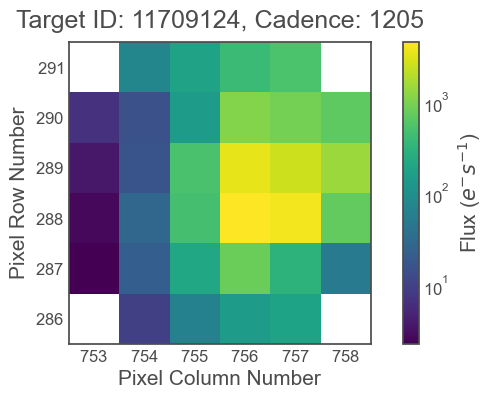

In [24]:
# displaying the signal of a star with 11709124 Kepler id
tpf = lk.search_targetpixelfile('11709124', quarter=1).download()
tpf.plot(frame=100, scale='log', show_colorbar=True)

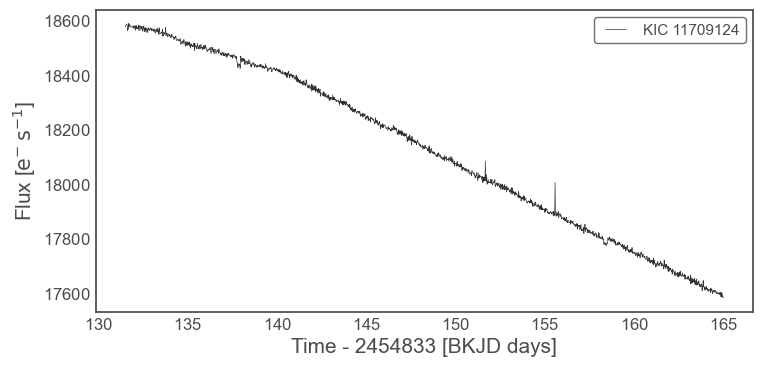

In [25]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

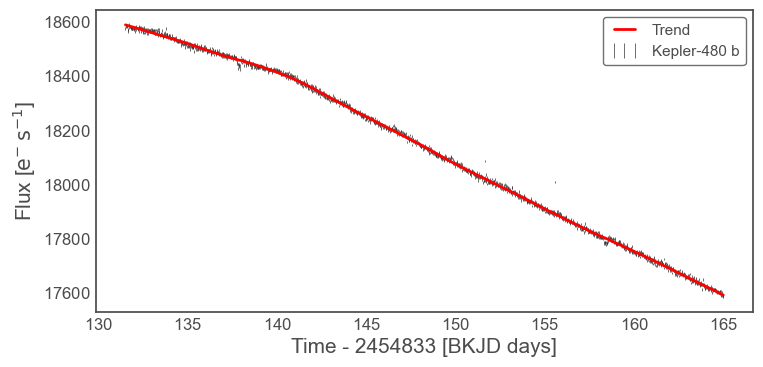

In [26]:
# flatten method removes long-term variability
flat, trend = lc.flatten(window_length=301, return_trend=True)
ax = lc.errorbar(label="Kepler-154 b")                   # plot() returns a matplotlib axes ...
trend.plot(ax=ax, color='red', lw=2, label='Trend')  # which we can pass to the next plot() to use the same axes

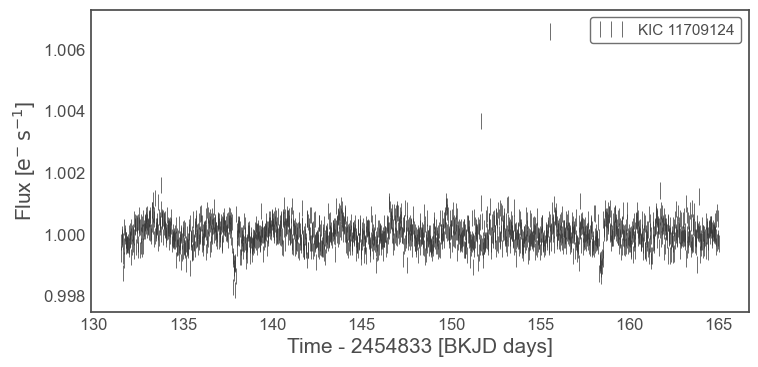

In [27]:
# flatten-normalized light curves
flat.errorbar()

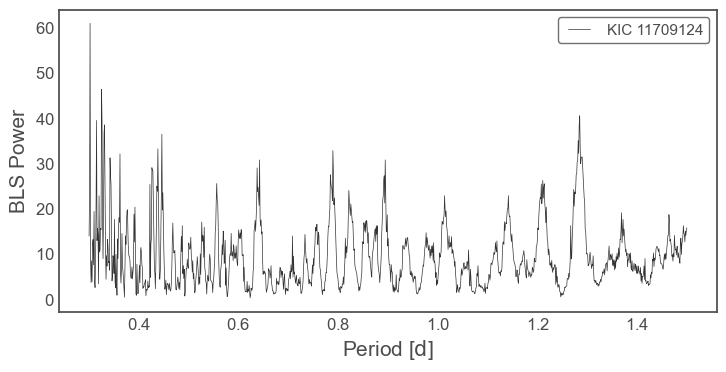

In [28]:
# BLS algorithm to search a pre-defined grid of transit periods
periodogram = flat.to_periodogram(method="bls", period=np.arange(0.3, 1.5, 0.001))
periodogram.plot();

In [29]:
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period))

Best fit period: 0.302 d


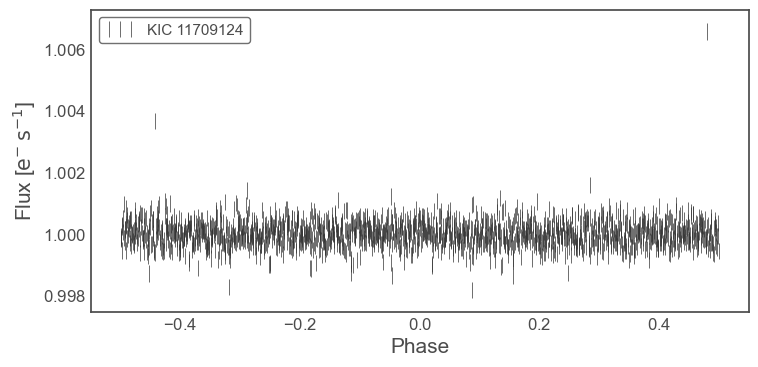

In [30]:
flat.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power).errorbar()

### Exoplanets & Non-Exoplanets flux distributions

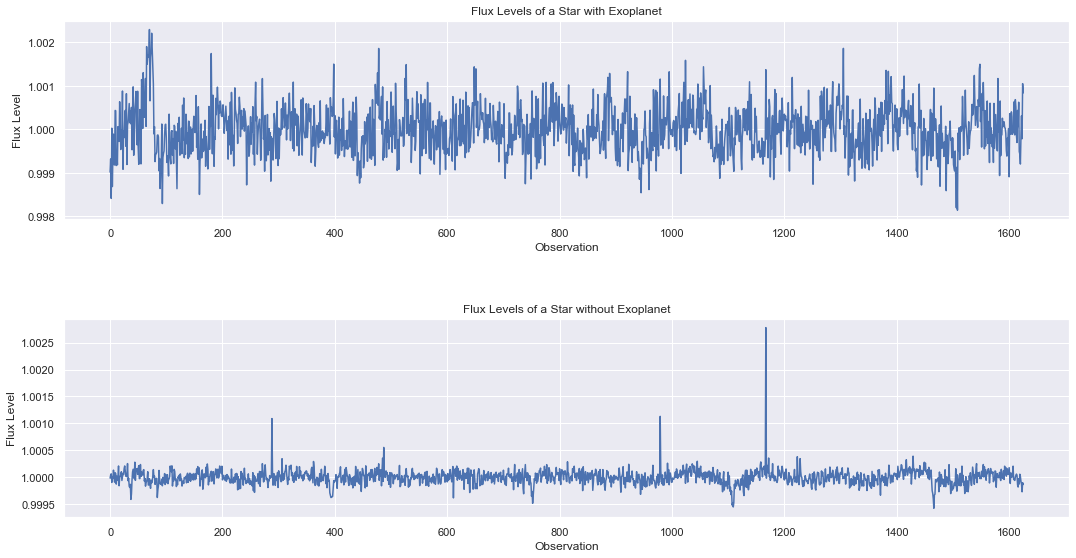

In [47]:
plt.figure(figsize=(18, 12))
# flux levels of an star with id 1
flux = df.iloc[1, 1:].values
plt.subplot(211)
plt.plot(flux)
plt.xlabel('Observation')
plt.ylabel('Flux Level')
plt.title('Flux Levels of a Star with Exoplanet')

# flux levels of an star with id 4
flux_1 = df.iloc[4, 1:].values
plt.subplot(212)
plt.plot(flux_1)
plt.xlabel('Observation')
plt.ylabel('Flux Level')
plt.title('Flux Levels of a Star without Exoplanet')

plt.subplots_adjust(hspace = .5, top = .7)
plt.show()

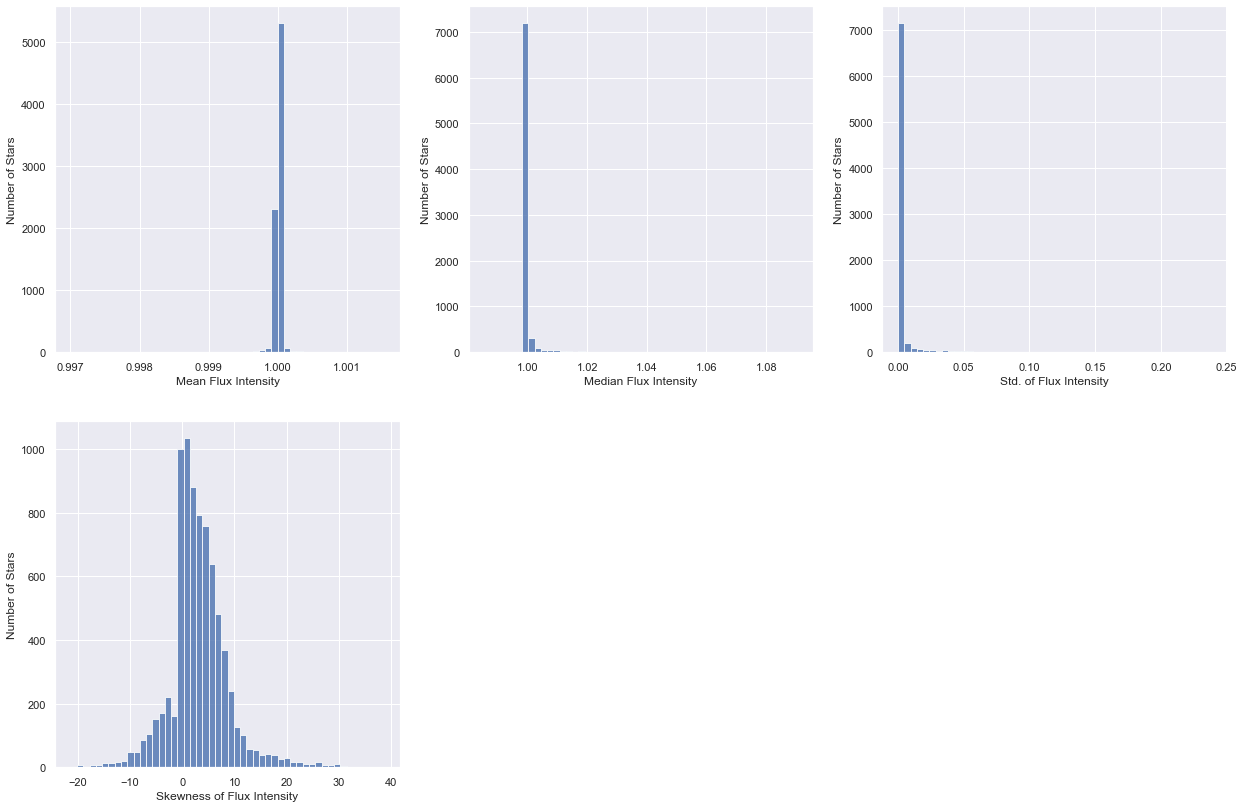

In [84]:
x = df.iloc[:, 1:]
def descriptive_statistics(x):
    means = x.mean(axis=1)
    medians = x.median(axis=1)
    stds = x.std(axis=1)
    skews = x.skew(axis=1)
    
    plt.figure(figsize=(21, 14))
    plt.subplot(231)
    plt.hist(means, alpha=.8, bins=50)
    plt.xlabel('Mean Flux Intensity')
    plt.ylabel('Number of Stars')
    plt.subplot(232)
    plt.hist(medians, alpha=.8, bins=50)
    plt.xlabel('Median Flux Intensity')
    plt.ylabel('Number of Stars')
    plt.subplot(233)
    plt.hist(stds, alpha=.8, bins=50)
    plt.xlabel('Std. of Flux Intensity')
    plt.ylabel('Number of Stars')
    plt.subplot(234)
    plt.hist(skews, alpha=.8, bins=50)
    plt.xlabel('Skewness of Flux Intensity')
    plt.ylabel('Number of Stars')
    plt.show()

descriptive_statistics(x)

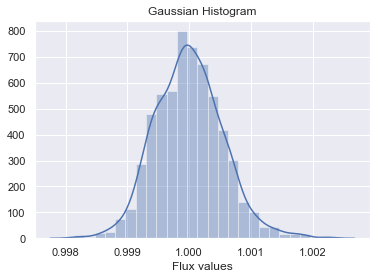

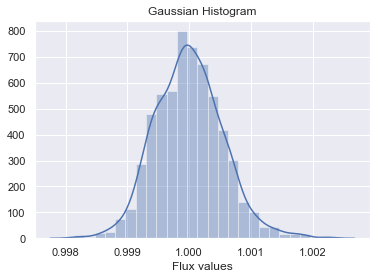

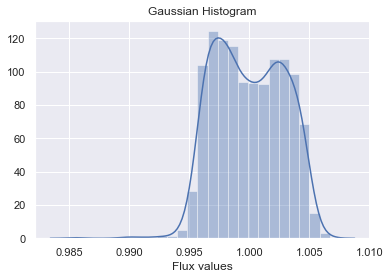

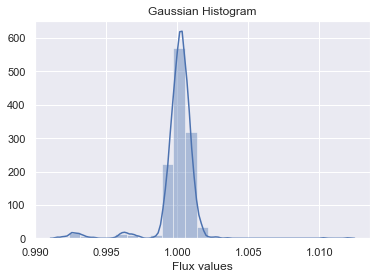

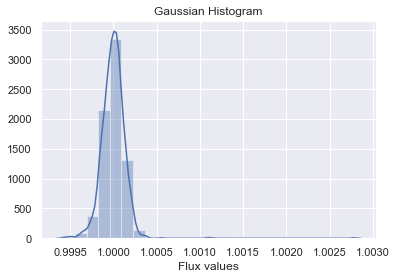

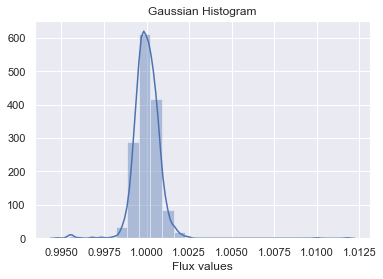

In [104]:
# Histograms of flux values for first 6 stars in the dataset.
labels=[0, 1, 2, 3, 4, 5]
for i in labels:
    sns.distplot(df.iloc[i,1:], bins=25)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

In [109]:
target_count = df['Disposition'].value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Percentage of Majority Class: {round(target_count[1] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[0] /sum(target_count),4)*100}')

Class 0: 3812
Class 1: 4076
Percentage of Majority Class: 51.67
Percentage of Minority Class: 48.33


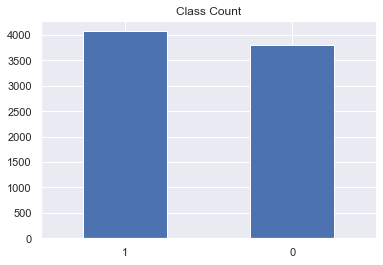

In [108]:
target_count.plot(kind='bar', title='Class Count', rot=0)

# Part 3: Feature Engineering

My dataset is time-series and not really appropriate for the classic machine learning algorithms, so I'm making my own dataset that has more characteristic features to work on.

In [5]:
target = df['Disposition']
df_values = df.iloc[:, 1:].values

In [6]:
# target values
disposition = []
for i in range(len(df)):
    disposition.append(target[i])

# median flux
medians = []
for i in range(len(df)):
    medians.append(np.median(df_values[i]))
    
# std
stds = []
for i in range(len(df)):
    stds.append(np.std(df_values[i]))

# min flux
minimum = []
for i in range(len(df)):
    minimum.append(np.amin(df_values[i]))

# max flux
maximum = []
for i in range(len(df)):
    maximum.append(np.amax(df_values[i]))

# first percentile
frst_perc = []
for i in range(len(df)):
    frst_perc.append(np.percentile(df_values[i], 1))

# third percentile
thrd_perc = []
for i in range(len(df)):
    thrd_perc.append(np.percentile(df_values[i], 3))

# fifth percentile 
fifth_perc = []
for i in range(len(df)):
    fifth_perc.append(np.percentile(df_values[i], 5))
    
# seventh percentile
seventh_perc = []
for i in range(len(df)):
    seventh_perc.append(np.percentile(df_values[i], 7))
    
# delta
delta = []
for i in range(len(df)):
    delta.append(maximum[i]-minimum[i])

In [7]:
df_reduced = pd.DataFrame({'target': target,
                           'median' : medians,
                           'standard deviation' : stds,
                           'first percentile': frst_perc,
                           'third percentile': thrd_perc,
                           'fifth percentie': fifth_perc,
                           'seventh percentile' : seventh_perc,
                           'minimum': minimum,
                           'maximum': maximum,
                           'delta': delta})

In [11]:
df_reduced.head()

target    median  standard deviation  first percentile  third percentile  \
0       1  0.999981            0.000548          0.998773          0.999048   
1       1  0.999981            0.000548          0.998773          0.999048   
2       1  0.999889            0.002861          0.994854          0.995604   
3       0  1.000215            0.001436          0.992693          0.996204   
4       0  1.000001            0.000145          0.999660          0.999757   

   fifth percentie  seventh percentile   minimum   maximum     delta  
0         0.999170            0.999237  0.998139  1.002296  0.004157  
1         0.999170            0.999237  0.998139  1.002296  0.004157  
2         0.995924            0.996116  0.985526  1.006699  0.021173  
3         0.998810            0.999088  0.991529  1.012022  0.020493  
4         0.999801            0.999830  0.999422  1.002780  0.003358

In [8]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   target              7888 non-null   int32  
 1   median              7888 non-null   float64
 2   standard deviation  7888 non-null   float64
 3   first percentile    7888 non-null   float64
 4   third percentile    7888 non-null   float64
 5   fifth percentie     7888 non-null   float64
 6   seventh percentile  7888 non-null   float64
 7   minimum             7888 non-null   float64
 8   maximum             7888 non-null   float64
 9   delta               7888 non-null   float64
dtypes: float64(9), int32(1)
memory usage: 585.6 KB


In [9]:
df_reduced.describe()

target       median  standard deviation  first percentile  \
count  7888.000000  7888.000000         7888.000000       7888.000000   
mean      0.516734     1.000619            0.003328          0.986599   
std       0.499752     0.004076            0.012827          0.055837   
min       0.000000     0.985568            0.000011          0.087550   
25%       0.000000     0.999980            0.000272          0.998416   
50%       1.000000     0.999993            0.000472          0.999108   
75%       1.000000     1.000003            0.000814          0.999460   
max       1.000000     1.090601            0.238398          0.999957   

       third percentile  fifth percentie  seventh percentile      minimum  \
count       7888.000000      7888.000000         7888.000000  7888.000000   
mean           0.991622         0.994195            0.995953     0.981881   
std            0.042028         0.031685            0.022695     0.066814   
min            0.172785         0.320071            0.475503     0.079371   
25%            0.998820         0.999010            0.999127     0.997440   
50%            0.999302         0.999402            0.999466     0.998641   
75%            0.999573         0.999631            0.999672     0.999182   
max            0.999962         1.000788            1.001898     0.999950   

           maximum        delta  
count  7888.000000  7888.000000  
mean      1.009593     0.027712  
std       0.013525     0.076027  
min       1.000053     0.000103  
25%       1.003214     0.004325  
50%       1.006266     0.008300  
75%       1.010936     0.014752  
max       1.401710     1.091144

<Figure size 1080x504 with 0 Axes>

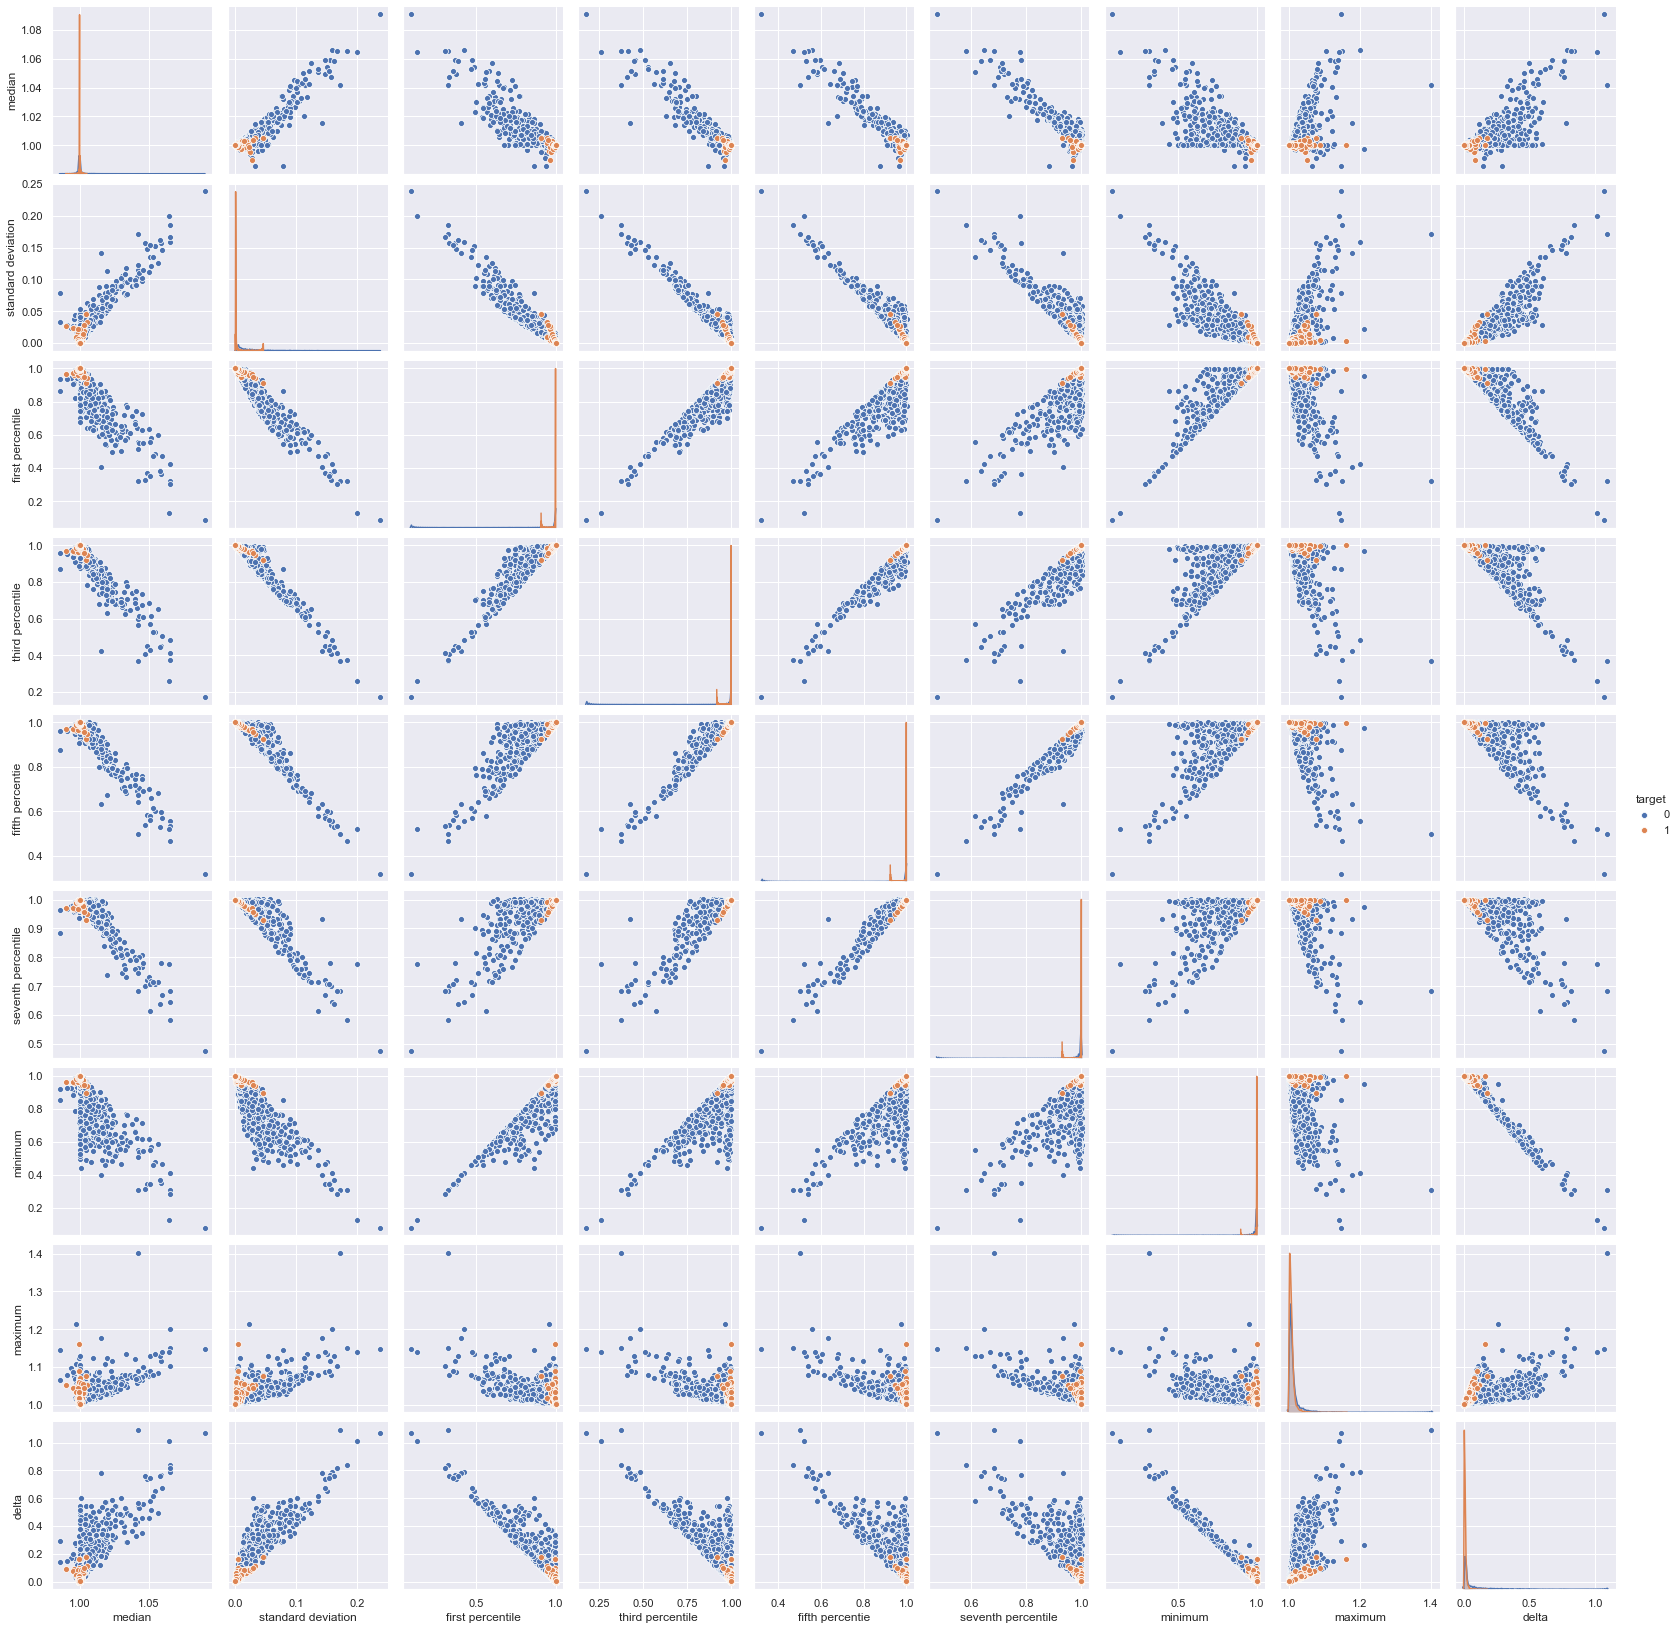

In [9]:
plt.figure(figsize = (15,7))
sns.pairplot(df_reduced, hue='target')

In [10]:
corr_mtrx=df_reduced.corr()
corr_mtrx["target"].sort_values(ascending=False)

target                1.000000
minimum               0.248197
first percentile      0.222438
third percentile      0.180693
fifth percentie       0.160971
seventh percentile    0.148838
maximum              -0.140245
median               -0.158518
standard deviation   -0.215810
delta                -0.243071
Name: target, dtype: float64

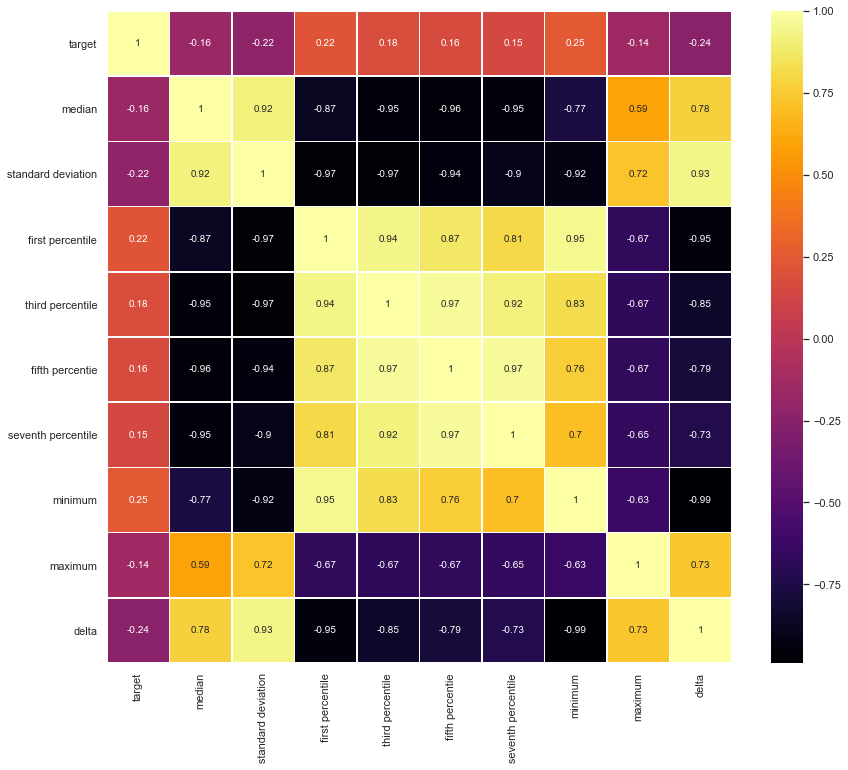

In [11]:
plt.figure(figsize = (14,12))
ax = sns.heatmap(corr_mtrx, linewidths=.5, annot=True, cmap='inferno')

In [8]:
# Basic validation: splitting the data 60 - 20 - 20 train/val/test
X_train, X_test, y_train, y_test = train_test_split(df_reduced.iloc[:, 1:], df_reduced.loc[:, 'target'], test_size=0.25,random_state=76)
X_train.shape # shape of my train set

(5916, 9)

In [10]:
# List to contain model and accuracy values
eva_list = []
# to contain model names
models =[]

# Part 5: ML Algorithms

## 1. Modeling on the Reduced DataFrame

### 1.1. Logistic Regression

In [9]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_acc = round(lr.score(X_train, y_train) * 100, 2)
lr_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy of Logistic Regression: % {lr_acc}')
print(f'Test Accuracy of Logistic Regression: % {lr_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of Logistic Regression: % 61.61
Test Accuracy of Logistic Regression: % 62.47
Precision : 0.7459057621117013
Recall : 0.6009756782657546
F1-score : 0.5462979544730978


In [12]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', round(lr_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.2. KNN

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

knn_acc = round(knn.score(X_train, y_train) * 100, 2)
knn_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy of KNN: % {knn_acc}')
print(f'Test Accuracy of KNN: % {knn_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of KNN: % 75.78
Test Accuracy of KNN: % 60.4
Precision : 0.6015623772271969
Recall : 0.6001102904728859
F1-score : 0.6000445626433646


In [14]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'KNN'),
    ('Train Accuracy', round(knn_acc, 2)),
    ('Test Accuracy', round(knn_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.3. Naive Bayes

In [15]:
nbg = GaussianNB()
nbg.fit(X_train, y_train)
y_pred = nbg.predict(X_test)

nbg_acc=round(nbg.score(X_train, y_train) * 100, 2)
nbg_acc_test=round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of GaussianNB: % {nbg_acc}')
print(f'Test Accuracy Score of GaussianNB: % {nbg_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of GaussianNB: % 61.16
Test Accuracy Score of GaussianNB: % 61.82
Precision : 0.7463775589130098
Recall    : 0.5937489673176696
F1-score   : 0.5337582809684435


In [16]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'GaussianNB'),
    ('Train Accuracy', round(nbg_acc, 2)),
    ('Test Accuracy', round(nbg_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.4. Linear SVC

In [17]:
svc = LinearSVC()
y_pred = svc.fit(X_train, y_train).predict(X_test)

svc_acc = round(svc.score(X_train, y_train) * 100, 2)
svc_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of LinearSVC: % {svc_acc}')
print(f'Test Accuracy Score of LinearSVC: % {svc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of LinearSVC: % 61.58
Test Accuracy Score of LinearSVC: % 62.32
Precision : 0.7333293898649644
Recall    : 0.5998004857737682
F1-score   : 0.5469824564983553


In [18]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Linear SVC'),
    ('Train Accuracy', round(svc_acc, 2)),
    ('Test Accuracy', round(svc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.5. Decision Trees

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

dt_acc = round(dt.score(X_train, y_train) * 100, 2)
dt_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Decision Trees: % {dt_acc}')
print(f'Test Accuracy Score of Decision Trees: % {dt_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Decision Trees: % 98.97
Test Accuracy Score of Decision Trees: % 62.02
Precision : 0.6182510686056786
Recall    : 0.6176183867023561
F1-score   : 0.6177597314793608


In [20]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Decision Trees'),
    ('Train Accuracy', round(dt_acc, 2)),
    ('Test Accuracy', round(dt_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [21]:
# View feature importances
importances_dt = pd.DataFrame({'feature': X_train.columns,
                             'importance': dt.feature_importances_})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt.head(10)

importance
feature                       
minimum               0.244407
median                0.119962
first percentile      0.110405
standard deviation    0.104137
delta                 0.097372
maximum               0.093261
seventh percentile    0.087006
fifth percentie       0.077790
third percentile      0.065661

### 1.6. Random Forest

In [11]:
num_estimator = 100
seed = 7
rf = RandomForestClassifier(n_estimators=num_estimator)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_acc = round(rf.score(X_train, y_train) * 100, 2)
rf_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Random Forest: % {rf_acc}')
print(f'Test Accuracy Score of Random Forest: % {rf_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Random Forest: % 98.97
Test Accuracy Score of Random Forest: % 66.53
Precision : 0.6656820208533406
Recall    : 0.6596320346320346
F1-score   : 0.6593935282886141


In [23]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', round(rf_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [24]:
# View feature importances
importances_rf = pd.DataFrame({'feature': X_train.columns,
                             'importance': rf.feature_importances_})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(10)

importance
feature                       
minimum               0.150727
standard deviation    0.121056
delta                 0.117543
median                0.115849
first percentile      0.111001
maximum               0.104098
seventh percentile    0.093917
fifth percentie       0.093480
third percentile      0.092329

### 1.8. Bagging Classifier

In [25]:
bag = BaggingClassifier(base_estimator=rf, n_estimators=num_estimator,
    bootstrap=True, n_jobs=-1, random_state=seed)

bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

bag_acc = round(bag.score(X_train, y_train) * 100, 2)
bag_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of Bagged Classifier: % {bag_acc}')
print(f'Test Accuracy Score of Bagged Classifier: % {bag_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Bagged Classifier: % 98.28
Test Accuracy Score of Bagged Classifier: % 66.89
Precision : 0.6730389485263184
Recall    : 0.6609869138495092
F1-score   : 0.6593833213906044


In [26]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Bagging Classifier'),
    ('Train Accuracy', round(bag_acc, 2)),
    ('Test Accuracy', round(bag_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.7. Stochastic Gradient Boosting Classifier

In [27]:
gbc = GradientBoostingClassifier(n_estimators=num_estimator, learning_rate=0.01,
                                random_state=seed)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

gbc_acc = round(gbc.score(X_train, y_train) * 100, 2)
gbc_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Gradient Boosting: % {gbc_acc}')
print(f'Test Accuracy Score of Gradient Boosting: % {gbc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Gradient Boosting: % 64.74
Test Accuracy Score of Gradient Boosting: % 64.4
Precision : 0.6983221059921986
Recall    : 0.6253800270975843
F1-score   : 0.5988036655132241


In [28]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Gradient Boosting'),
    ('Train Accuracy', round(gbc_acc, 2)),
    ('Test Accuracy', round(gbc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

## Evaluation - Performance List of Models 

In [29]:
results = pd.DataFrame(data=eva_list)
results = results[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
results = results.sort_values(by='Test Accuracy', ascending=False)
results = results.set_index('Model')
results

Train Accuracy  Test Accuracy  Precision  Recall    F1
Model                                                                      
Bagging Classifier            98.28          66.89       0.67    0.66  0.66
Random Forest                 98.97          65.97       0.66    0.65  0.65
Gradient Boosting             64.74          64.40       0.70    0.63  0.60
Logistic Regression           61.61          62.47       0.75    0.60  0.55
Linear SVC                    61.58          62.32       0.73    0.60  0.55
Decision Trees                98.97          62.02       0.62    0.62  0.62
GaussianNB                    61.16          61.82       0.75    0.59  0.53
KNN                           75.78          60.40       0.60    0.60  0.60

### Optimization of the Model

I got best test accuracy on Bagging Classifier, so I go into the GridSearch with it.

In [48]:
n_est = [60, 80, 100, 120, 140, 160, 180, 200]
max_features_opt = [0.88, 0.91, 0.93, 0.95, 0.97, 0.99]

param_grid = dict(n_estimators = n_est, max_features = max_features_opt)

In [64]:
# GridSearchCV on the Bagging Classifier model to make it more robust
# Cross-validation
kf = KFold(n_splits = 10, shuffle = True, random_state = 76)
bag_grid = GridSearchCV(bag, param_grid, cv=kf, scoring='accuracy',
                      n_jobs=-1, verbose=1)
bag_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 167.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 425.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 490.6min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=76, shuffle=True),
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(),
                                         n_estimators=100, n_jobs=-1,
                                         random_state=7),
             n_jobs=-1,
             param_grid={'max_features': [0.88, 0.91, 0.93, 0.95, 0.97, 0.99],
                         'n_estimators': [60, 80, 100, 120, 140, 160, 180,
                                          200]},
             scoring='accuracy', verbose=1)

In [65]:
# examine the results
print(bag_grid.best_score_)
print(bag_grid.best_params_)
print(bag_grid.best_estimator_)

0.658756584637157
{'max_features': 0.88, 'n_estimators': 180}
BaggingClassifier(base_estimator=RandomForestClassifier(), max_features=0.88,
                  n_estimators=180, n_jobs=-1, random_state=7)


In [12]:
# Optimized Bagging Classifier
opt_bag = BaggingClassifier(base_estimator=rf, n_estimators=180, max_features=0.88, 
                            bootstrap=True, random_state=seed, n_jobs = -1)

opt_bag.fit(X_train, y_train)
y_pred = opt_bag.predict(X_test)

opt_bag_acc = round(cross_val_score(opt_bag, X_train, y_train, cv=kf).mean())
opt_bag_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Bagging Classifier: {opt_bag_acc}')
print(f'Test Accuracy Score of Bagging Classifier: % {opt_bag_test}')

precision, recall, f1score, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

NameError: name 'kf' is not defined

### Confusion Matrix

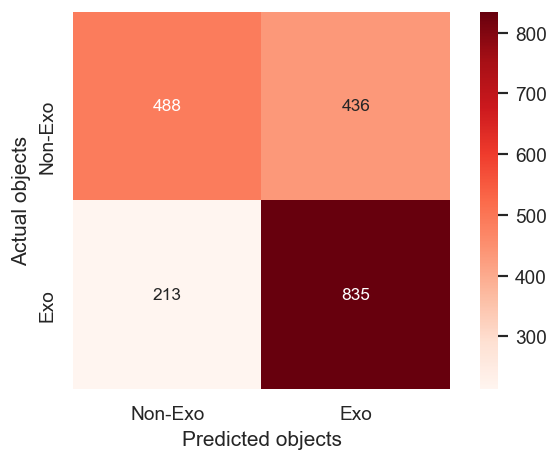

In [33]:
conf_mtrx = confusion_matrix(y_test, y_pred)
plt.figure(dpi=125)
sns.heatmap(conf_mtrx, cmap=plt.cm.Reds, annot=True, square=True,fmt='d',
           xticklabels=['Non-Exo', 'Exo'],
           yticklabels=['Non-Exo', 'Exo'])

plt.xlabel('Predicted objects')
plt.ylabel('Actual objects');

### Evaluation Graphs

ROC AUC score =  0.7447395162089818


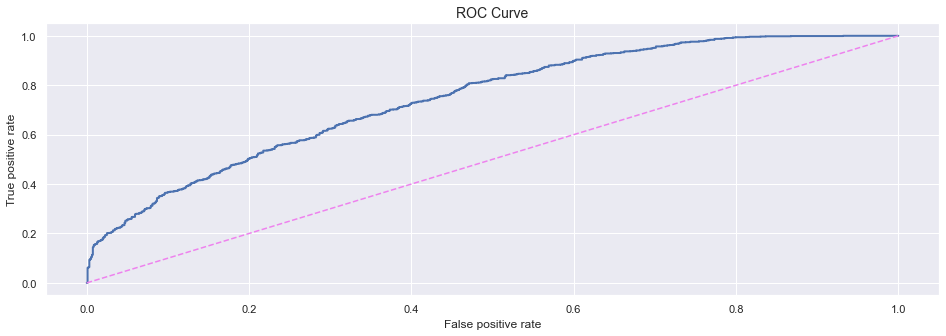

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, opt_bag.predict_proba(X_test)[:,1])

plt.figure(figsize = (16,5))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve', fontsize=14)
print("ROC AUC score = ", roc_auc_score(y_test, opt_bag.predict_proba(X_test)[:,1]))

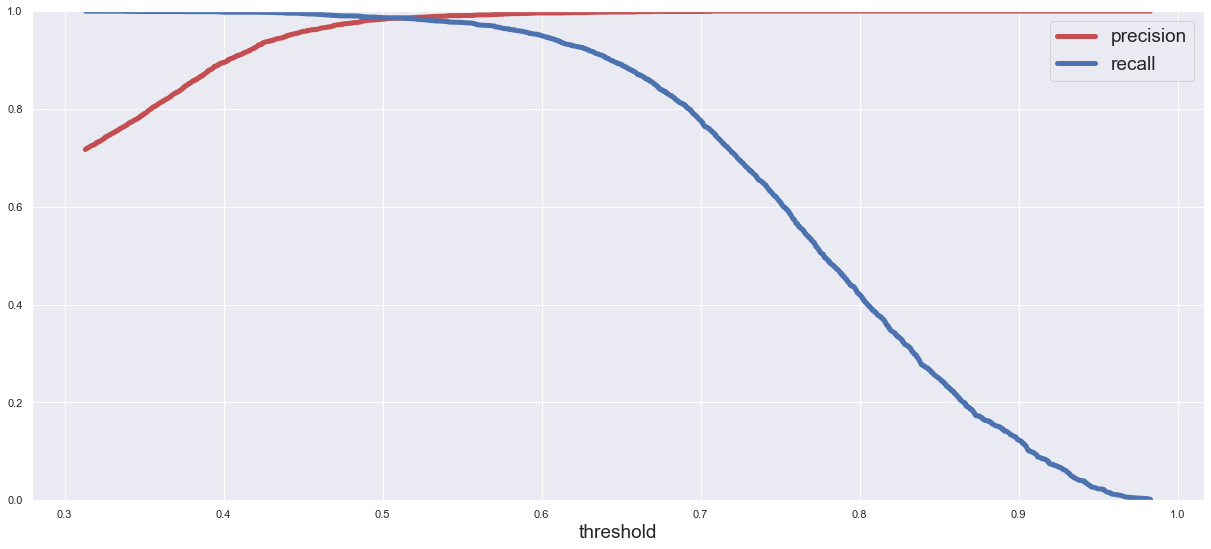

In [16]:
y_scores = opt_bag.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])
    

plt.figure(figsize = (21, 9))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

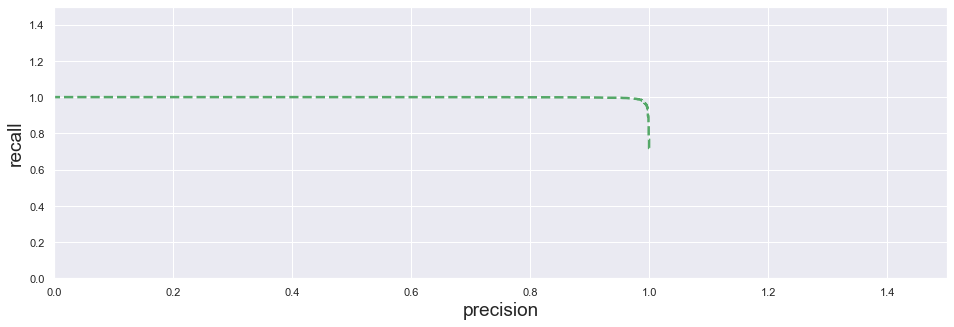

In [17]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize = (16,5))
plot_precision_vs_recall(precision, recall)
plt.show()

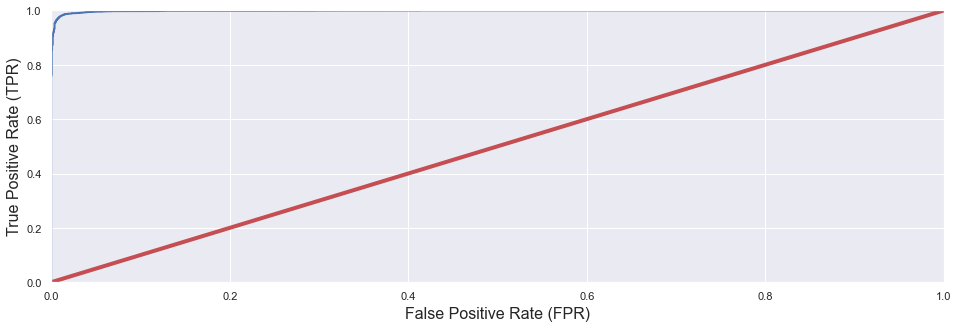

In [18]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize = (16,5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

Text(0.5, 1.0, 'Precision and Recall Curves')

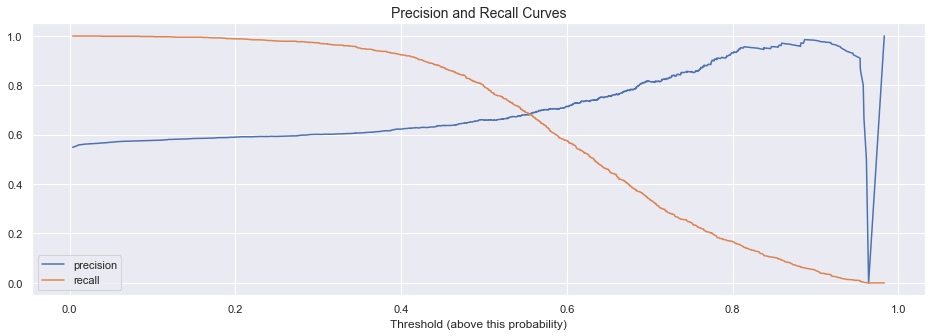

In [19]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, opt_bag.predict_proba(X_test)[:,1] )

plt.figure(figsize = (16,5))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability)')
plt.title('Precision and Recall Curves', fontsize=14)